## Exploratory Data Analysis

The exploratory data analysis is something that you should do before building your recommender system. It is a good way to understand your data and to get insights about it. The main goal of such a procedure is to get answers to several questions about your data, these answers should be the numerical justification for all your choices in the following steps, in particular for the feature engineering and the model selection.

In [2]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

For this data analysis, we will focus on the interaction data, i.e., the data that contains the user-item interactions. If you make the choice to use the other data available, you should repeat the same kind of analysis on the other data as well.

In [2]:
interactions = pd.read_csv("data/small_matrix.csv")

interactions.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


###  Data Quality & Missing Values

Try to check for missing values, duplicates, and other data quality issues, like impossible values, negative timestamps, etc.

In [32]:
# I do the most simple thing, I remove the rows with missing values
interactions = interactions.dropna()
# I also remove the duplicates
interactions = interactions.drop_duplicates()
# I also remove the rows with negative timestamps
interactions = interactions[interactions["timestamp"] >= 0]

### Basic Statistics & Distributions


#### Interactions per User

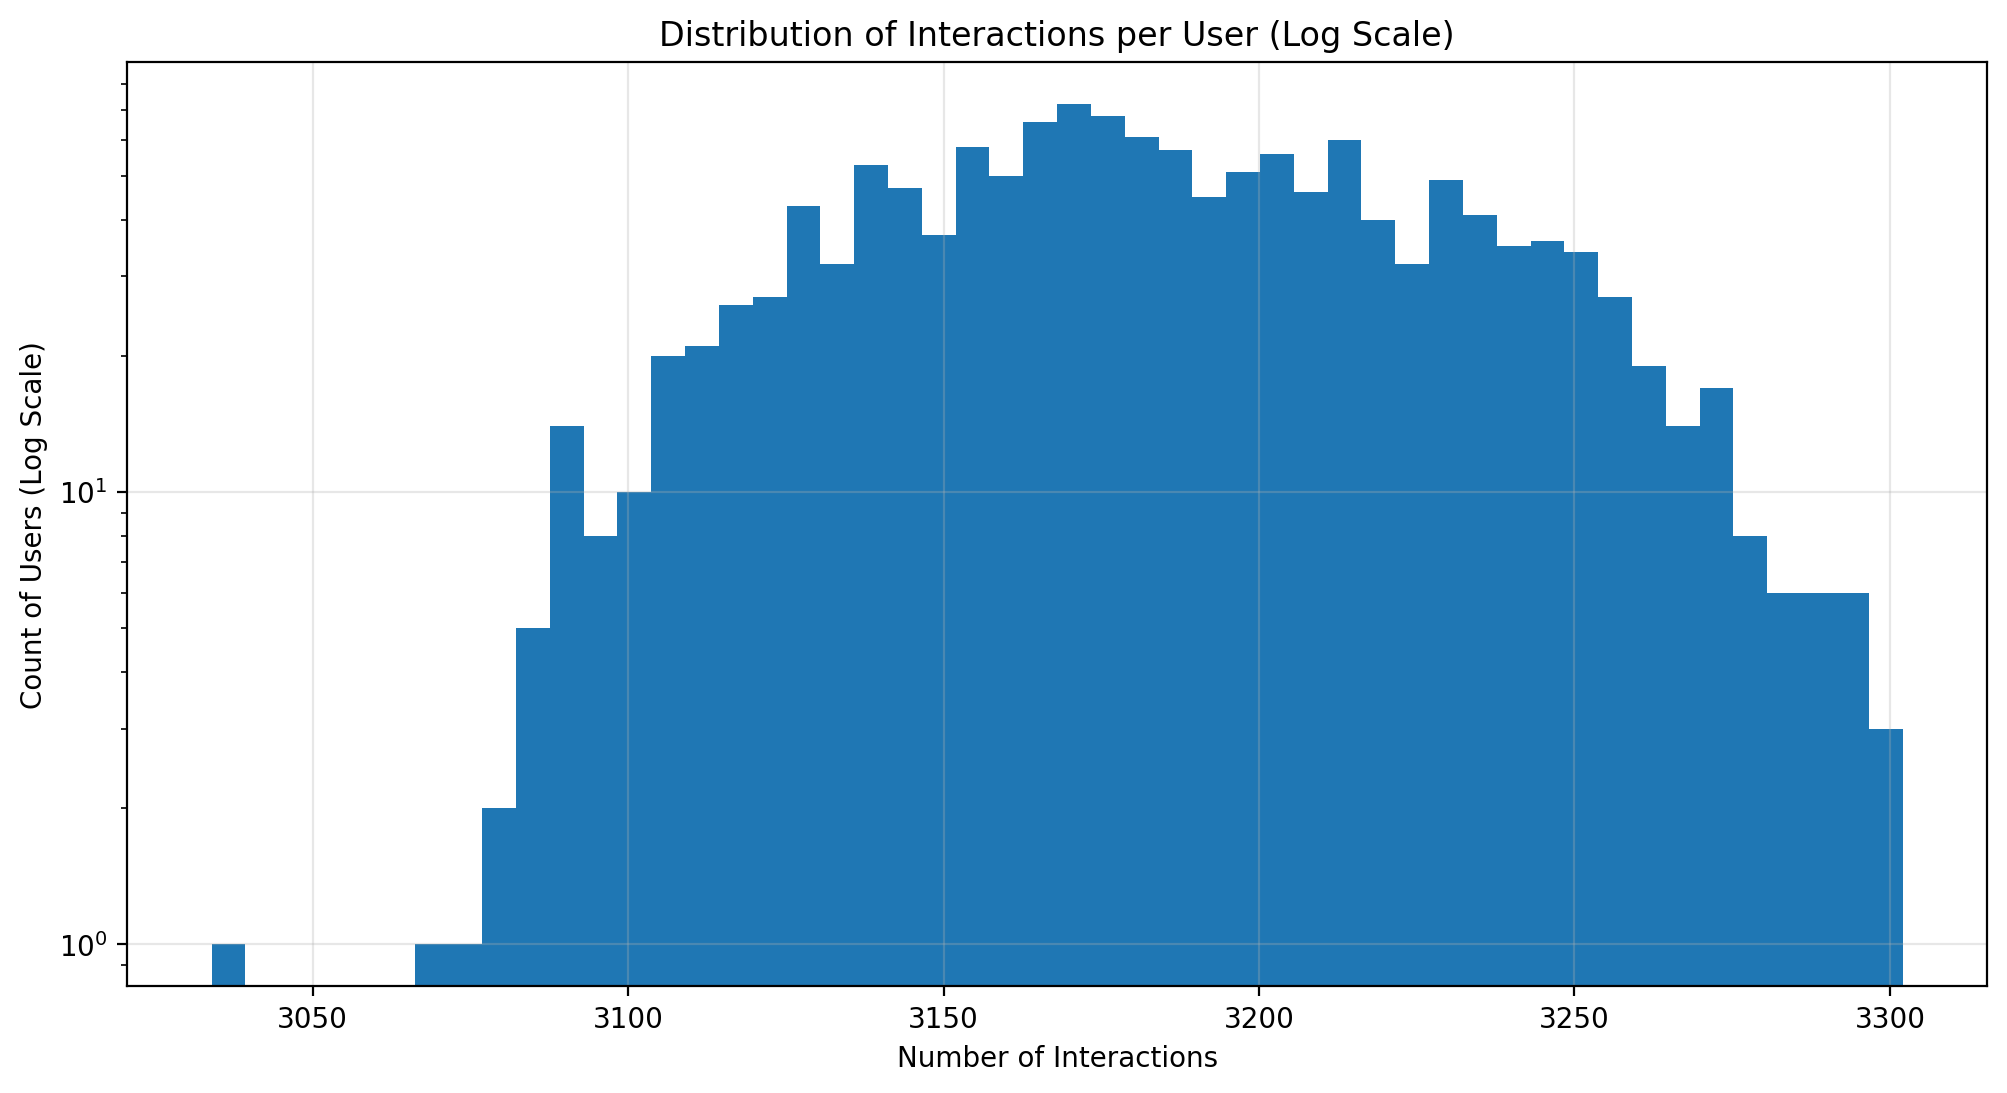

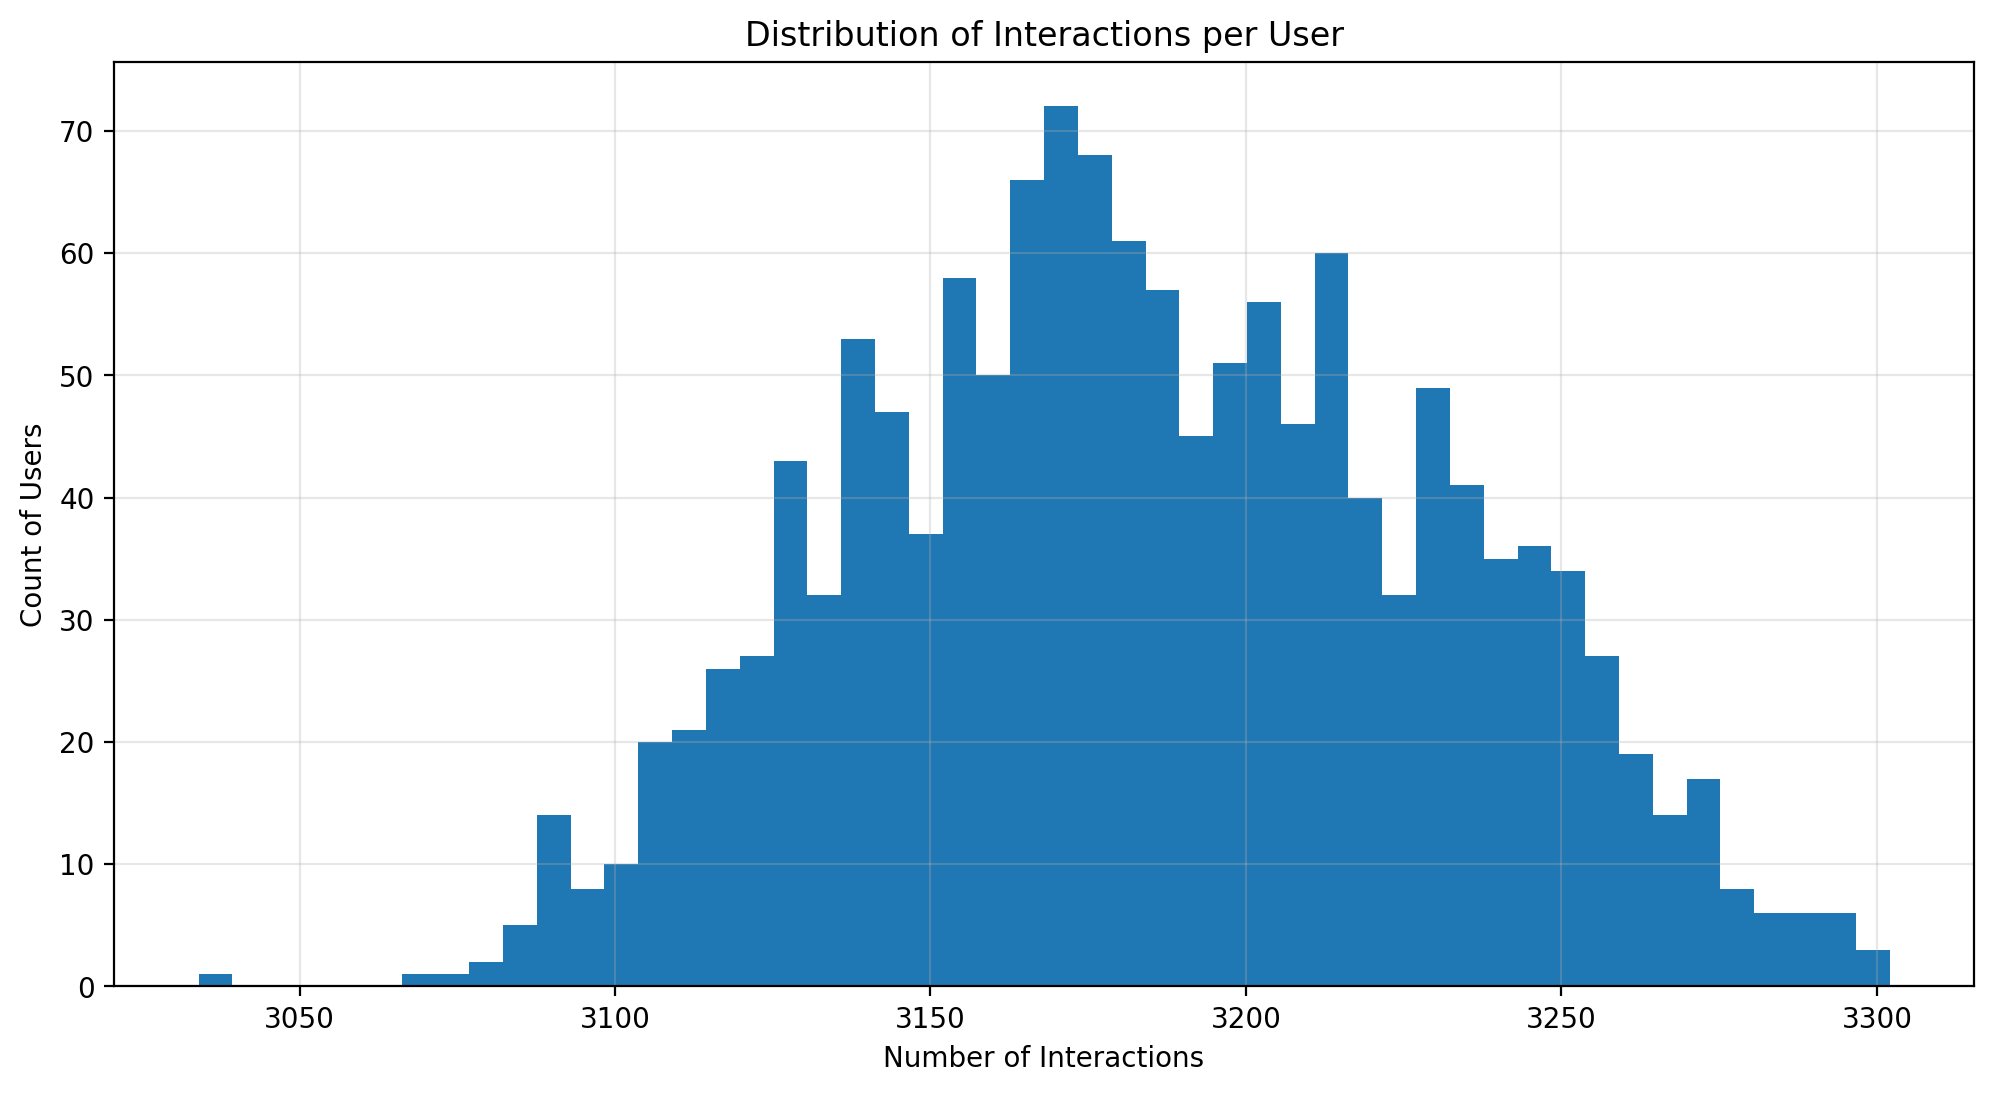

In [4]:
# Plot log histogram of interactions per user
# Get counts per user
user_counts = interactions["user_id"].value_counts()

# Create histogram with log scale
plt.figure(figsize=(12, 6))
plt.hist(user_counts, bins=50, log=True)
plt.title("Distribution of Interactions per User (Log Scale)")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Users (Log Scale)")
plt.grid(True, alpha=0.3)
plt.show()

# Also plot regular scale for comparison
plt.figure(figsize=(12, 6))
plt.hist(user_counts, bins=50)
plt.title("Distribution of Interactions per User")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Users")
plt.grid(True, alpha=0.3)
plt.show()

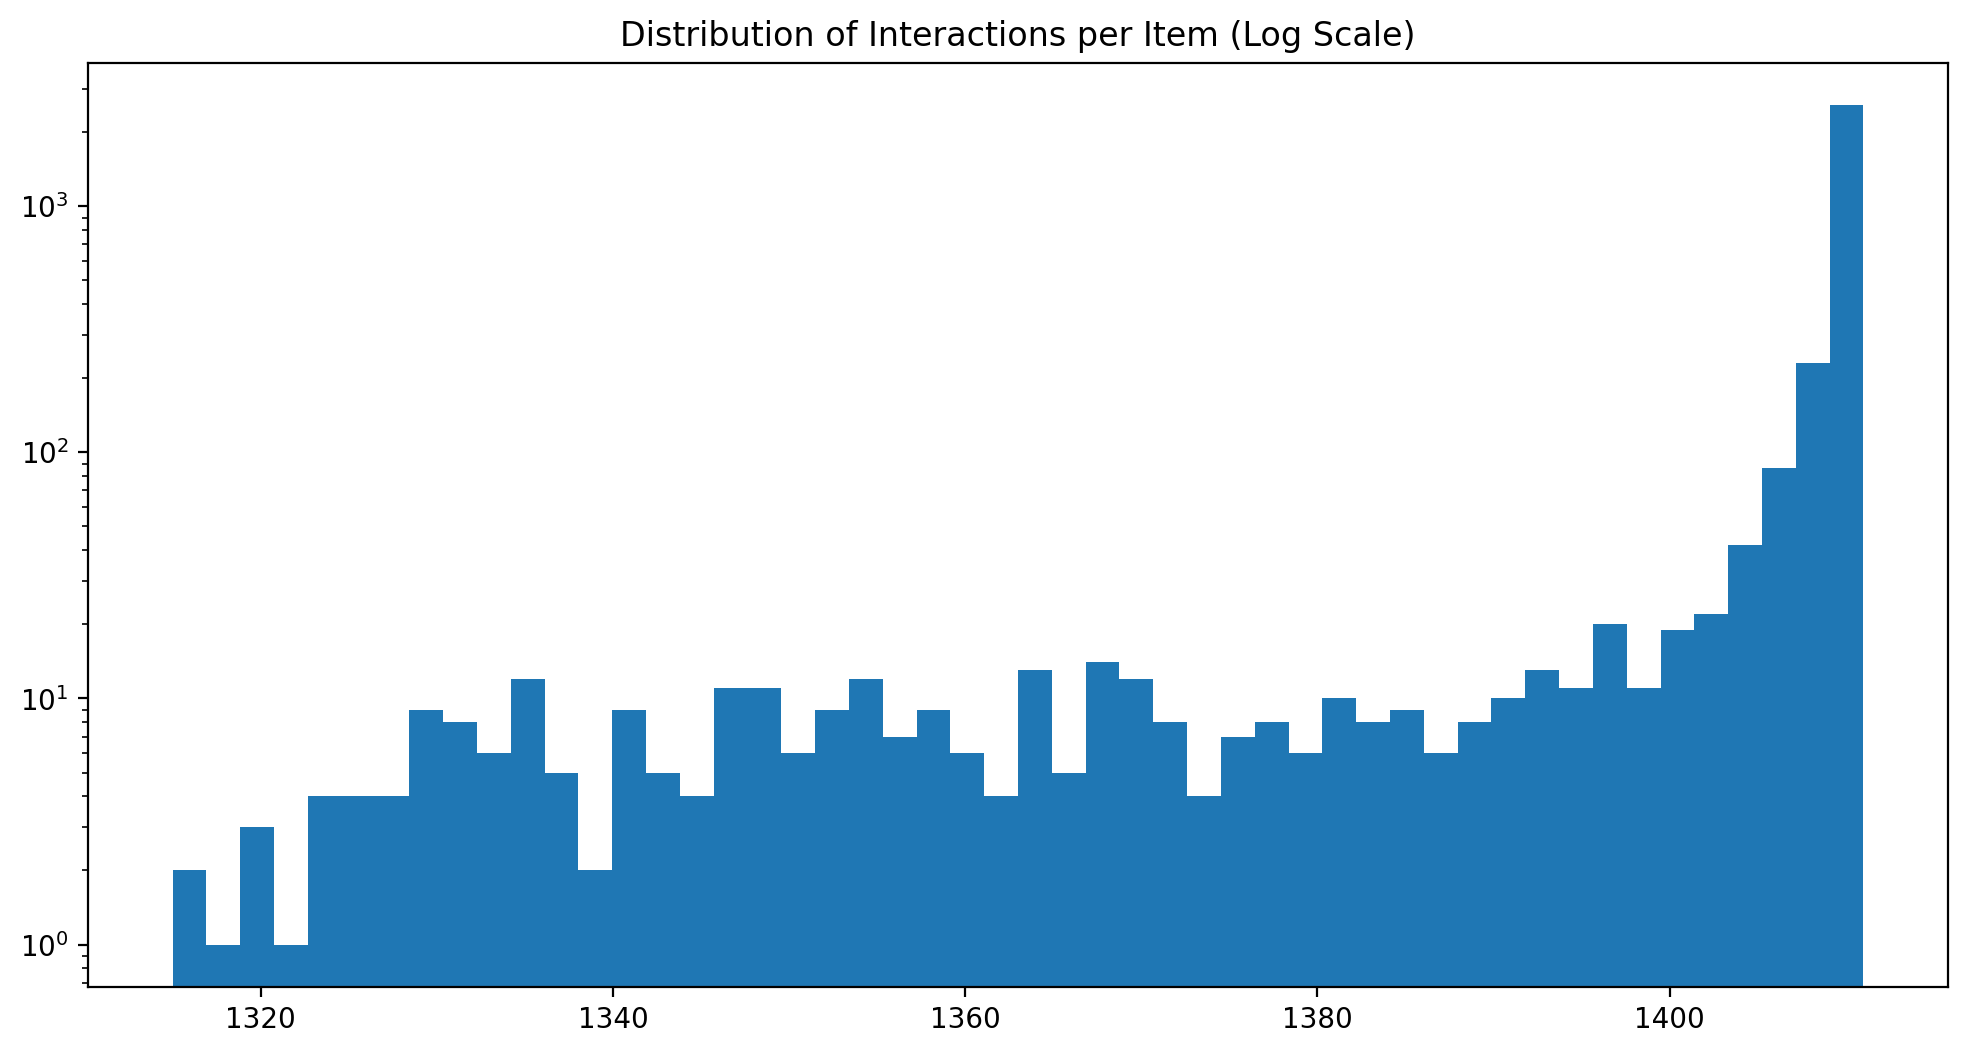

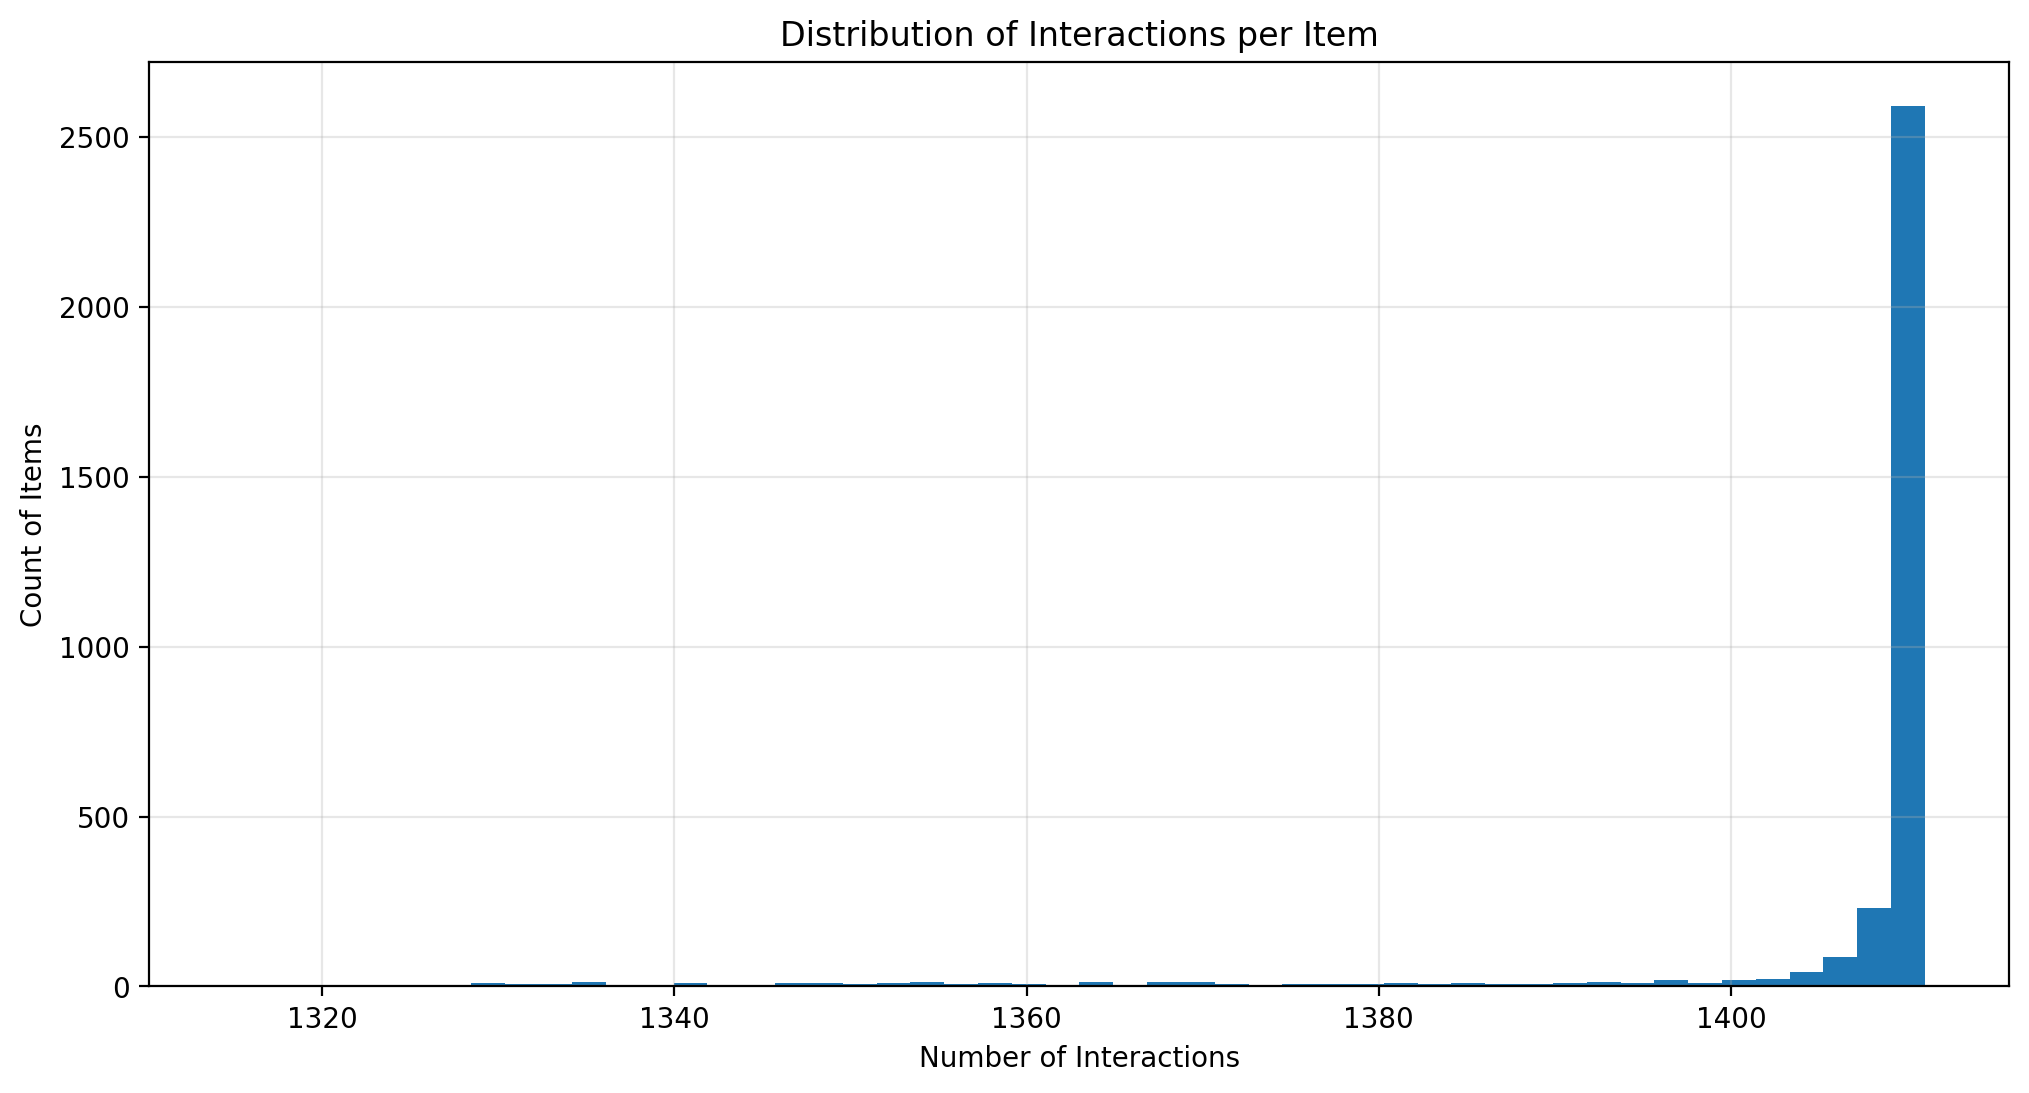

In [4]:
# Let's see the distribution of the interactions per item
item_counts = interactions["video_id"].value_counts()

# Plot log histogram of interactions per item
plt.figure(figsize=(12, 6))
plt.hist(item_counts, bins=50, log=True)
plt.title("Distribution of Interactions per Item (Log Scale)")

# Also plot regular scale for comparison
plt.figure(figsize=(12, 6))
plt.hist(item_counts, bins=50)
plt.title("Distribution of Interactions per Item")
plt.xlabel("Number of Interactions")
plt.ylabel("Count of Items")
plt.grid(True, alpha=0.3)
plt.show()

### Temporal Analysis

Let's see the distribution of the interactions over time.

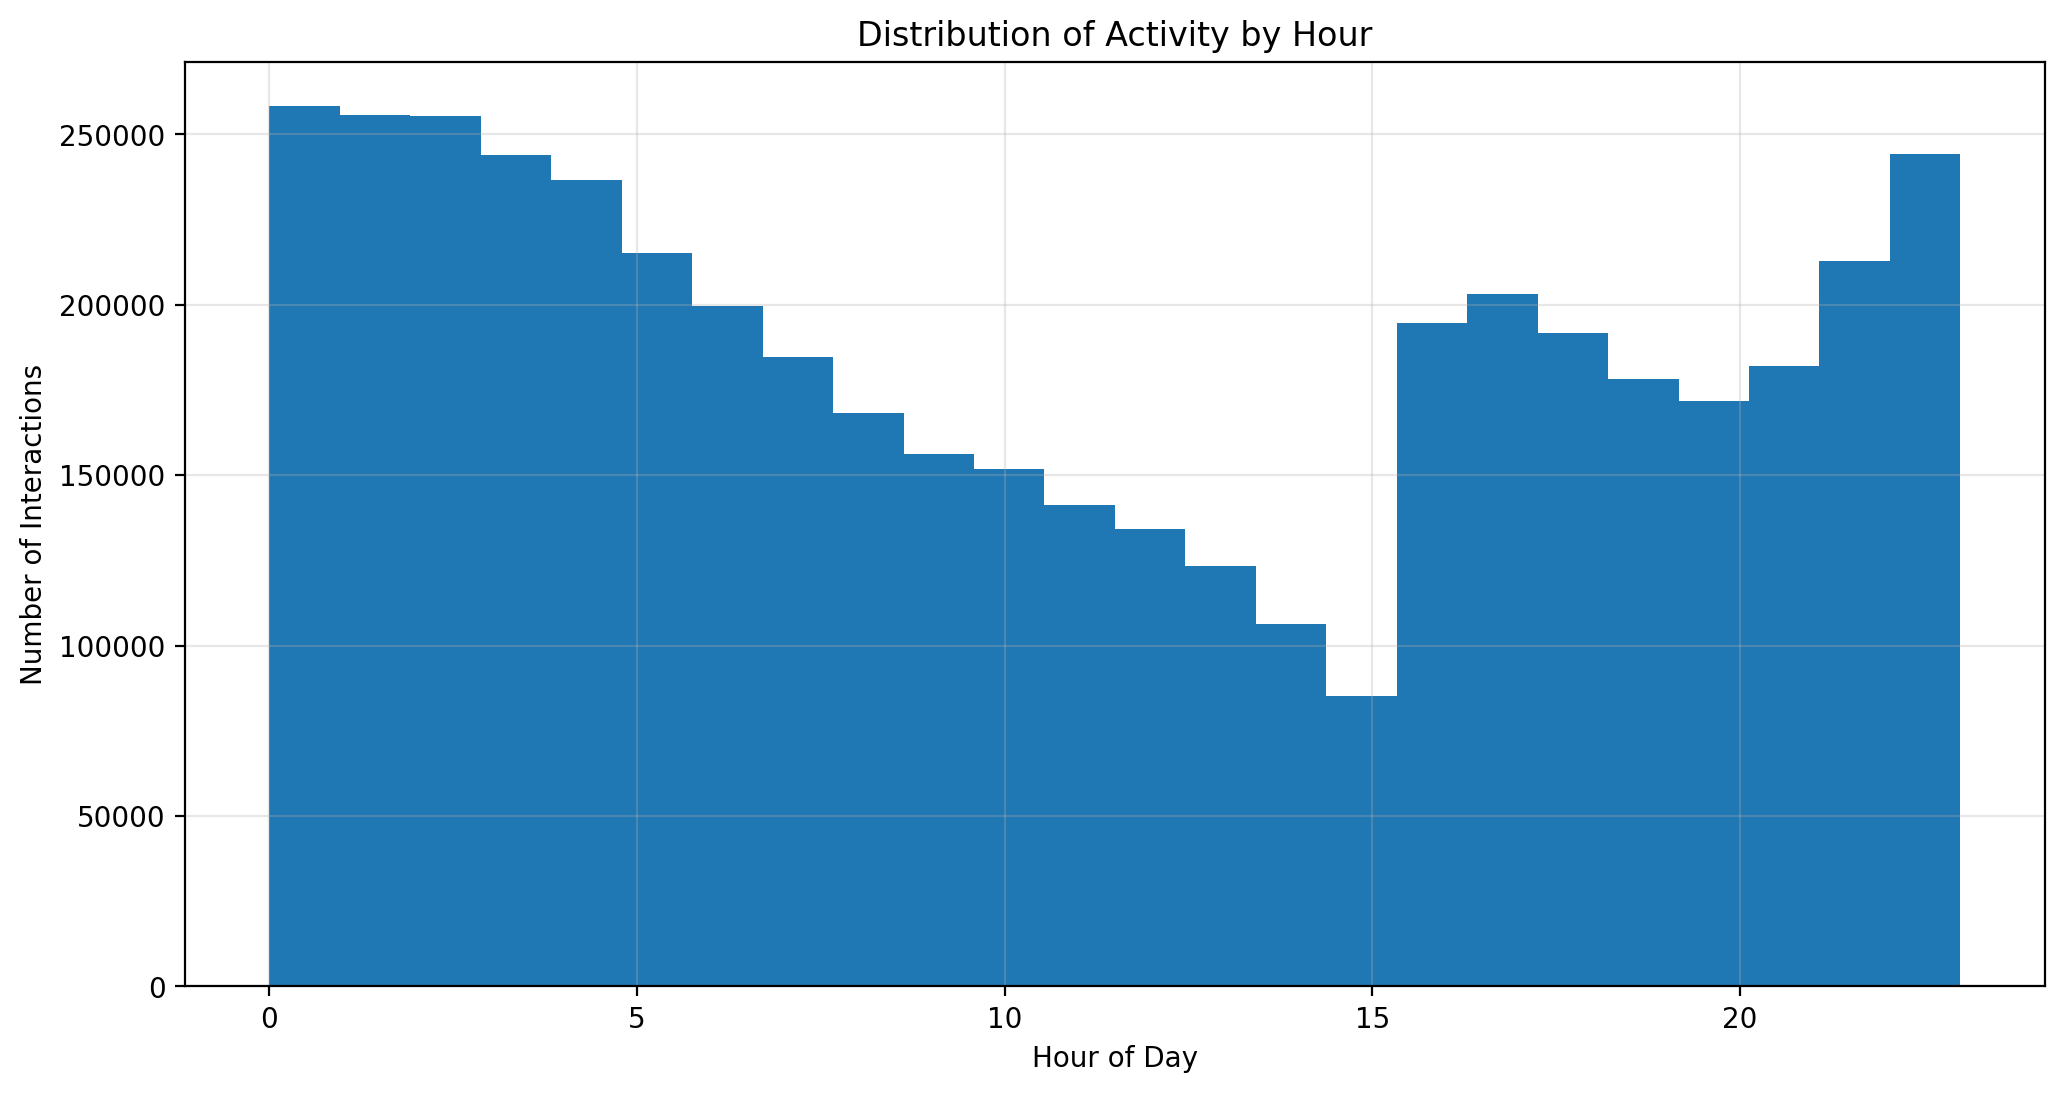

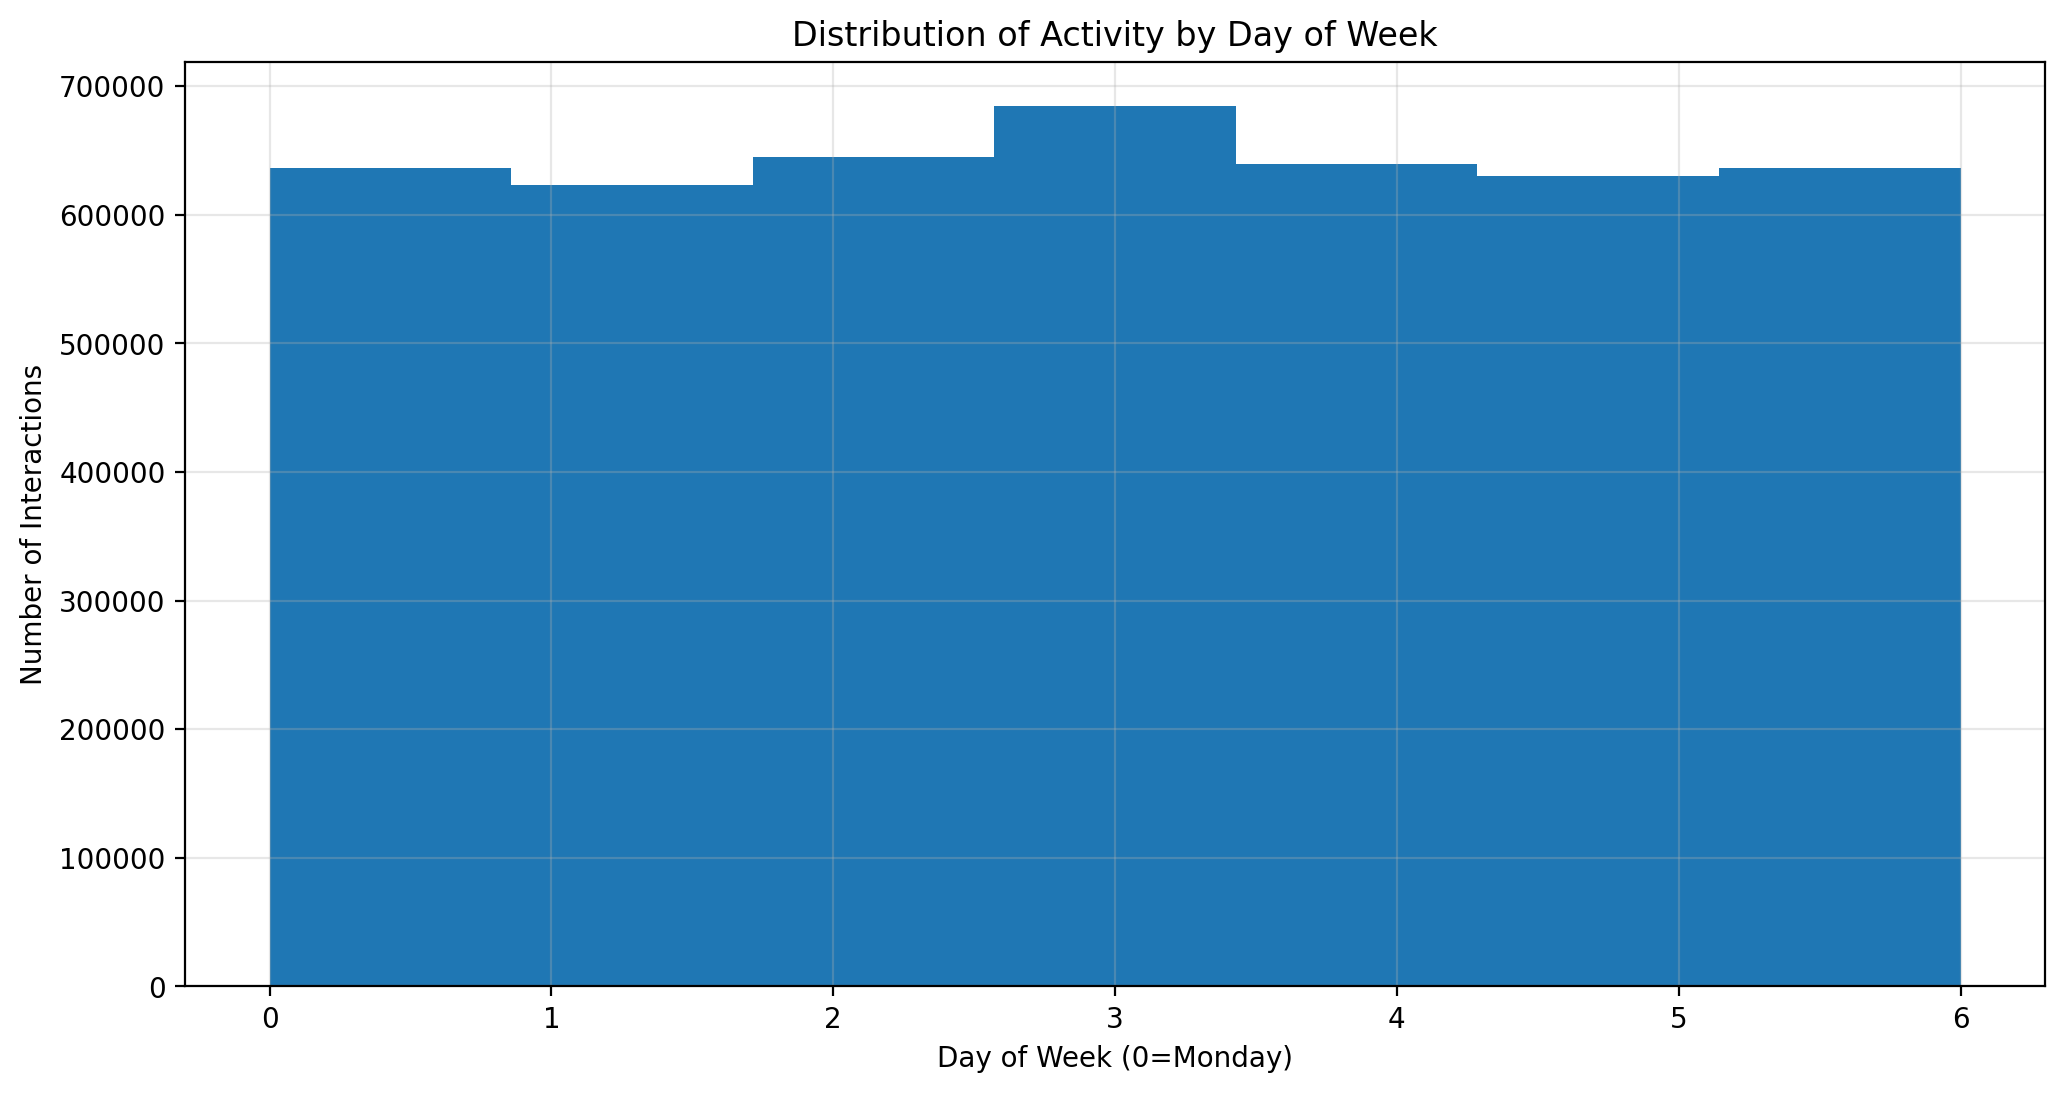

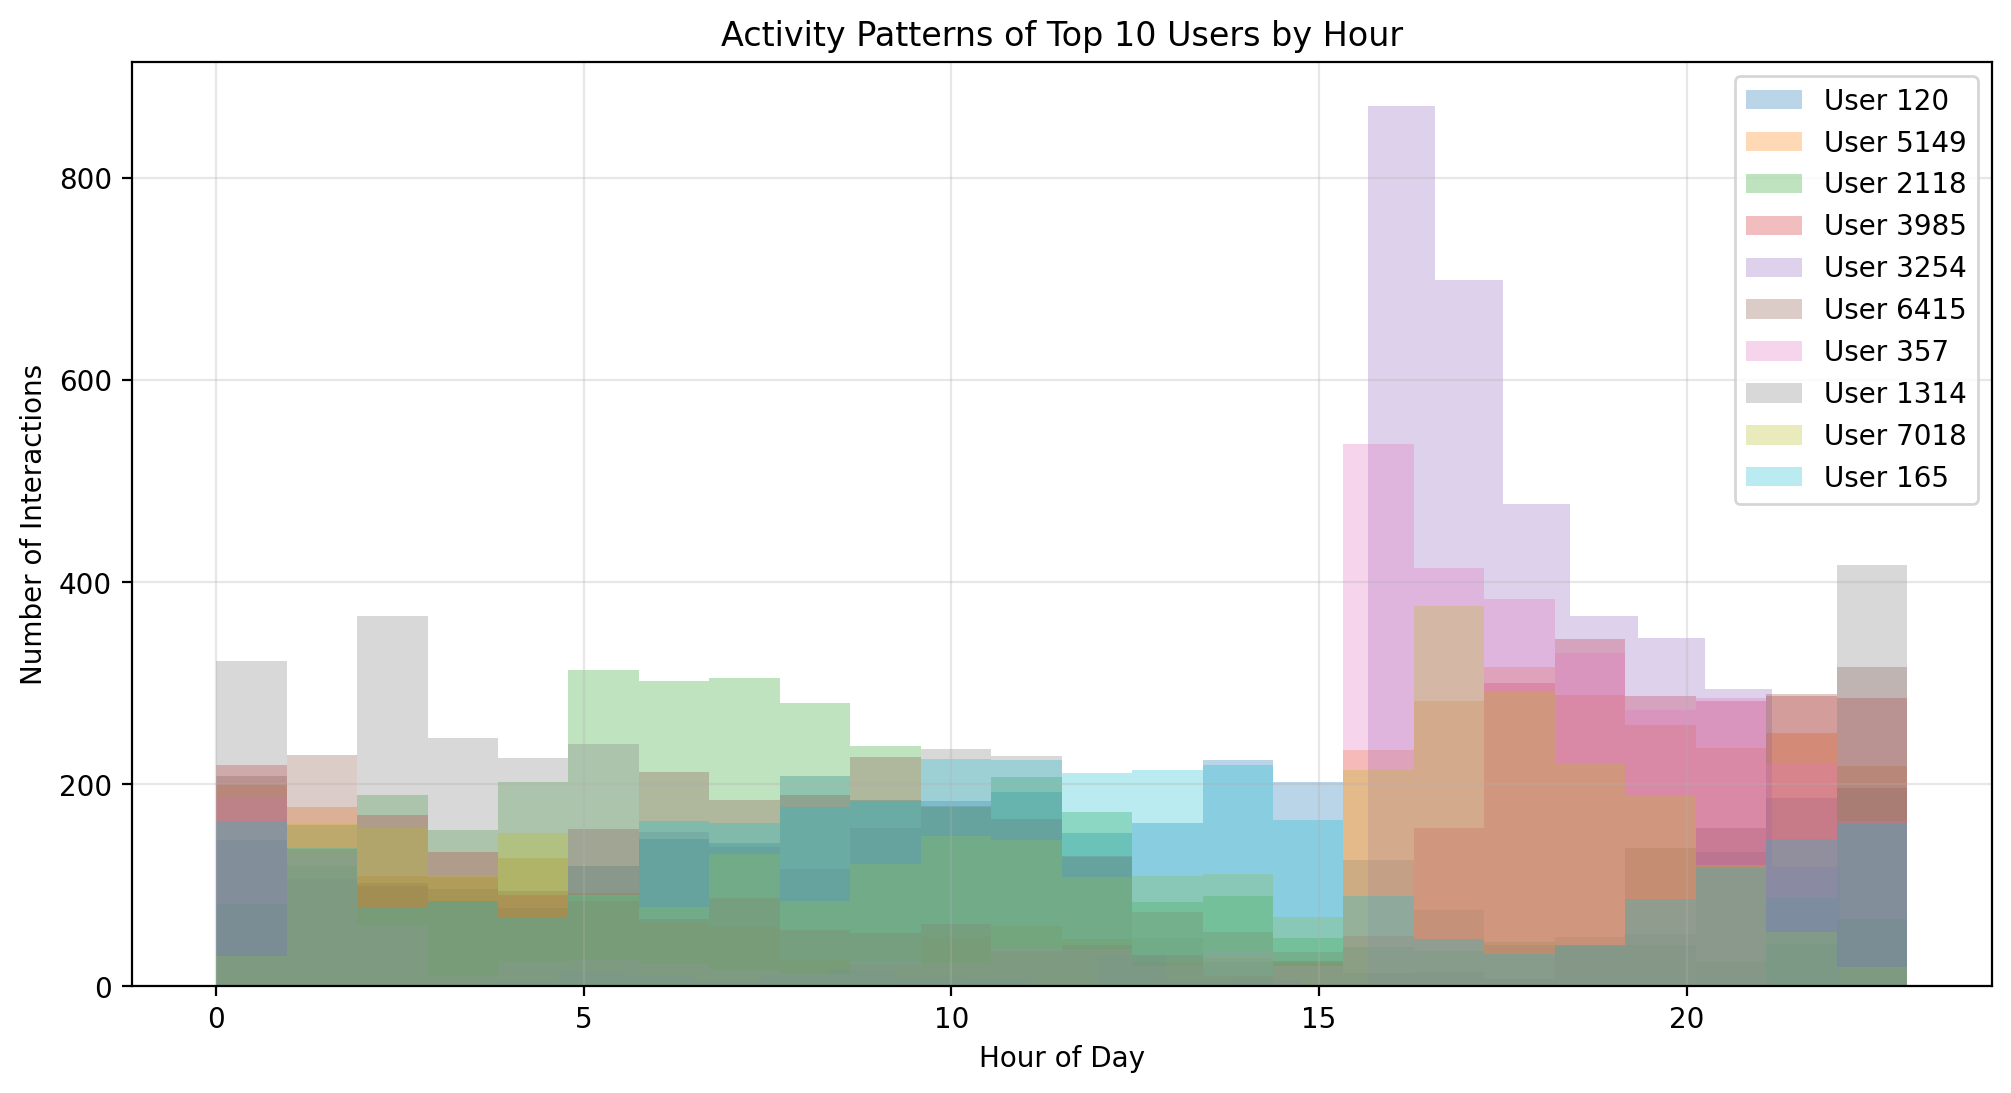


Peak Usage Hours:
Hour 0:00 - 258202 interactions
Hour 1:00 - 255557 interactions
Hour 2:00 - 255403 interactions

Peak Usage Days:
Thursday - 684255 interactions
Wednesday - 644928 interactions
Friday - 639221 interactions


In [ ]:
# Convert timestamp to datetime
interactions["timestamp"] = pd.to_datetime(
    interactions["timestamp"].fillna(0), unit="s"
)

interactions["hour"] = interactions["timestamp"].dt.hour
interactions["day"] = interactions["timestamp"].dt.dayofweek

# Plot activity over time
plt.figure(figsize=(12, 6))
plt.hist(interactions["hour"], bins=24)
plt.title("Distribution of Activity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Interactions")
plt.grid(True, alpha=0.3)
plt.show()

# Plot activity by day of week
plt.figure(figsize=(12, 6))
plt.hist(interactions["day"], bins=7)
plt.title("Distribution of Activity by Day of Week")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Number of Interactions")
plt.grid(True, alpha=0.3)
plt.show()

# Get top 10 most active users
top_users = interactions["user_id"].value_counts().head(10).index

# Plot activity patterns for top users
plt.figure(figsize=(12, 6))
for user in top_users:
    user_data = interactions[interactions["user_id"] == user]
    plt.hist(user_data["hour"], bins=24, alpha=0.3, label=f"User {user}")
plt.title("Activity Patterns of Top 10 Users by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Interactions")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find peak usage times
hourly_activity = interactions.groupby("hour").size()
peak_hours = hourly_activity.nlargest(3)

print("\nPeak Usage Hours:")
for hour, count in peak_hours.items():
    print(f"Hour {hour}:00 - {count} interactions")

daily_activity = interactions.groupby("day").size()
peak_days = daily_activity.nlargest(3)

print("\nPeak Usage Days:")
for day, count in peak_days.items():
    days = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    print(f"{days[int(day)]} - {count} interactions")

In [6]:
interactions["timestamp"]

0         2020-07-04 21:27:48.378000021
1         2020-07-04 21:28:00.056999922
2         2020-07-04 21:29:09.479000092
3         2020-07-04 21:30:43.285000086
4         2020-07-04 21:35:43.459000111
                       ...             
4676370   2020-09-01 12:06:35.983999968
4676371   2020-09-02 06:44:51.342000008
4676372   2020-09-03 00:45:01.473999977
4676373   2020-09-04 14:56:32.020999908
4676374   2020-09-04 16:32:09.154000044
Name: timestamp, Length: 4494578, dtype: datetime64[ns]

## Categories

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname="./SimHei.ttf")

def visual_continue(df, func=None):
    ax = sns.distplot(df)
    if func:
        func(ax)
    
    gca = plt.gca()
    fig_title = "Statistics of {}".format(df.name)
    gca.set_title(fig_title, fontsize=14)
    gca.set_ylabel("Density", fontsize=14)
    gca.set_xlabel(df.name, fontsize=14)
    
    plt.show()

In [5]:
categories_df = pd.read_csv("data/item_categories.csv")

In [6]:
categories_df = categories_df.dropna()
categories_df = categories_df.drop_duplicates()

count    12693.000000
mean        13.186796
std          8.050082
min          0.000000
25%          7.000000
50%         11.000000
75%         19.000000
max         30.000000
Name: feat, dtype: float64


/var/folders/9f/jfpypfpx4y3cgctjsdtf0qhh0000gn/T/ipykernel_80970/718493317.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df)


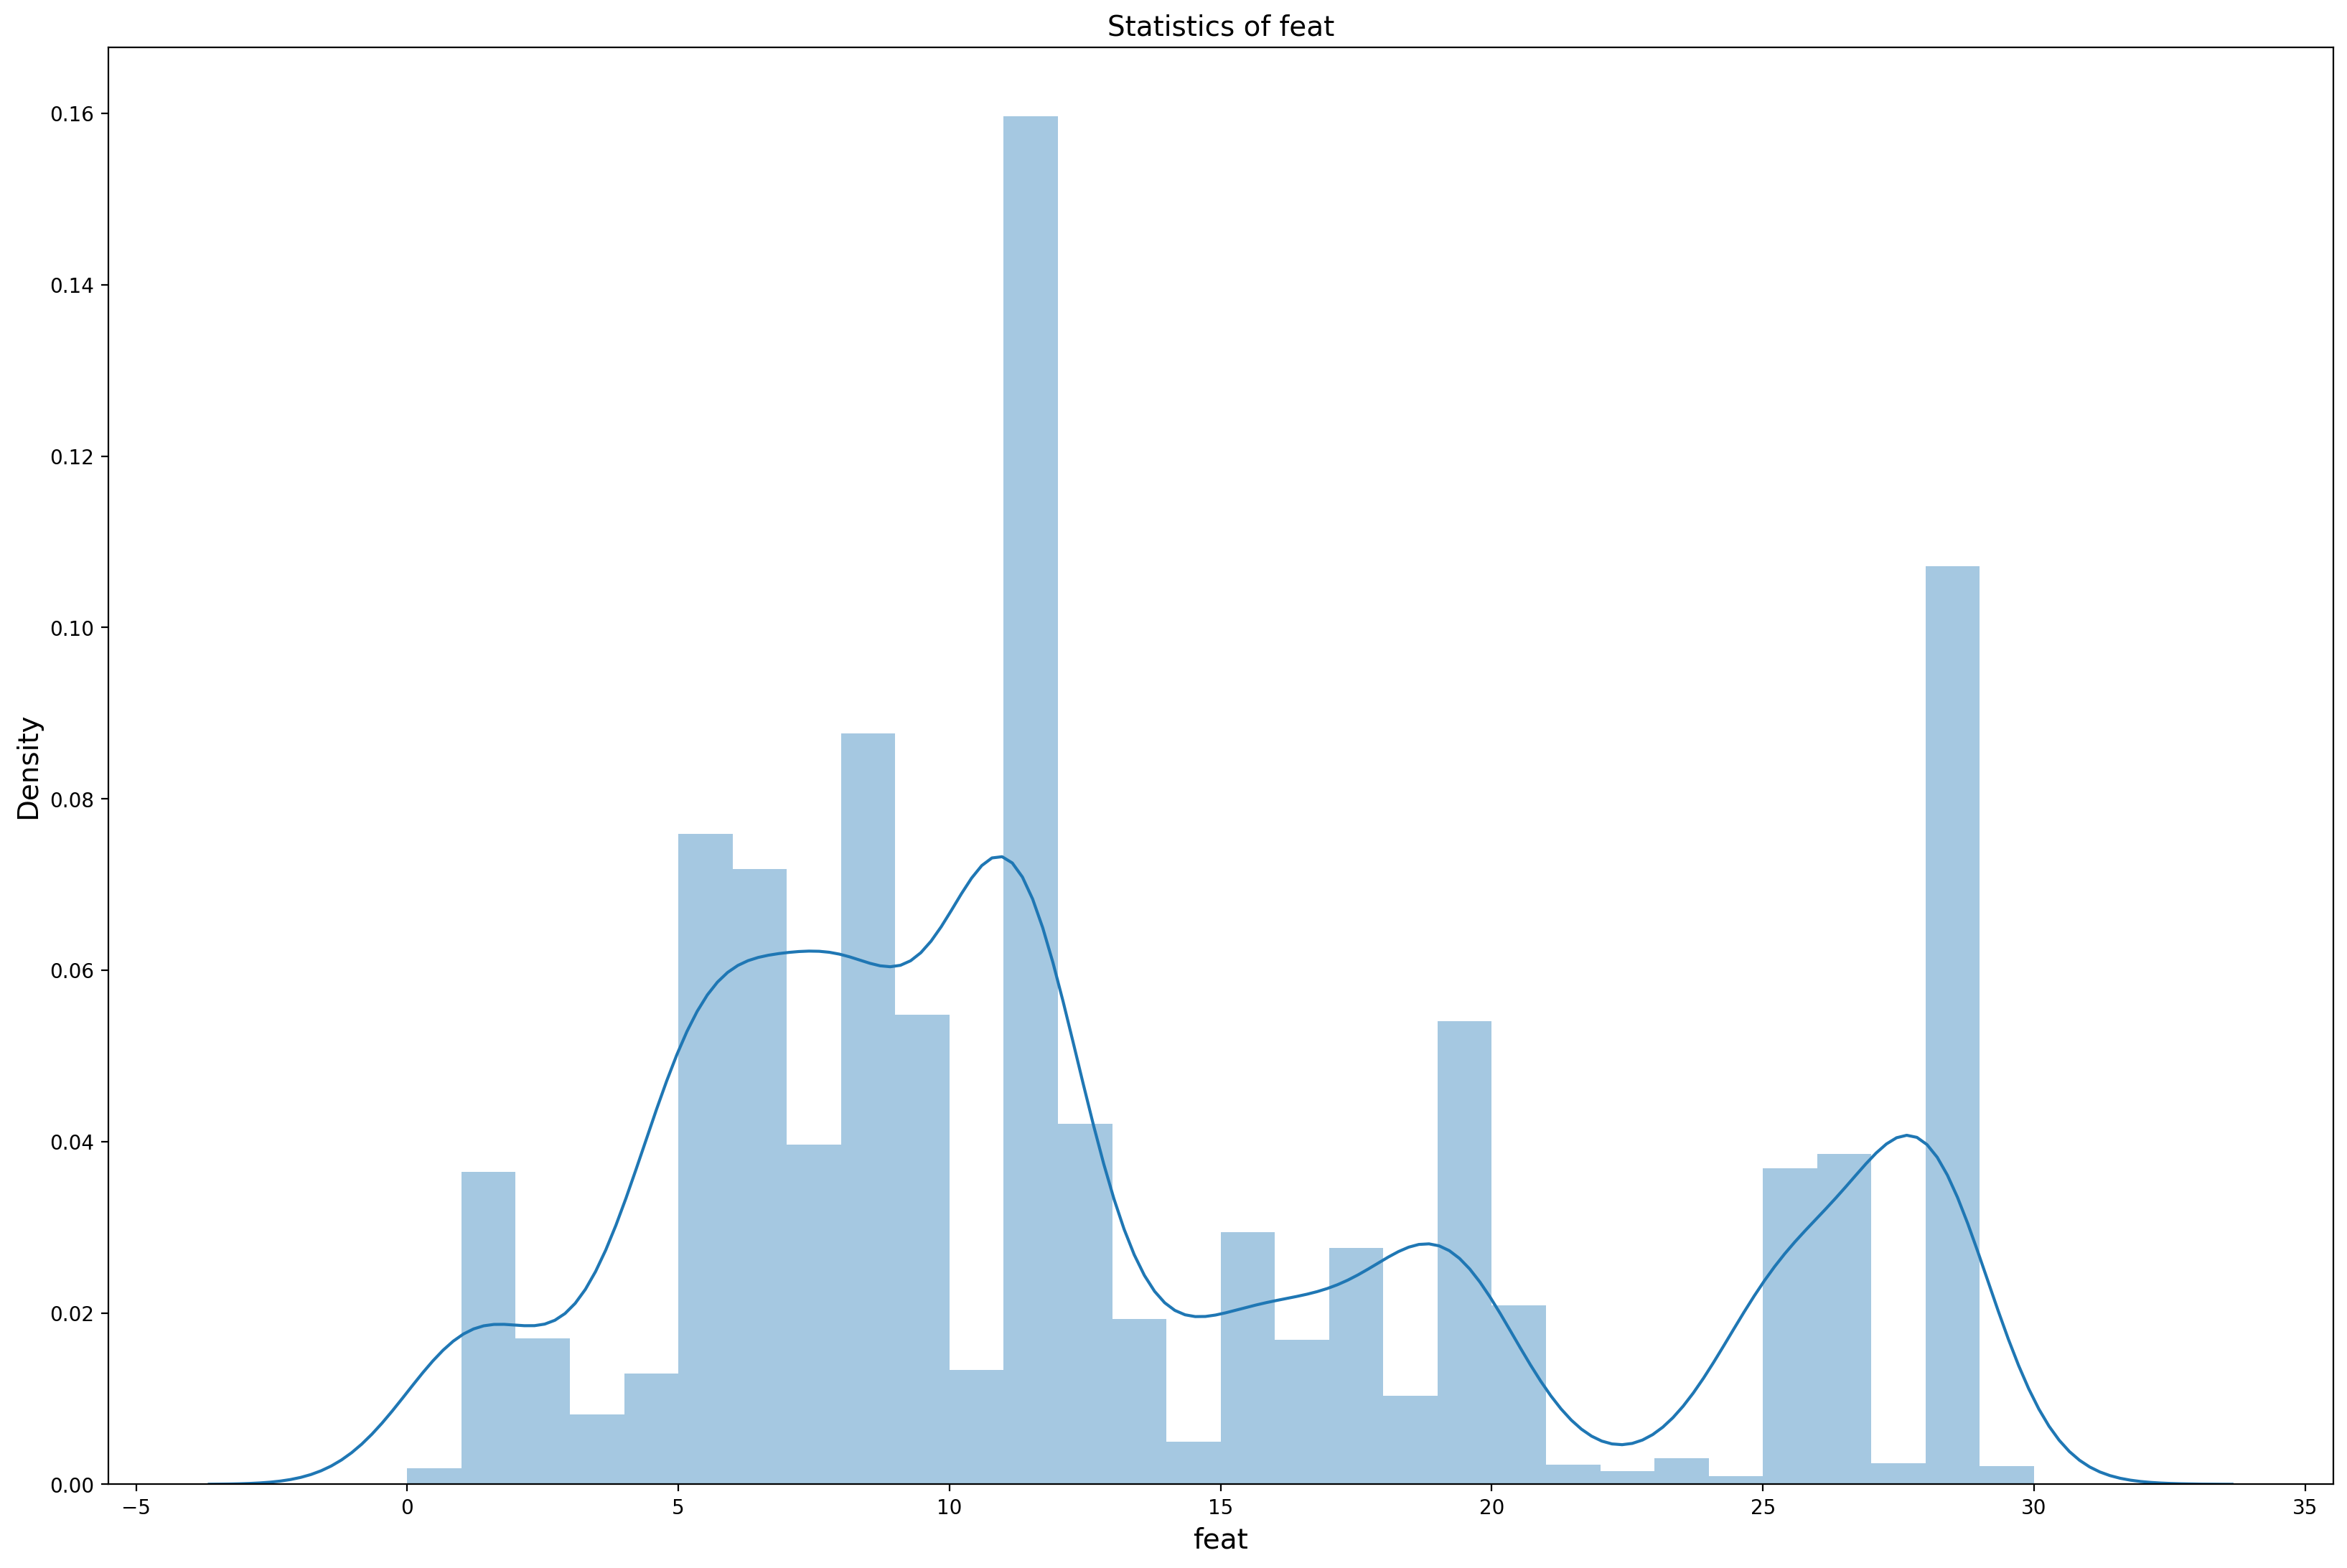

In [7]:
from ast import literal_eval

categories_df['feat'] = categories_df['feat'].apply(literal_eval)
flattened_feats = categories_df['feat'].explode()
flattened_feats = pd.to_numeric(flattened_feats)
print(flattened_feats.describe())
visual_continue(flattened_feats)

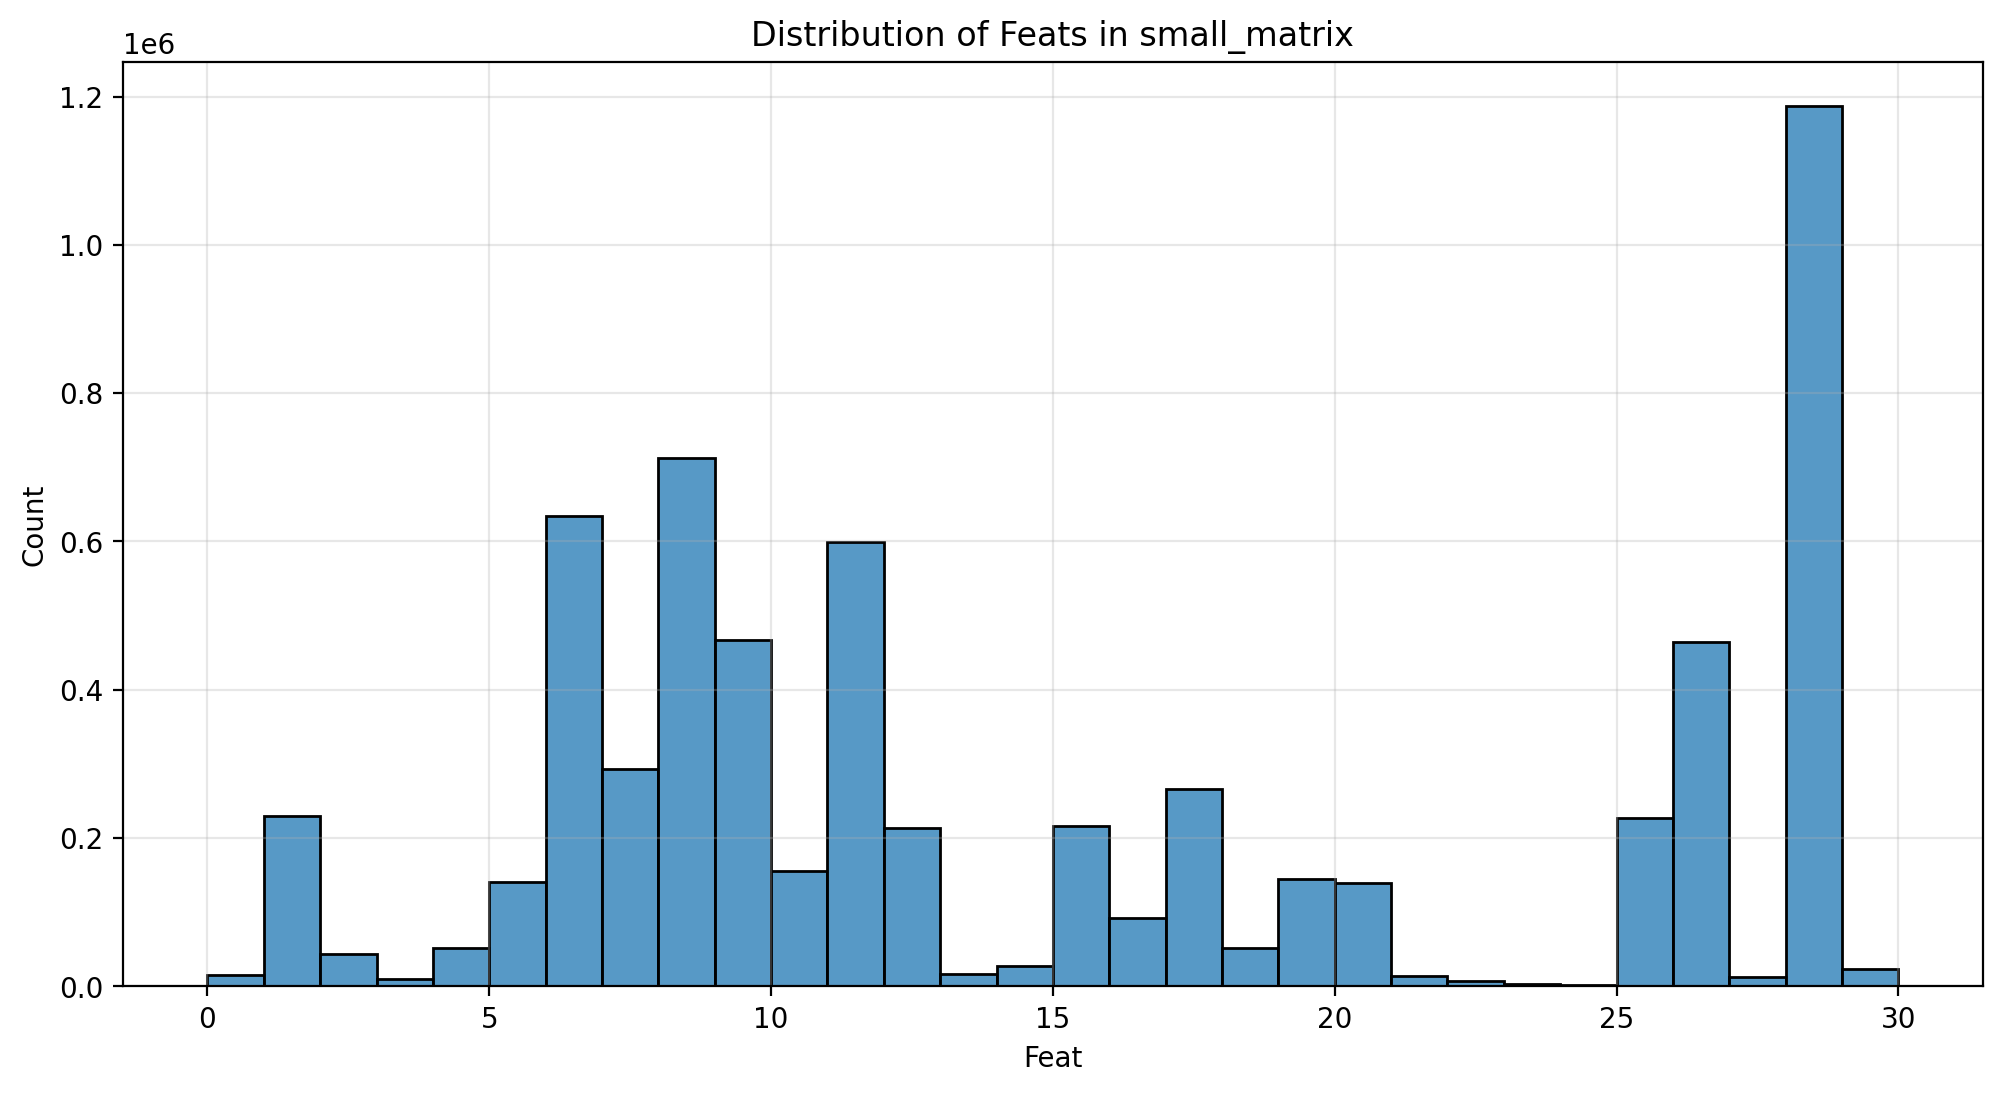

In [8]:
merged_df = interactions.merge(categories_df, on="video_id", how="inner")

merged_feats = merged_df["feat"].explode()
merged_feats = pd.to_numeric(merged_feats)


plt.figure(figsize=(12, 6))
sns.histplot(merged_feats, kde=False, bins=30)
plt.title("Distribution of Feats in small_matrix")
plt.xlabel("Feat")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
big_interactions = pd.read_csv("data/big_matrix.csv")
big_interactions = big_interactions.dropna()
big_interactions = big_interactions.drop_duplicates()

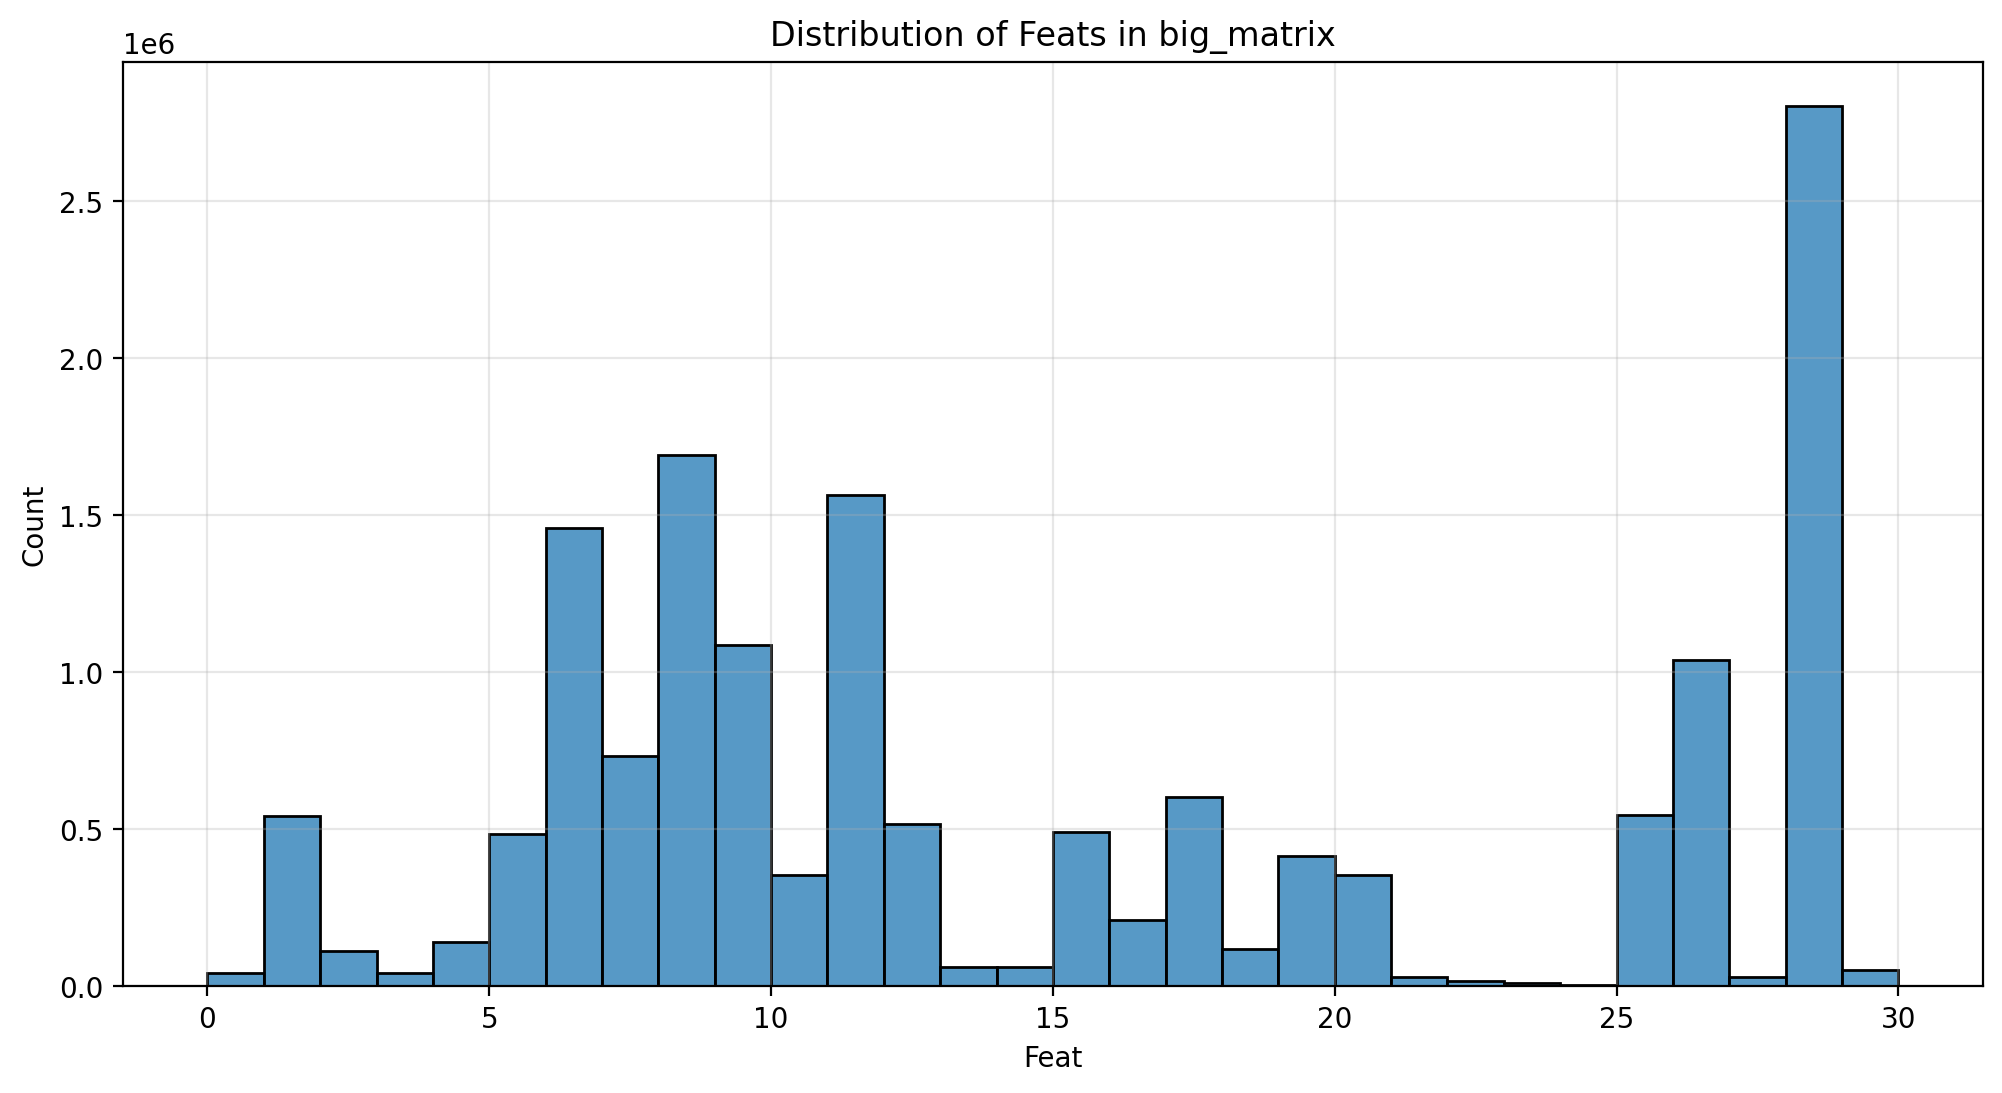

In [11]:
merged_df = big_interactions.merge(categories_df, on="video_id", how="inner")

merged_feats = merged_df["feat"].explode()
merged_feats = pd.to_numeric(merged_feats)


plt.figure(figsize=(12, 6))
sns.histplot(merged_feats, kde=False, bins=30)
plt.title("Distribution of Feats in big_matrix")
plt.xlabel("Feat")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

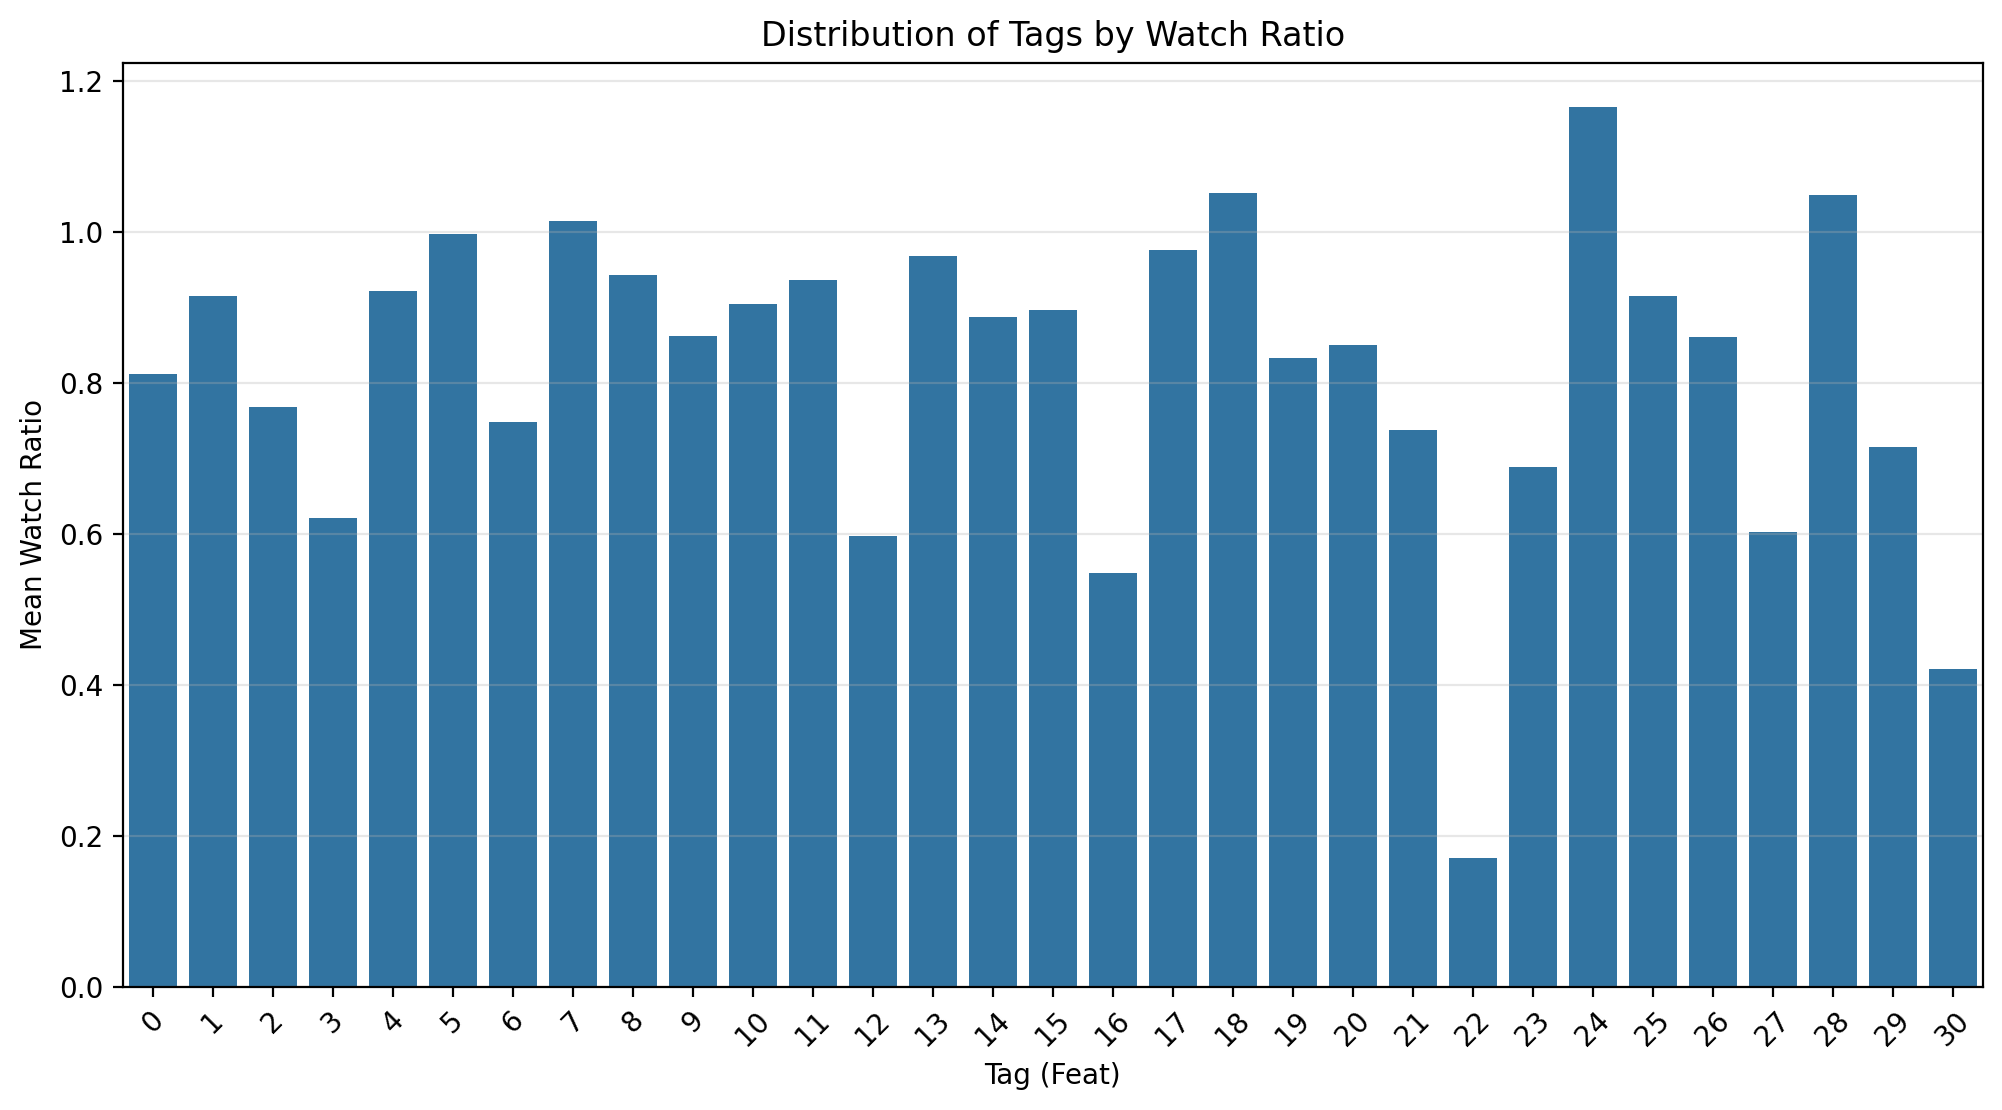

In [ ]:
tags_watch_ratio = merged_df.explode("feat")[["feat", "watch_ratio"]]


tags_watch_ratio["feat"] = pd.to_numeric(tags_watch_ratio["feat"])

tags_watch_ratio_mean = tags_watch_ratio.groupby("feat")["watch_ratio"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=tags_watch_ratio_mean.index, y=tags_watch_ratio_mean.values)
plt.title("Distribution of Tags by Watch Ratio")
plt.xlabel("Tag (Feat)")
plt.ylabel("Mean Watch Ratio")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.show()

In [10]:
tags_watch_ratio_mean

feat
24    1.166563
18    1.052455
28    1.049183
7     1.014534
5     0.997259
17    0.976443
13    0.968255
8     0.942728
11    0.937281
4     0.922393
1     0.915766
25    0.915235
10    0.905335
15    0.896323
14    0.888018
9     0.861838
26    0.860971
20    0.850292
19    0.833509
0     0.811466
2     0.767788
6     0.748236
21    0.737661
29    0.715389
23    0.688930
3     0.621218
27    0.602348
12    0.596647
16    0.547848
30    0.421101
22    0.169778
Name: watch_ratio, dtype: float64

The feats in the small matrix are very unevenly distributed, with some being overrepresented, such as feat 28, which is by far the most prevalent.\
Given that the tags are therefore not very diverse, I have decided not to consider tag diversity in my model.\
However, I have decided to include feats in my model to recommend the feats that the user prefers.

## User Features

In [21]:
user_features_df = pd.read_csv("data/user_features.csv")

In [22]:
user_features_df = user_features_df.dropna()
user_features_df = user_features_df.drop_duplicates()

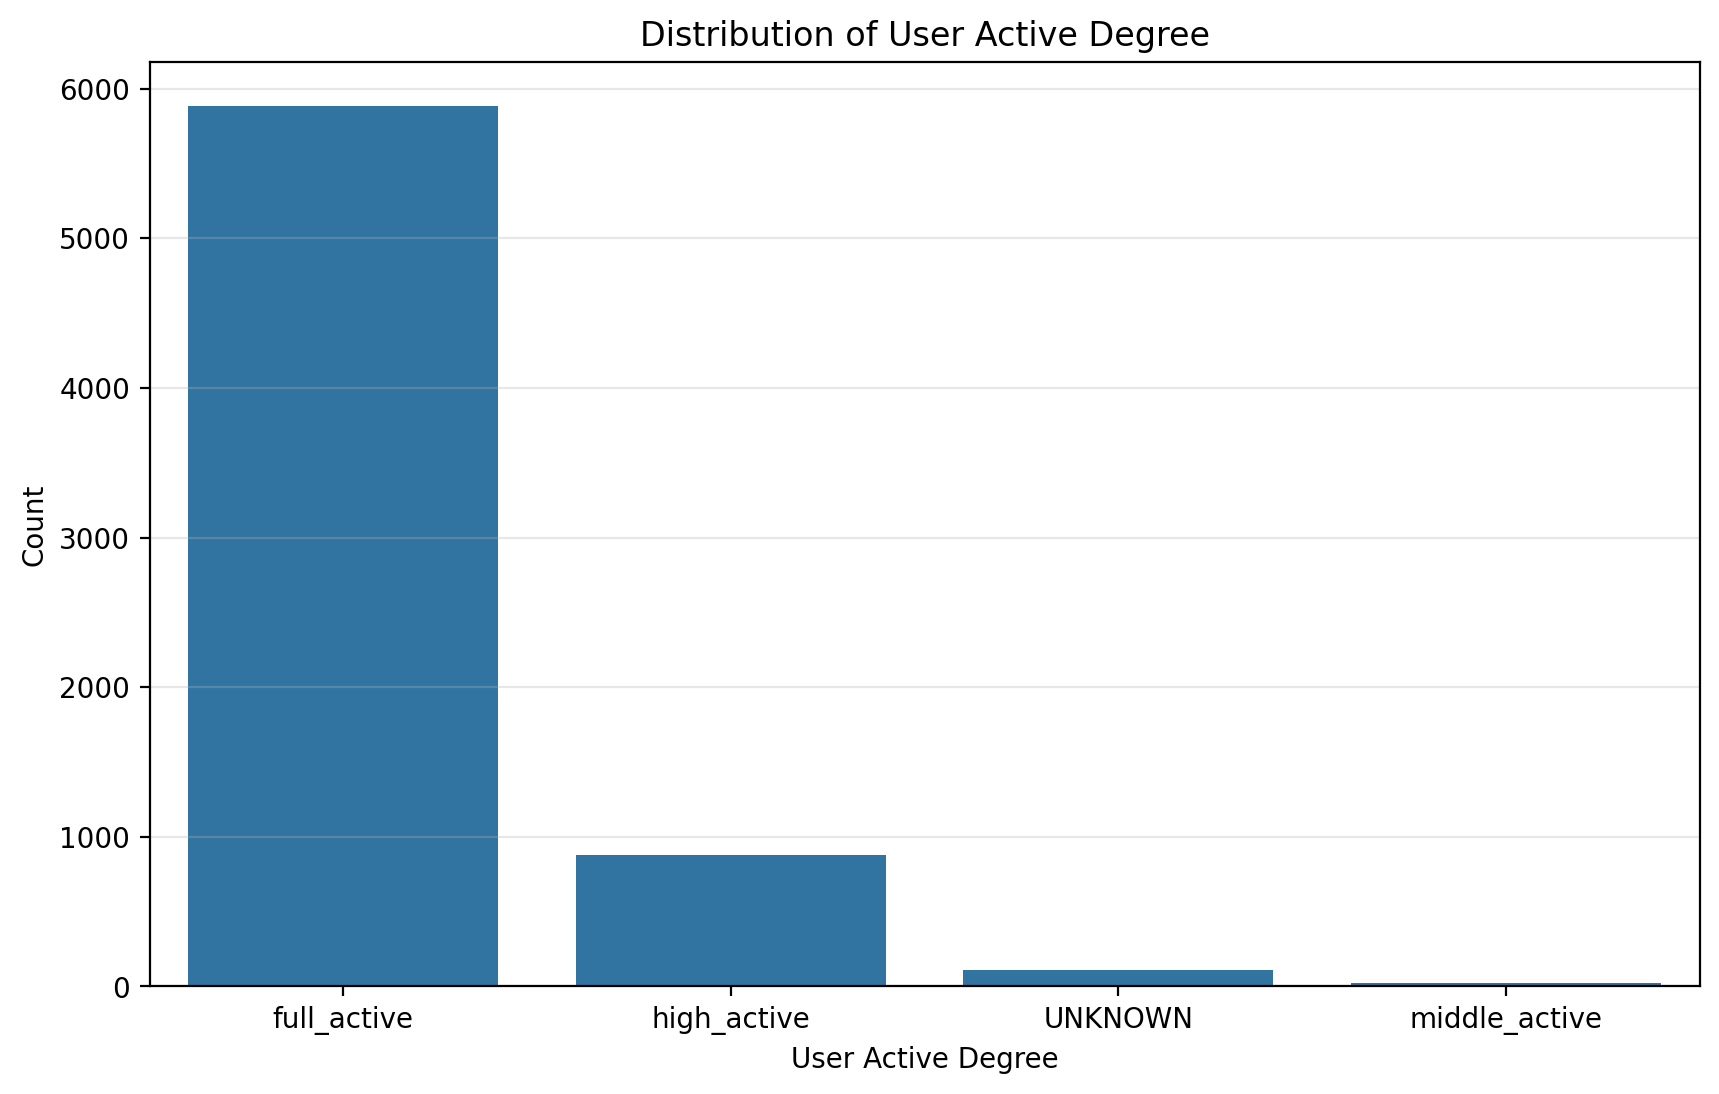

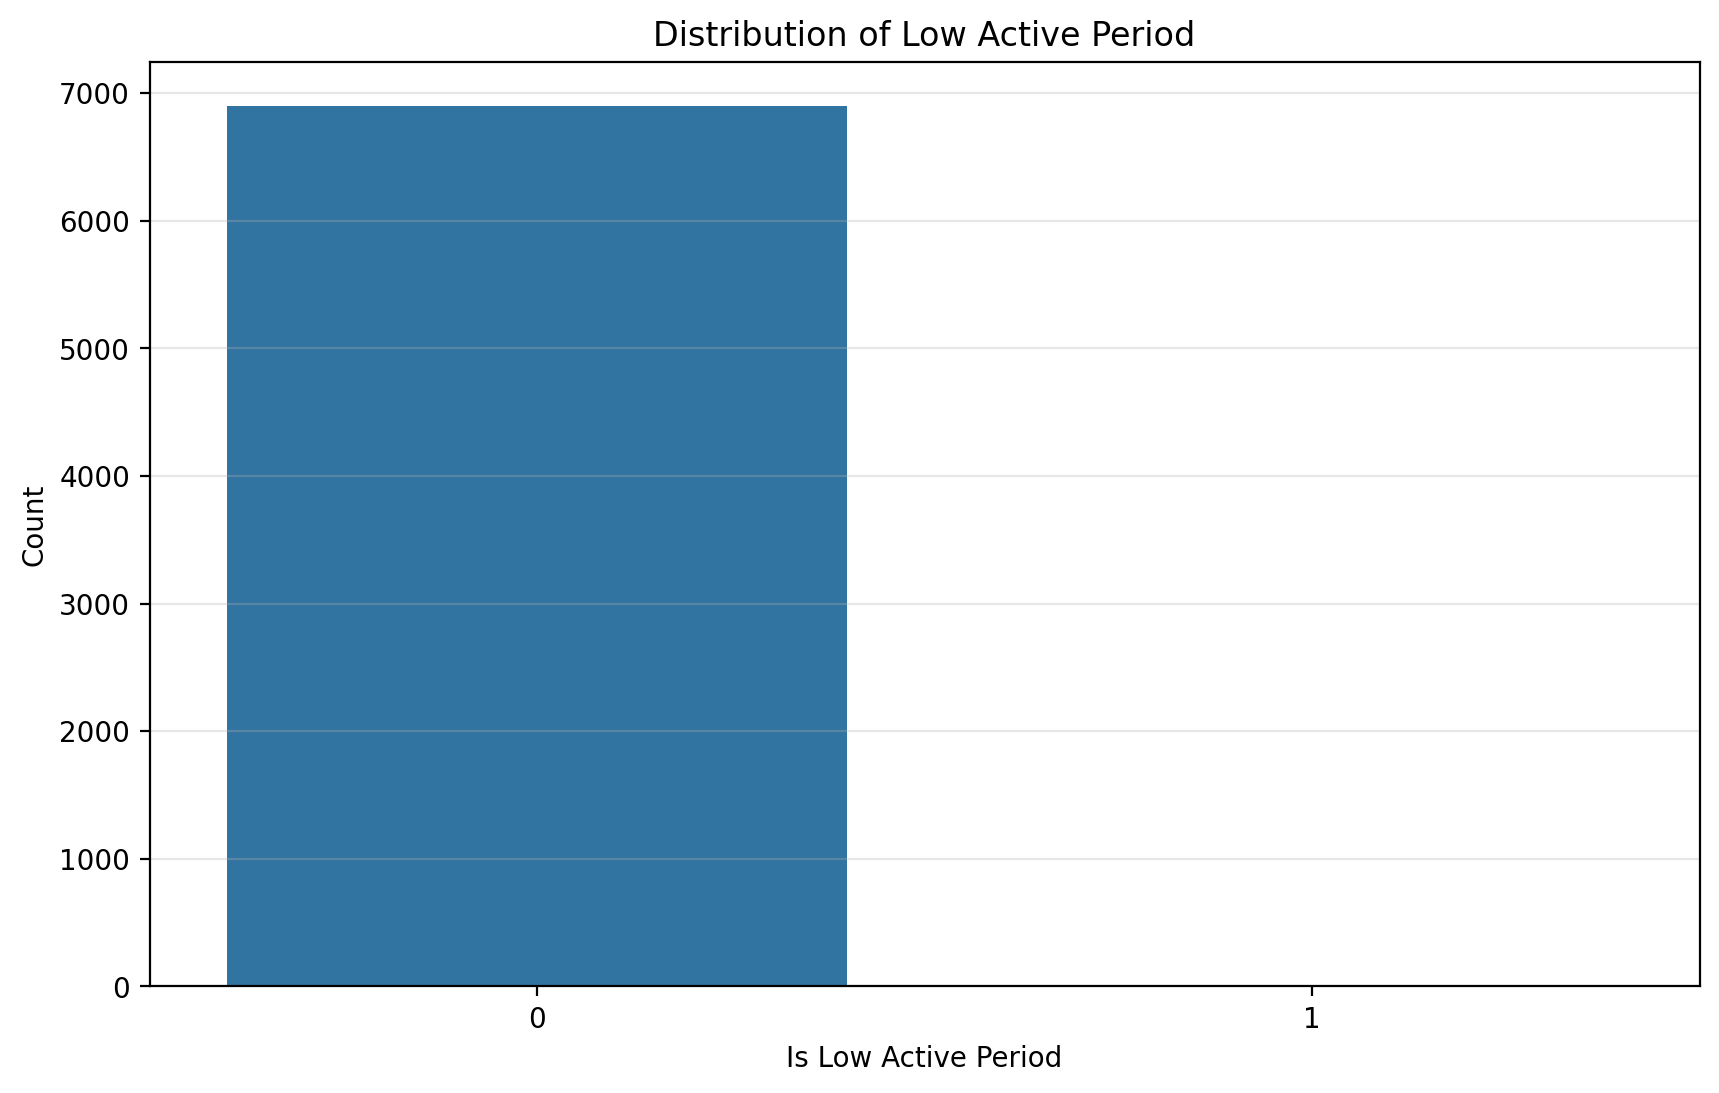

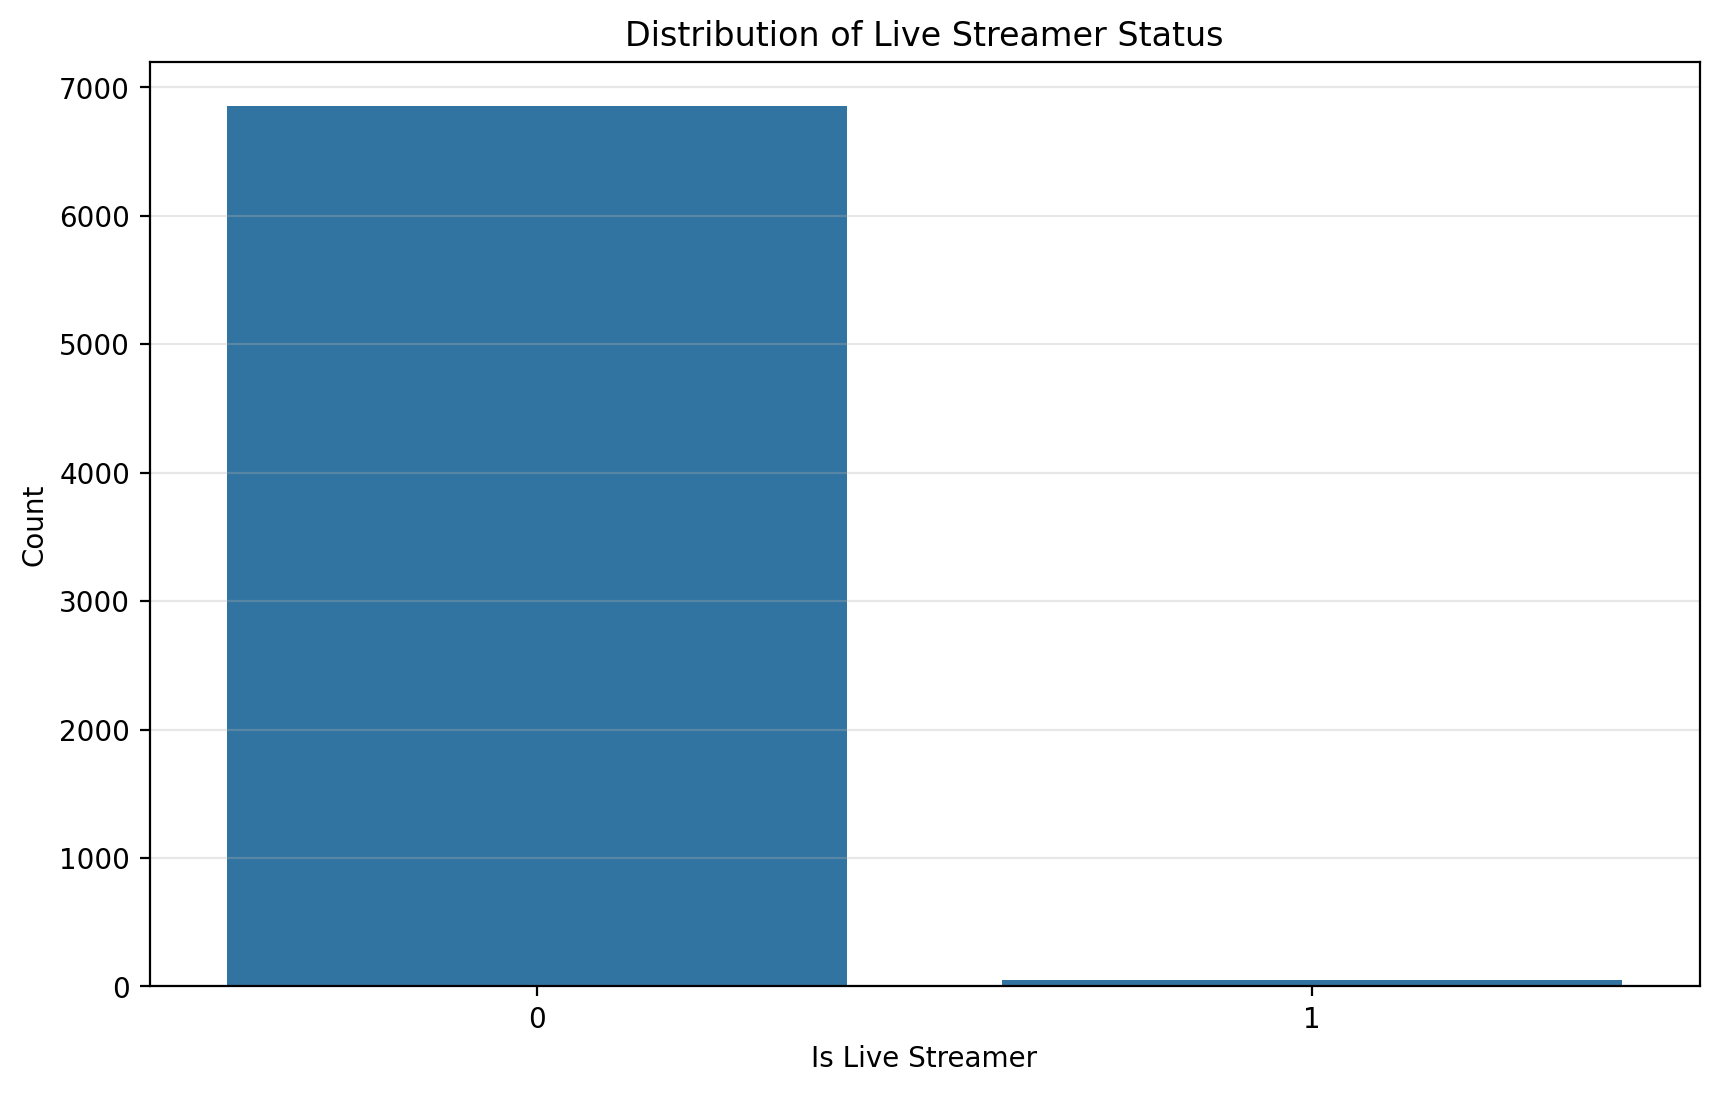

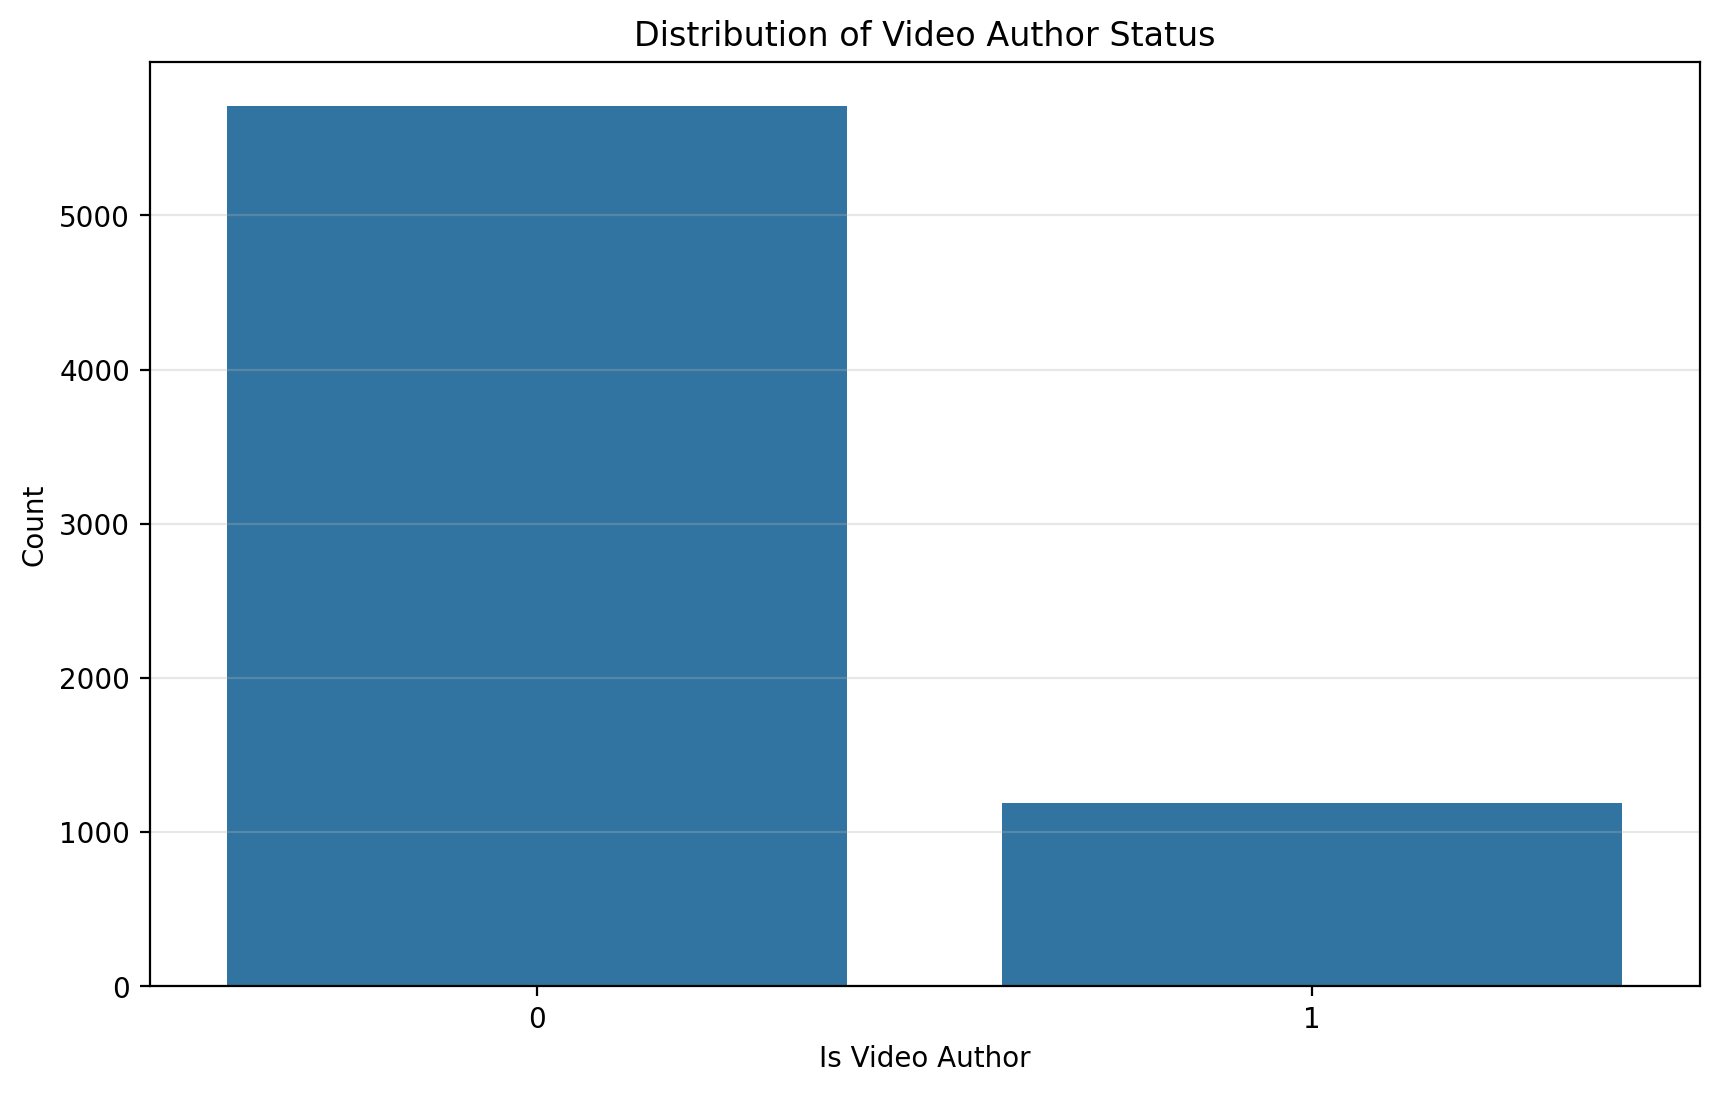

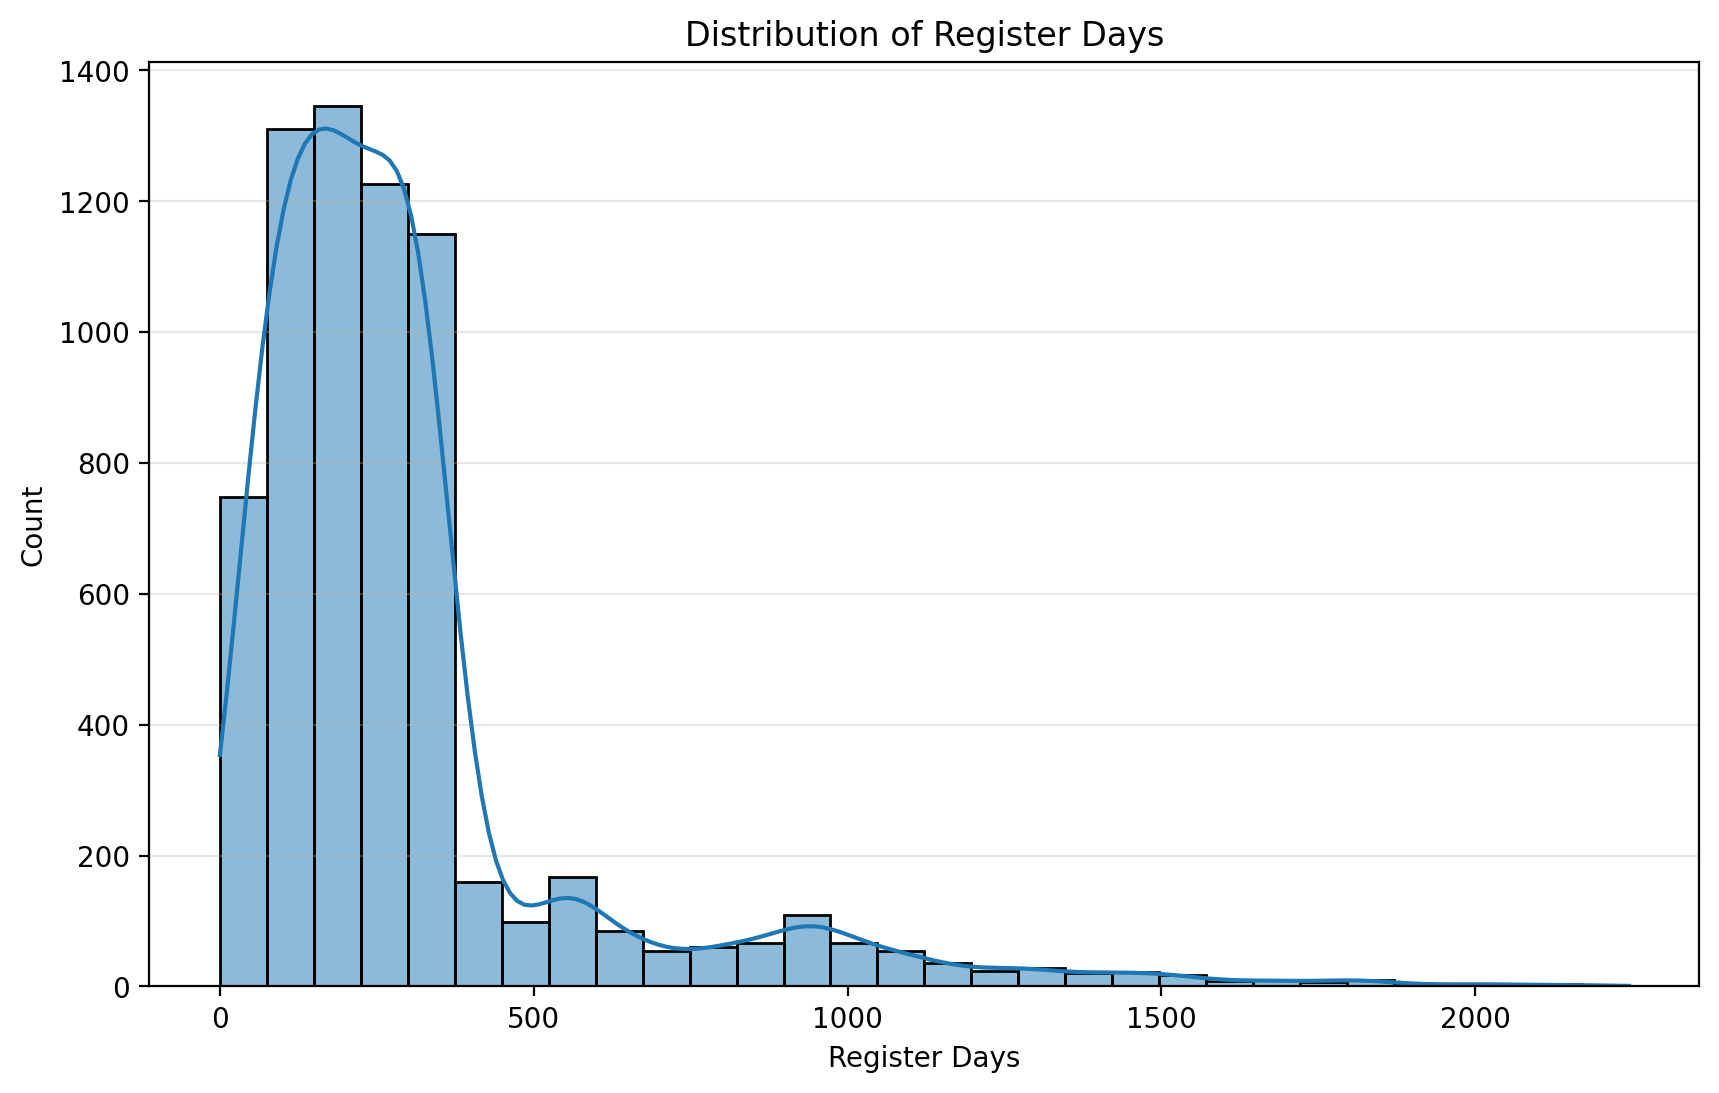

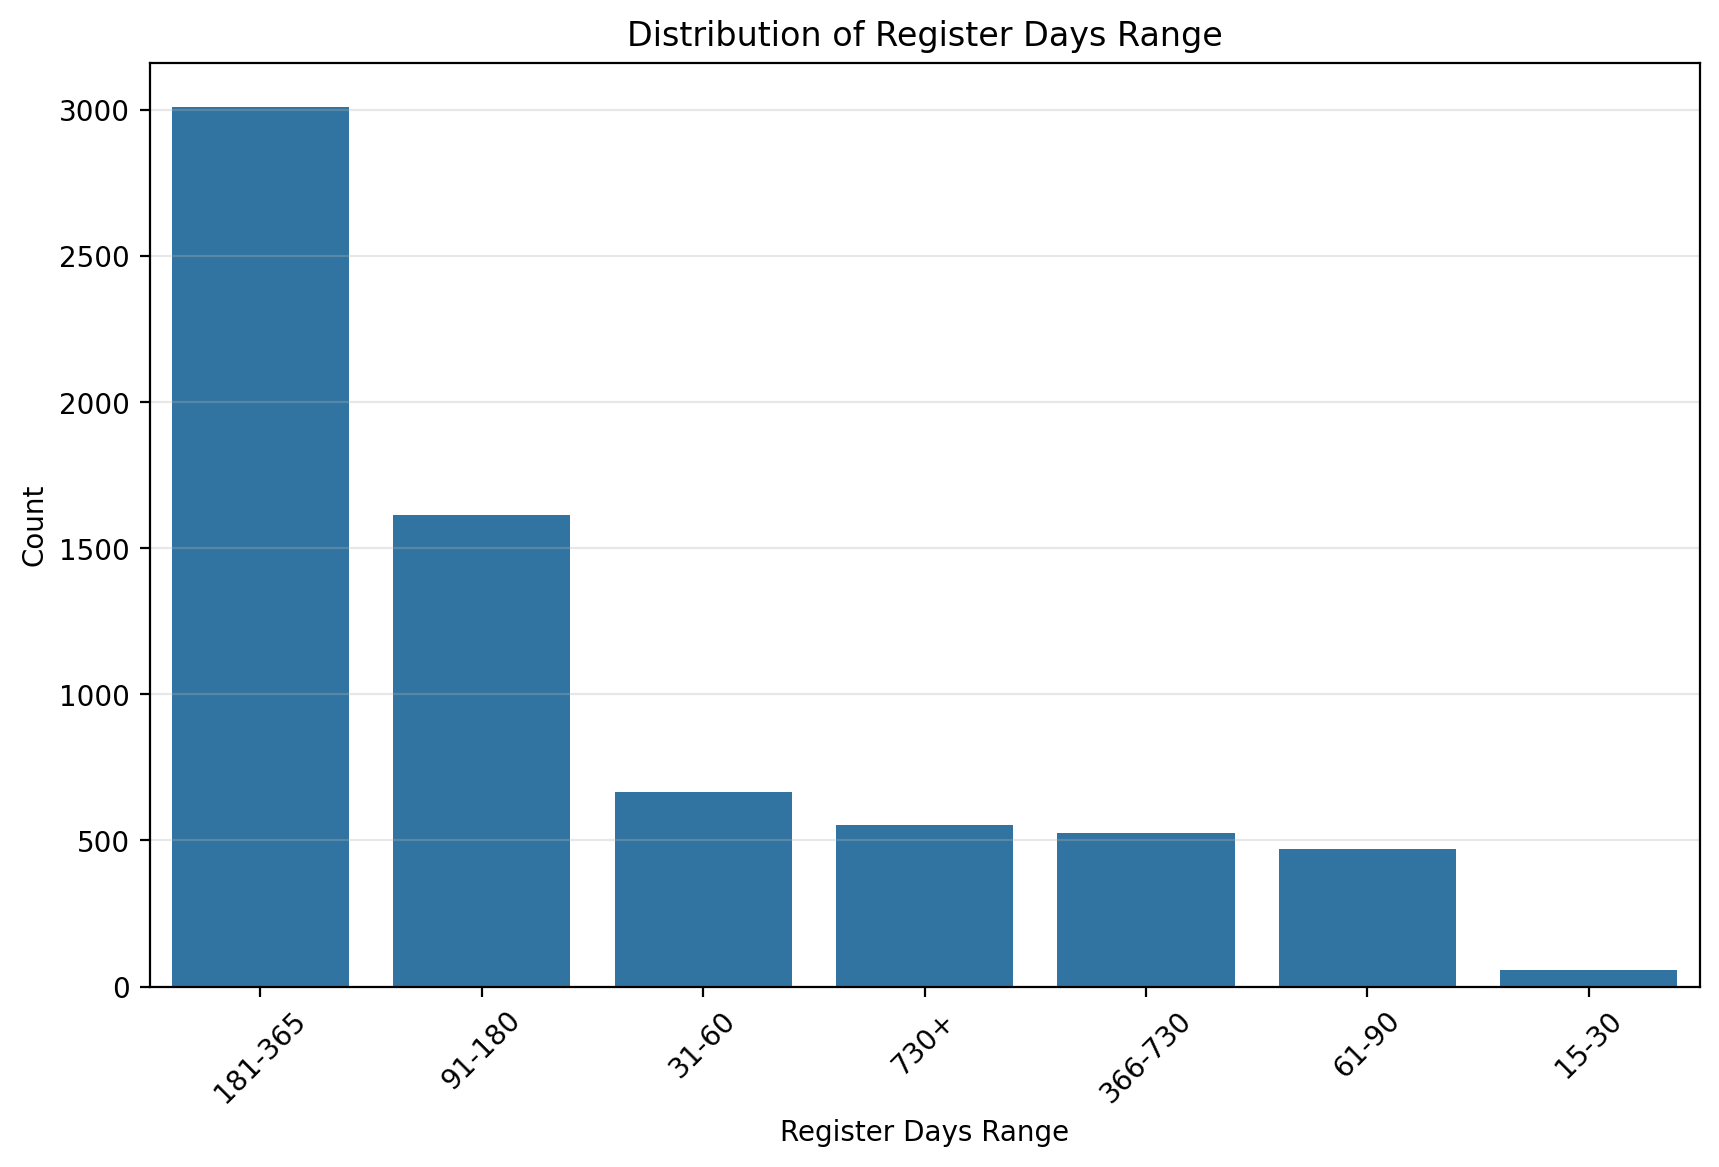

In [ ]:
# 'user_active_degree'
plt.figure(figsize=(10, 6))
sns.countplot(data=user_features_df, x='user_active_degree', order=user_features_df['user_active_degree'].value_counts().index)
plt.title("Distribution of User Active Degree")
plt.xlabel("User Active Degree")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 'is_lowactive_period'
plt.figure(figsize=(10, 6))
sns.countplot(data=user_features_df, x='is_lowactive_period')
plt.title("Distribution of Low Active Period")
plt.xlabel("Is Low Active Period")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 'is_live_streamer'
plt.figure(figsize=(10, 6))
sns.countplot(data=user_features_df, x='is_live_streamer')
plt.title("Distribution of Live Streamer Status")
plt.xlabel("Is Live Streamer")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 'is_video_author'
plt.figure(figsize=(10, 6))
sns.countplot(data=user_features_df, x='is_video_author')
plt.title("Distribution of Video Author Status")
plt.xlabel("Is Video Author")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 'register_days'
plt.figure(figsize=(10, 6))
sns.histplot(data=user_features_df, x='register_days', bins=30, kde=True)
plt.title("Distribution of Register Days")
plt.xlabel("Register Days")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 'register_days_range'
plt.figure(figsize=(10, 6))
sns.countplot(data=user_features_df, x='register_days_range', order=user_features_df['register_days_range'].value_counts().index)
plt.title("Distribution of Register Days Range")
plt.xlabel("Register Days Range")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.show()

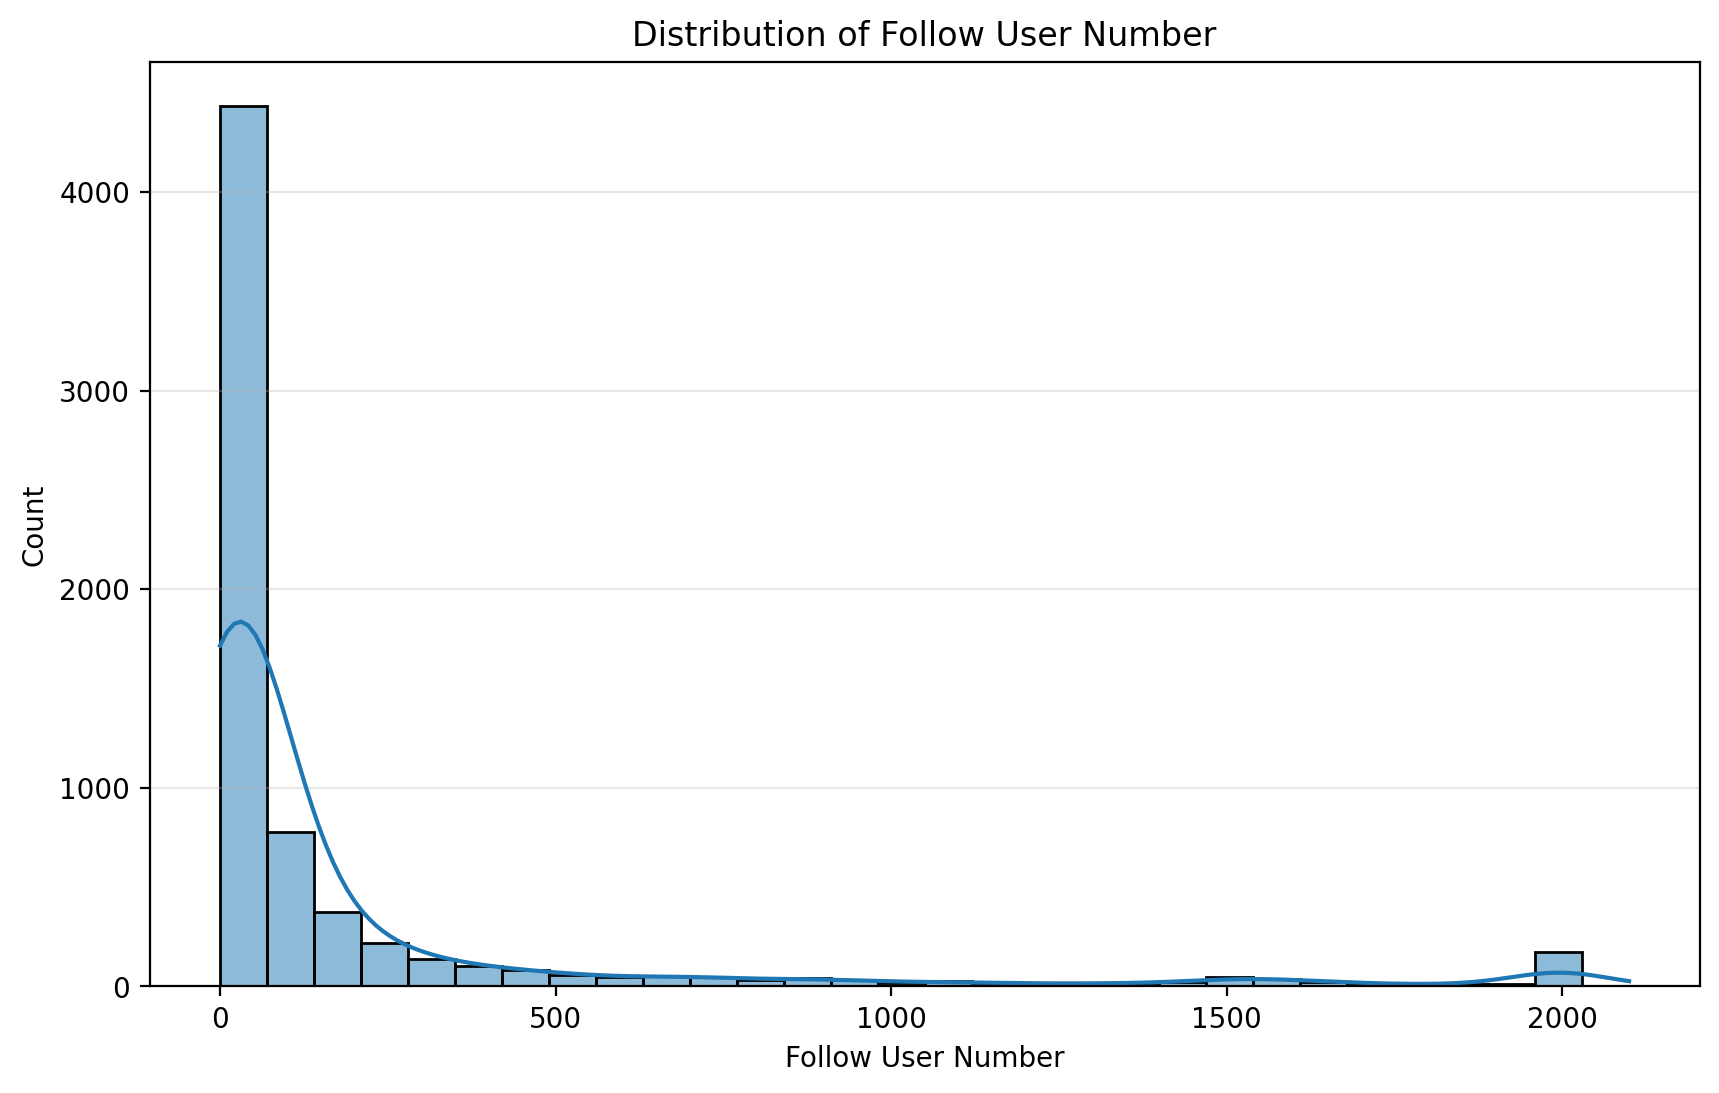

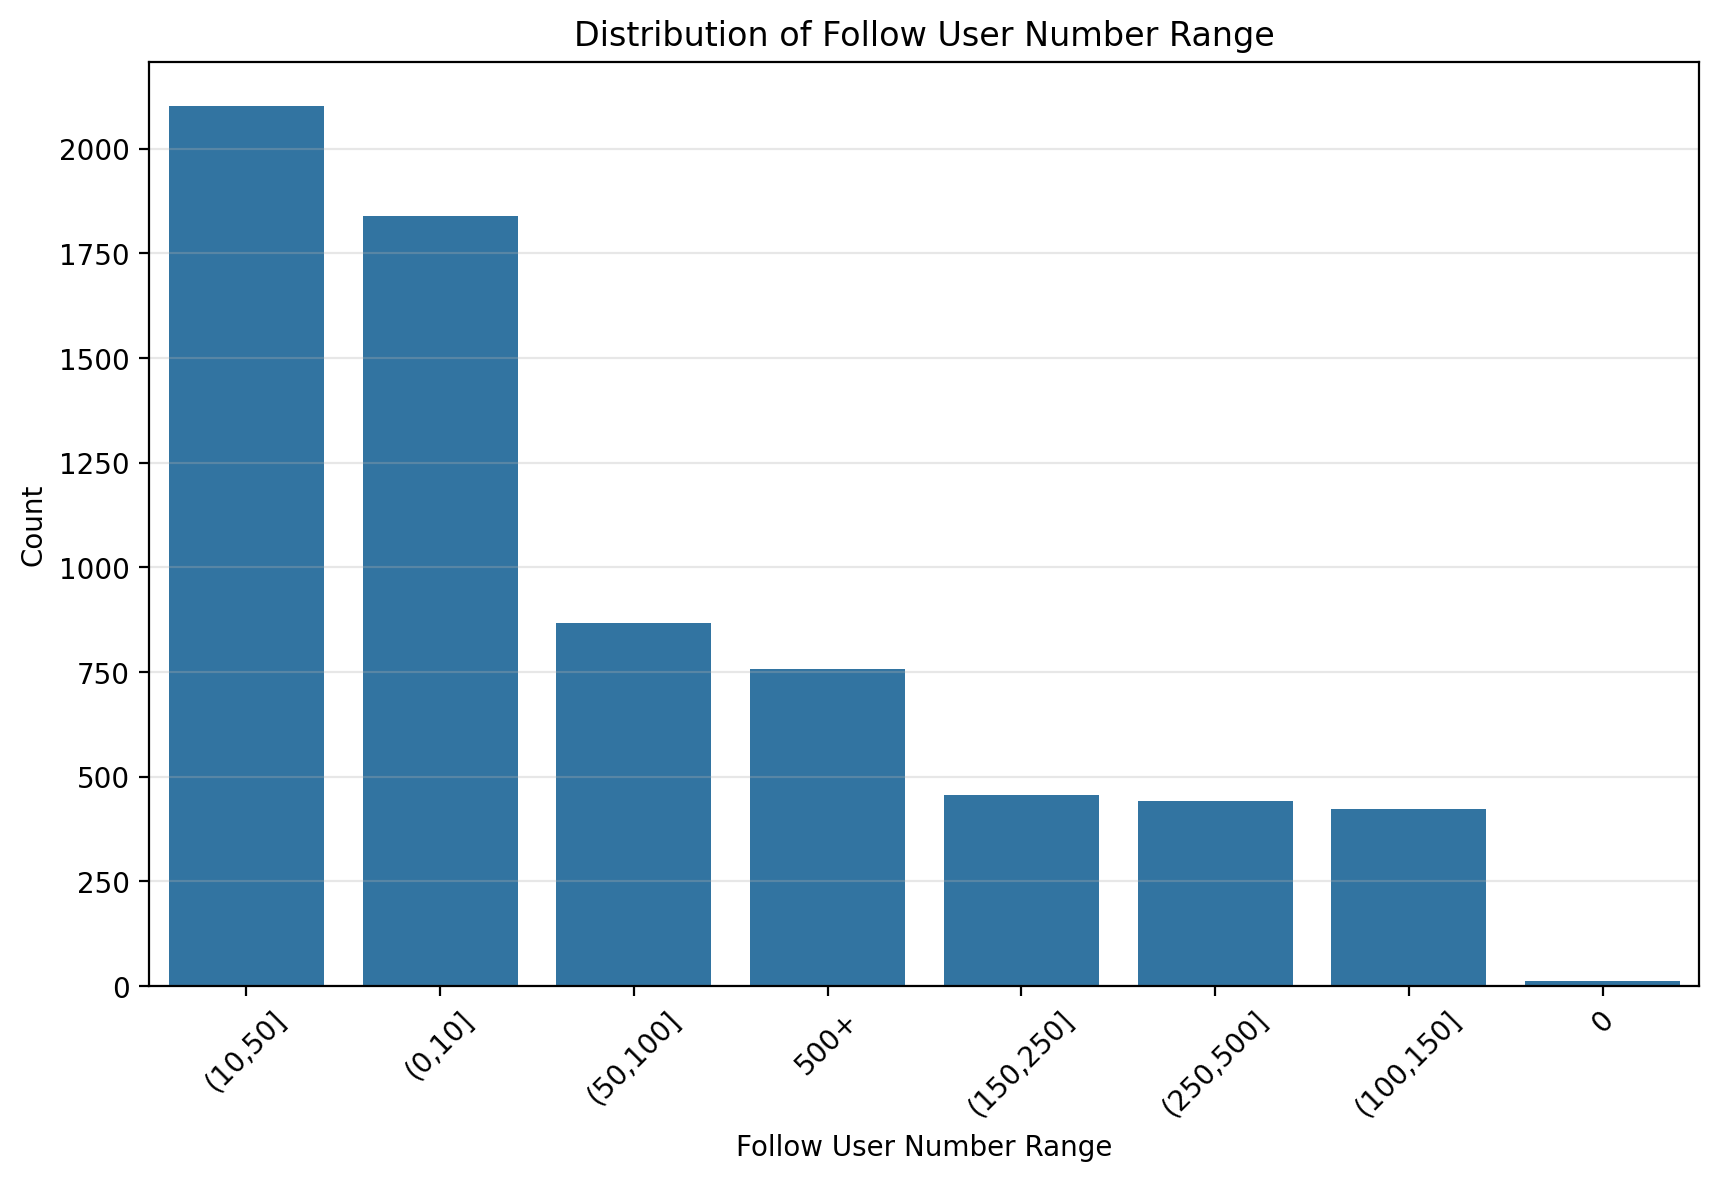

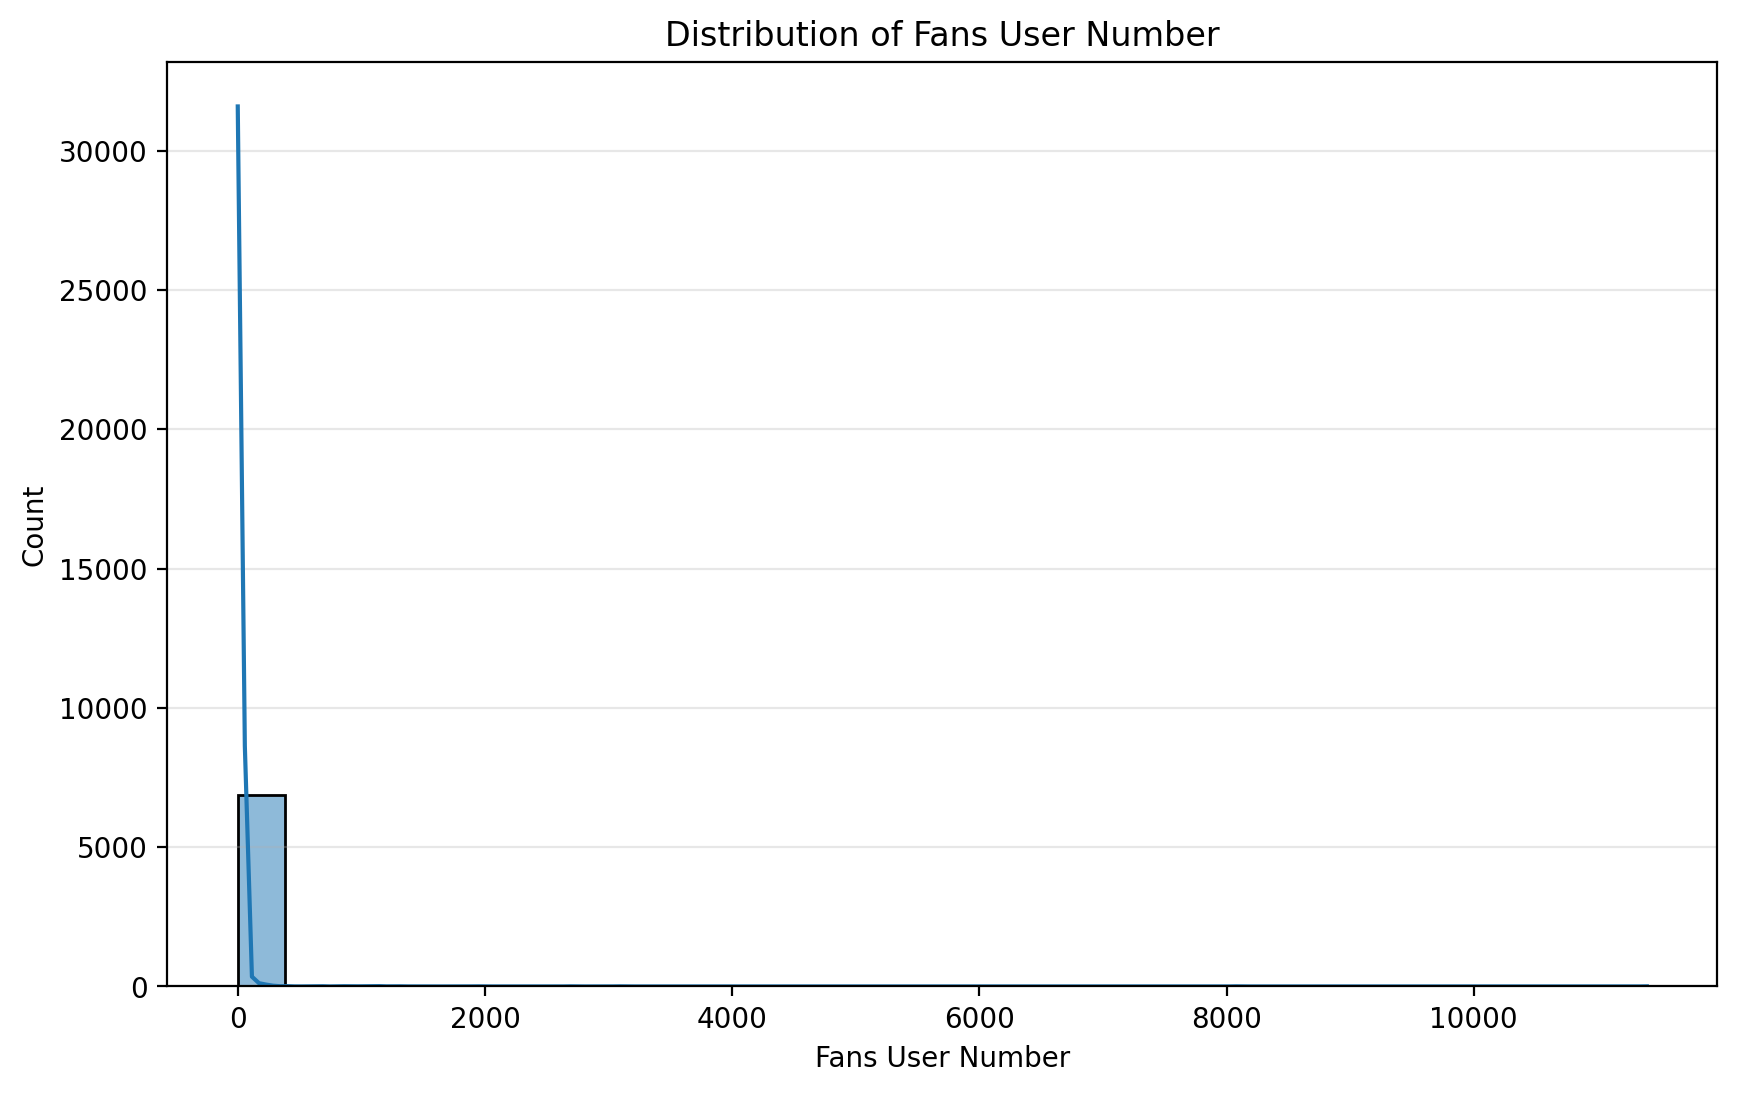

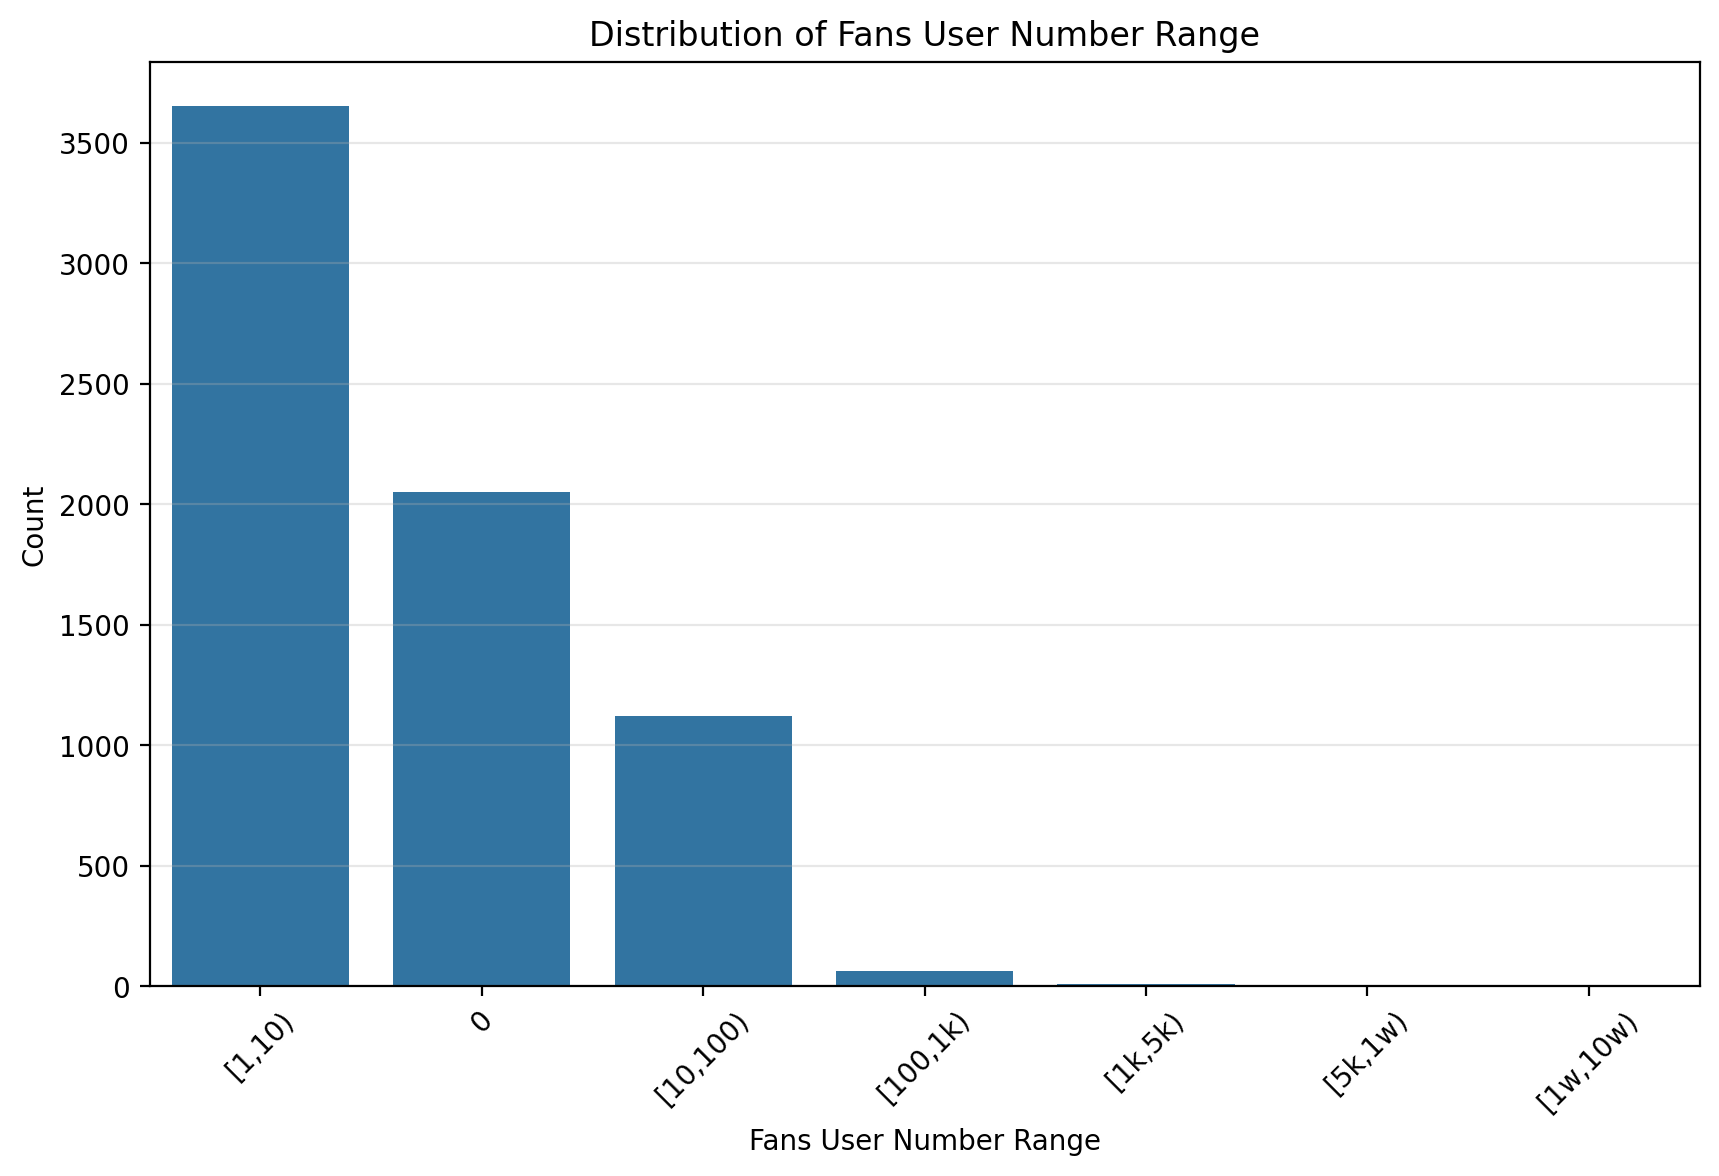

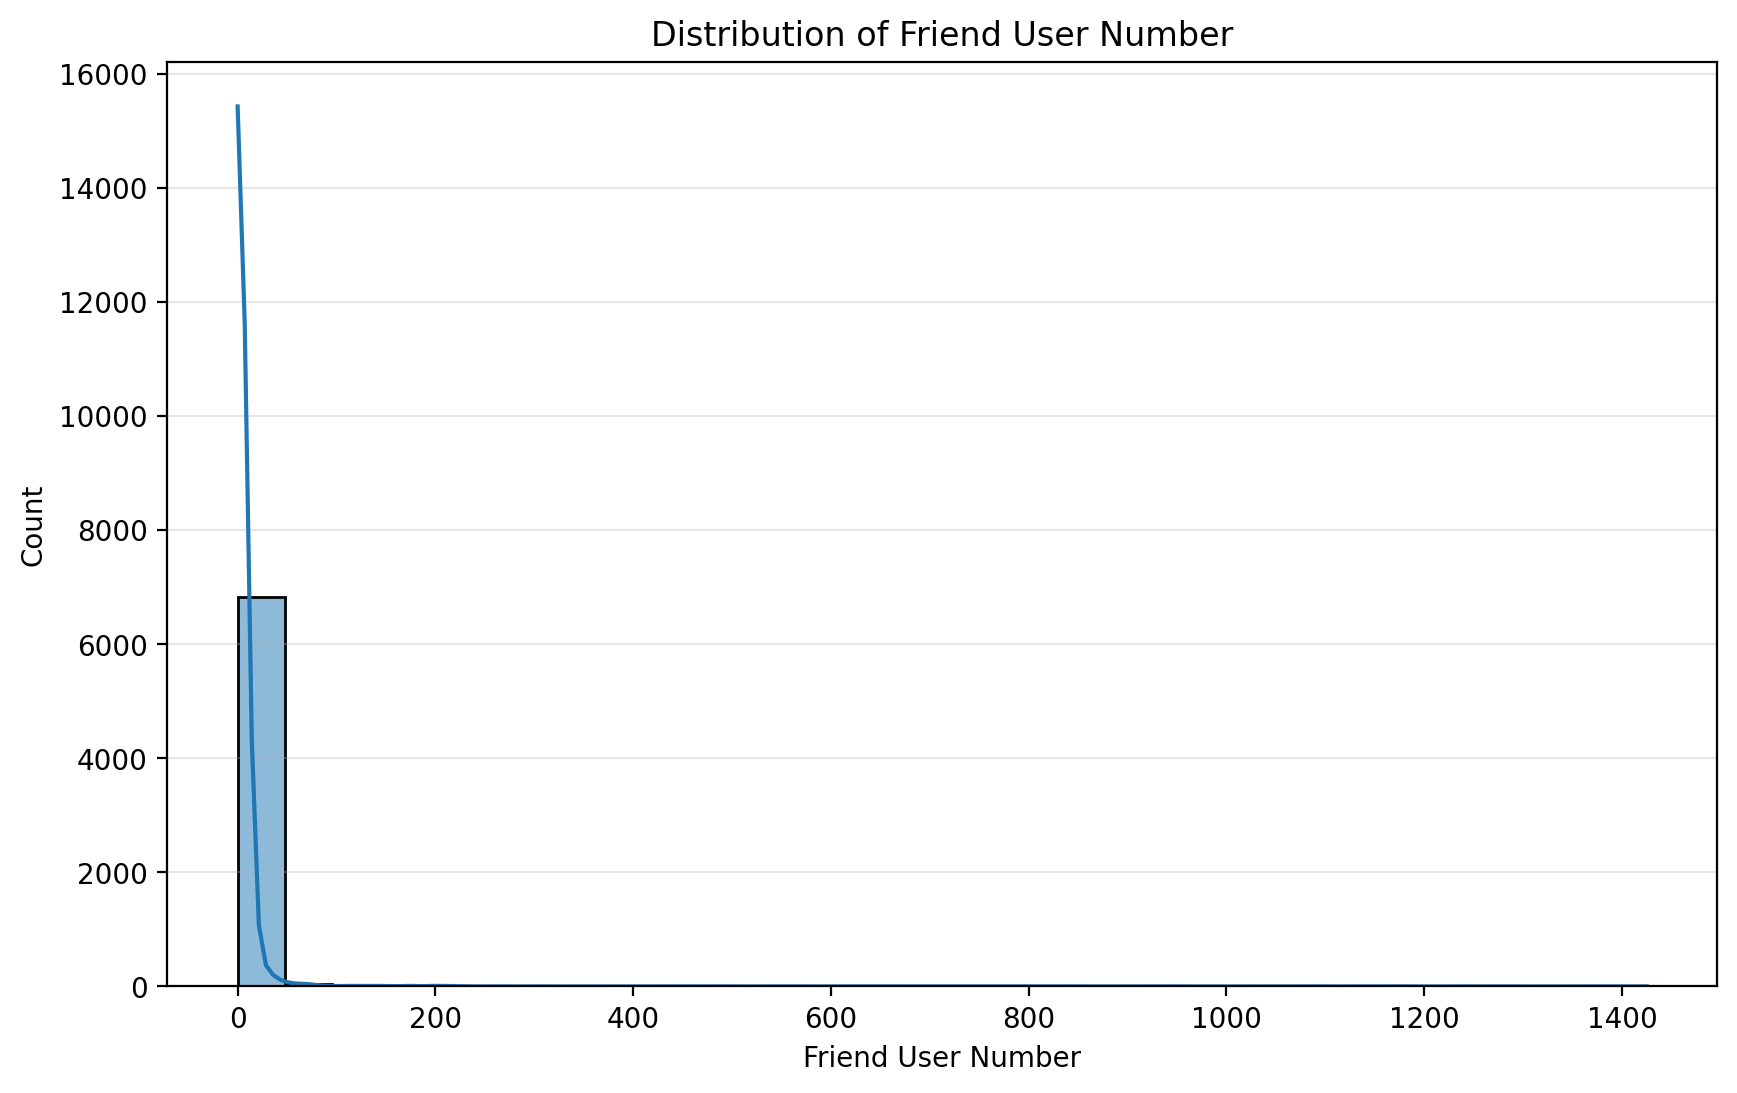

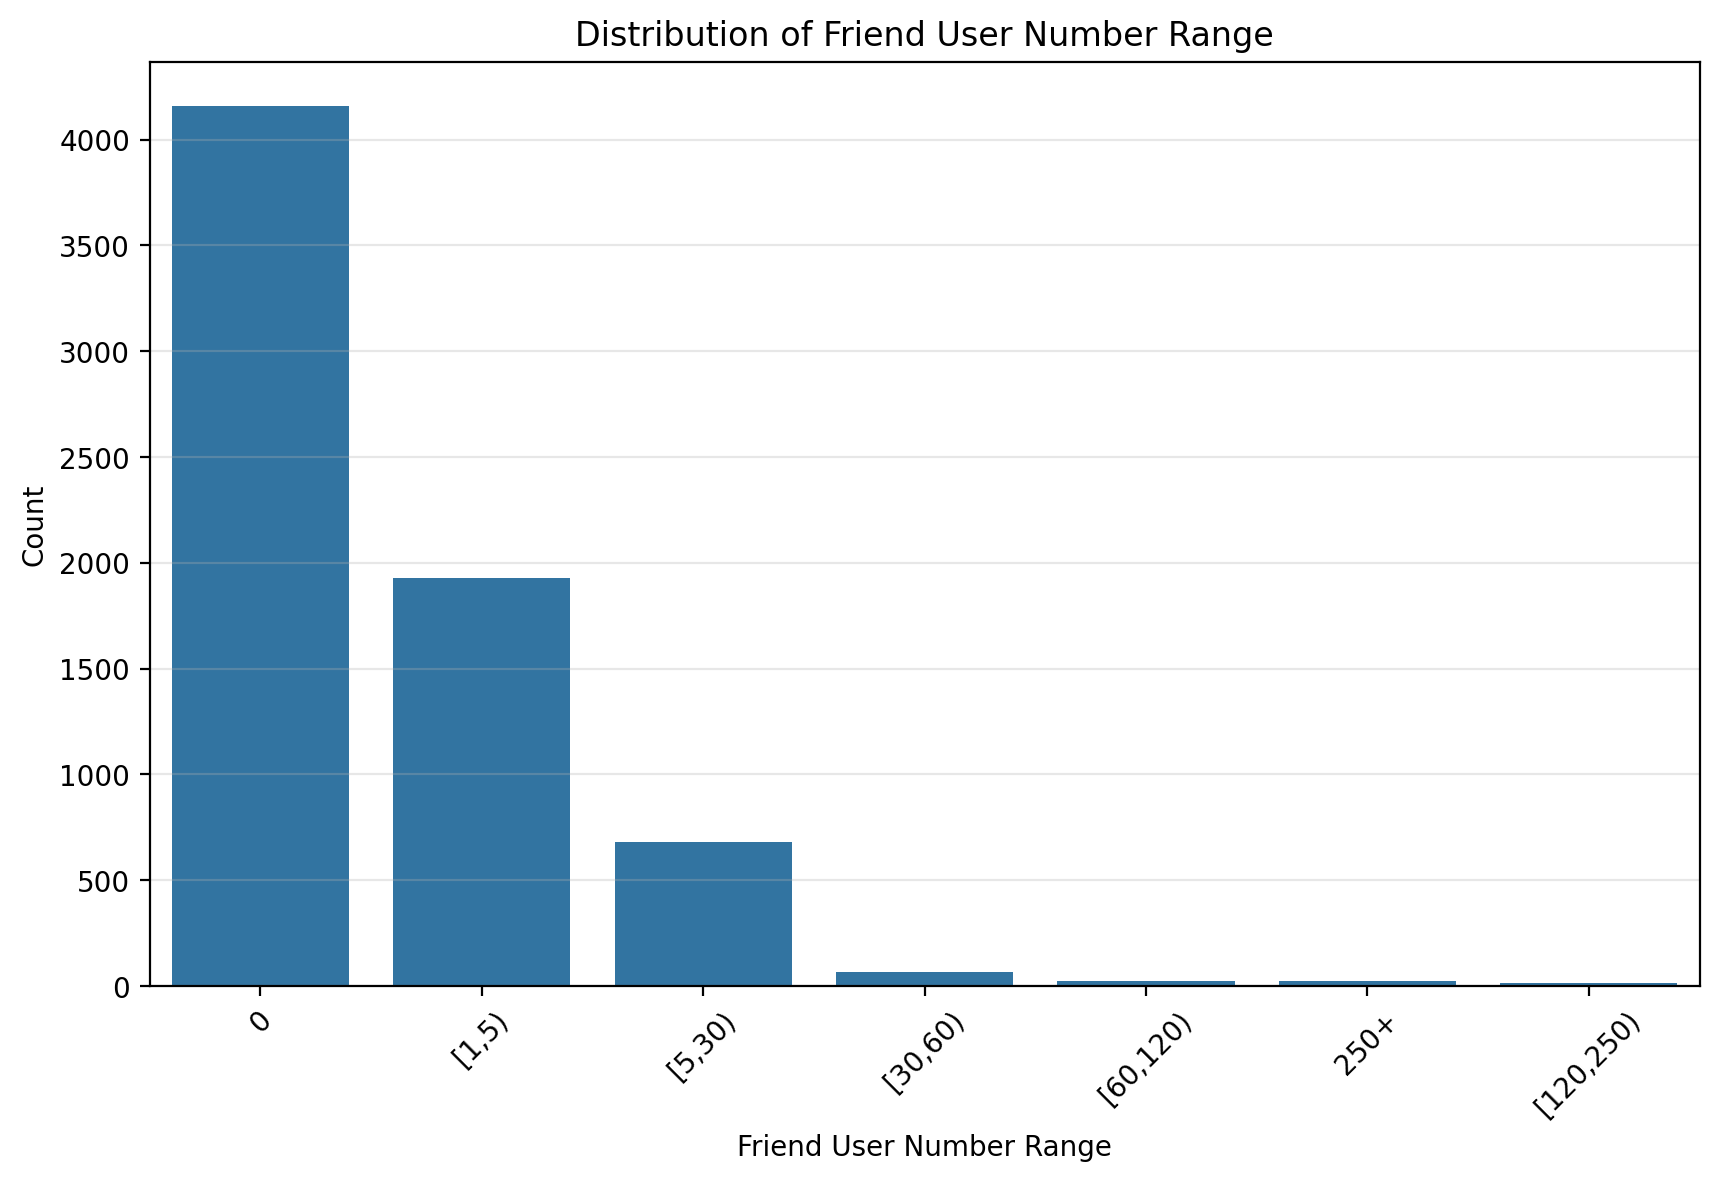

In [ ]:
# 'follow_user_num'
plt.figure(figsize=(10, 6))
sns.histplot(data=user_features_df, x='follow_user_num', bins=30, kde=True)
plt.title("Distribution of Follow User Number")
plt.xlabel("Follow User Number")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 'follow_user_num_range'
plt.figure(figsize=(10, 6))
sns.countplot(data=user_features_df, x='follow_user_num_range', order=user_features_df['follow_user_num_range'].value_counts().index)
plt.title("Distribution of Follow User Number Range")
plt.xlabel("Follow User Number Range")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.show()

# 'fans_user_num'
plt.figure(figsize=(10, 6))
sns.histplot(data=user_features_df, x='fans_user_num', bins=30, kde=True)
plt.title("Distribution of Fans User Number")
plt.xlabel("Fans User Number")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 'fans_user_num_range'
plt.figure(figsize=(10, 6))
sns.countplot(data=user_features_df, x='fans_user_num_range', order=user_features_df['fans_user_num_range'].value_counts().index)
plt.title("Distribution of Fans User Number Range")
plt.xlabel("Fans User Number Range")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.show()

# 'friend_user_num'
plt.figure(figsize=(10, 6))
sns.histplot(data=user_features_df, x='friend_user_num', bins=30, kde=True)
plt.title("Distribution of Friend User Number")
plt.xlabel("Friend User Number")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

# 'friend_user_num_range'
plt.figure(figsize=(10, 6))
sns.countplot(data=user_features_df, x='friend_user_num_range', order=user_features_df['friend_user_num_range'].value_counts().index)
plt.title("Distribution of Friend User Number Range")
plt.xlabel("Friend User Number Range")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.show()

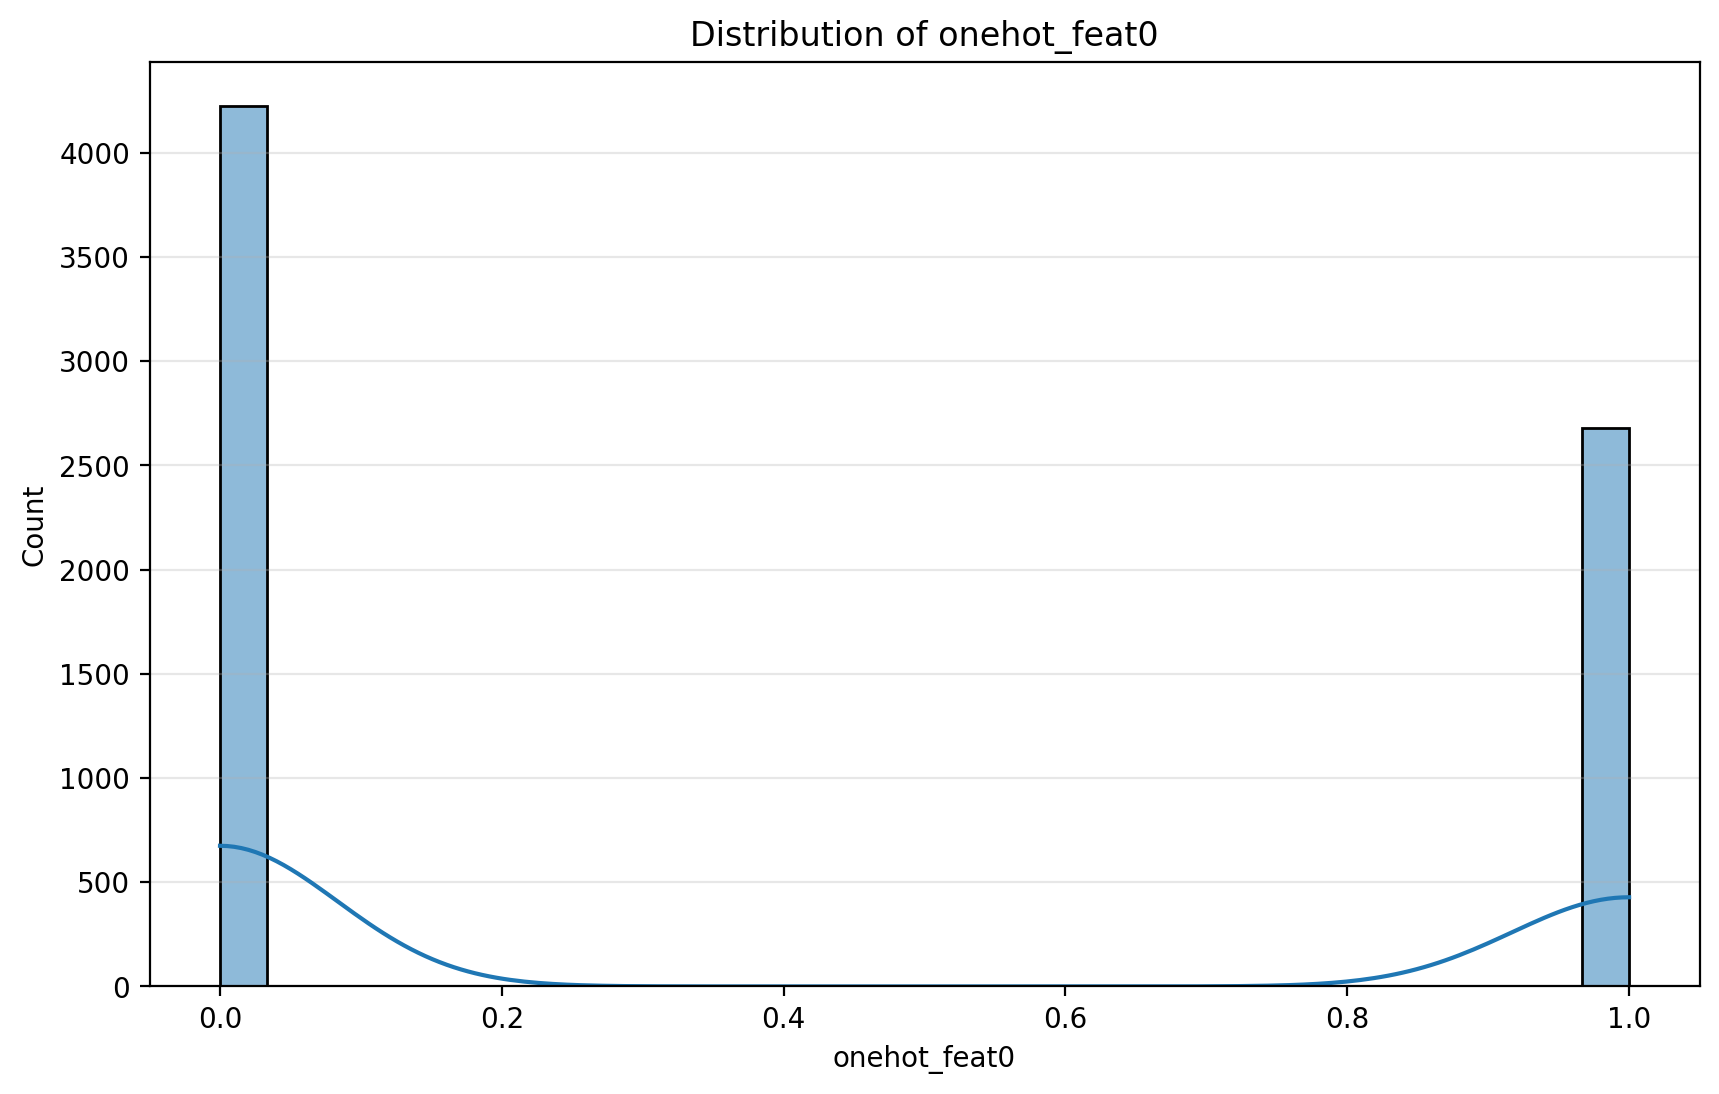

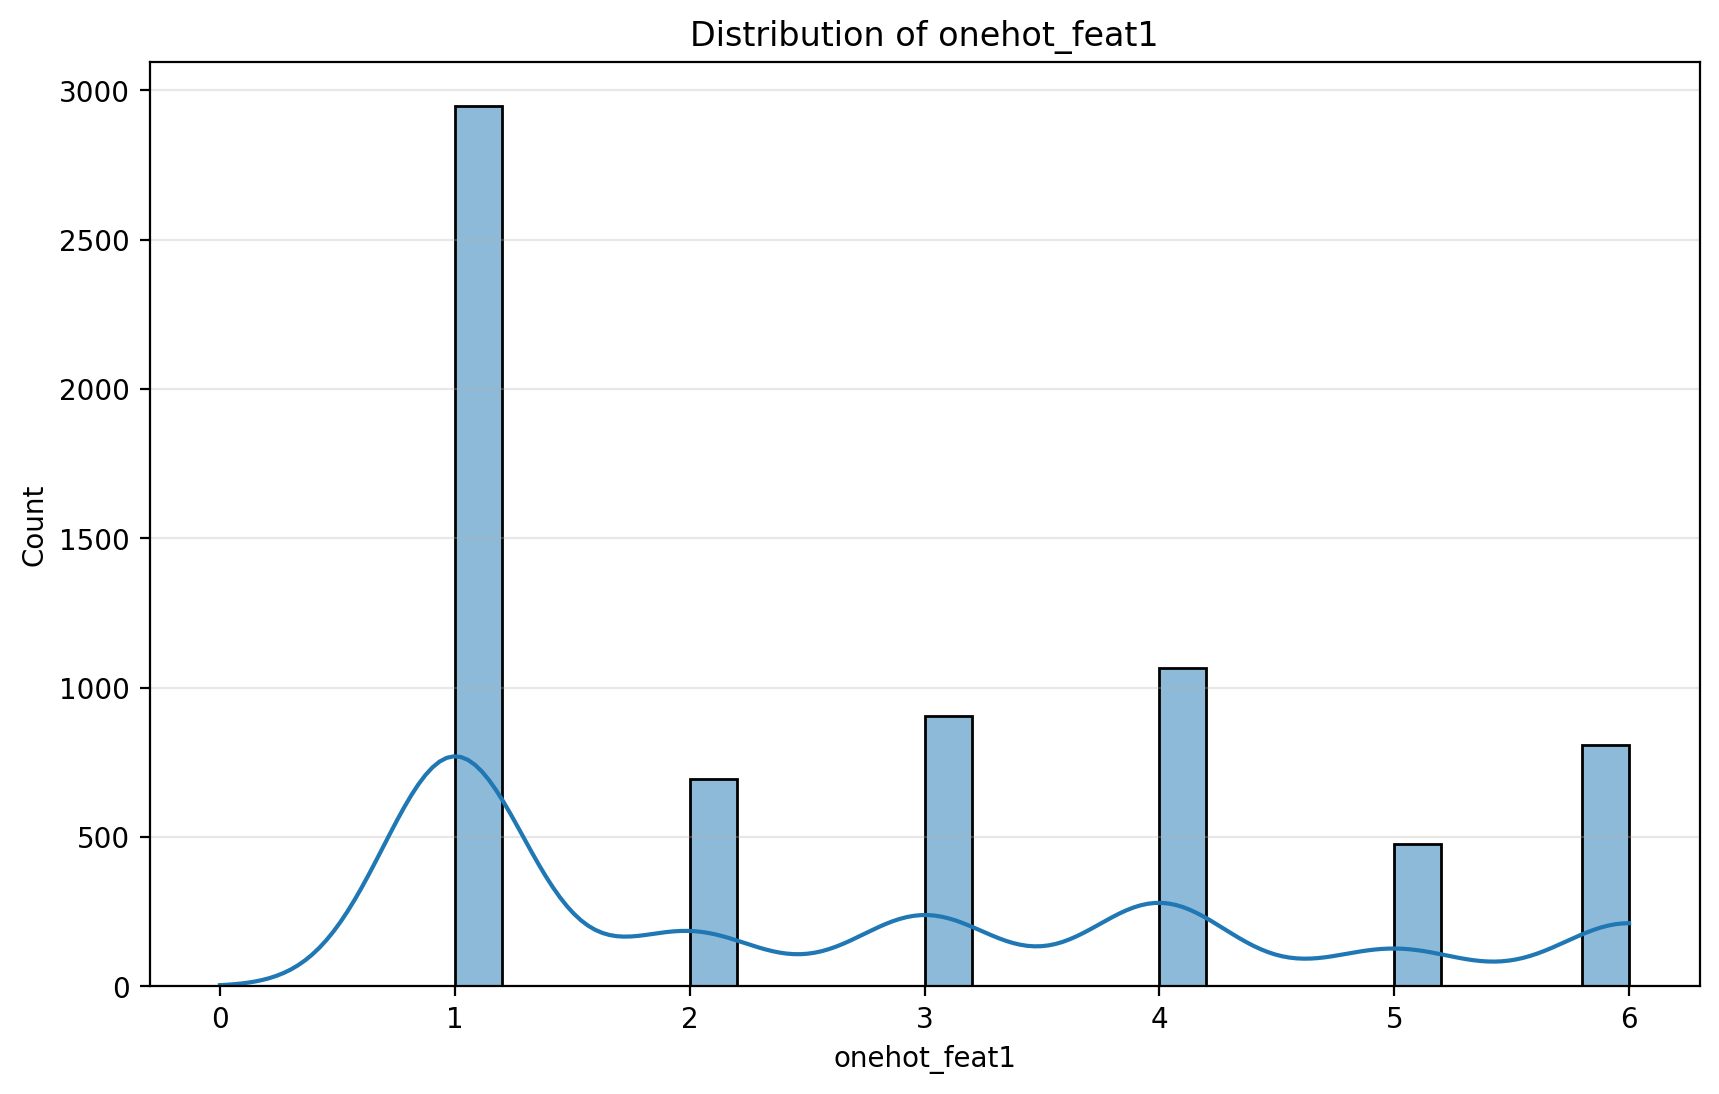

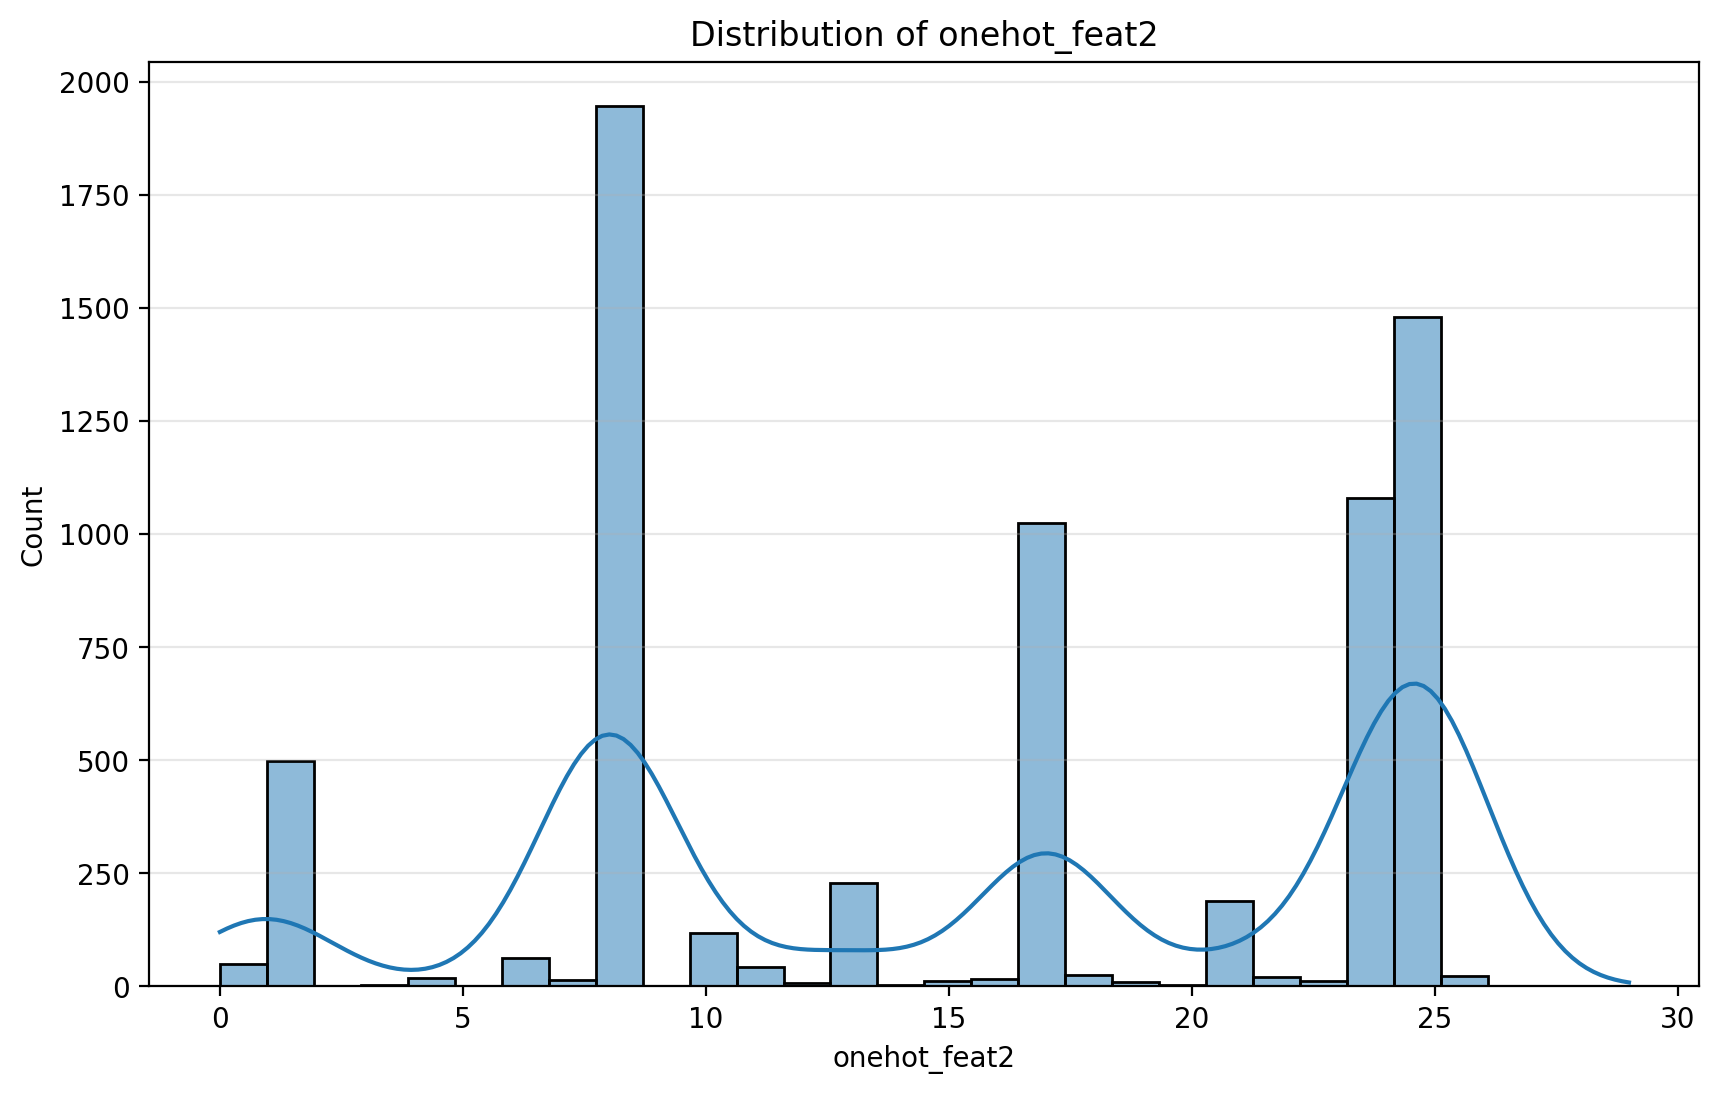

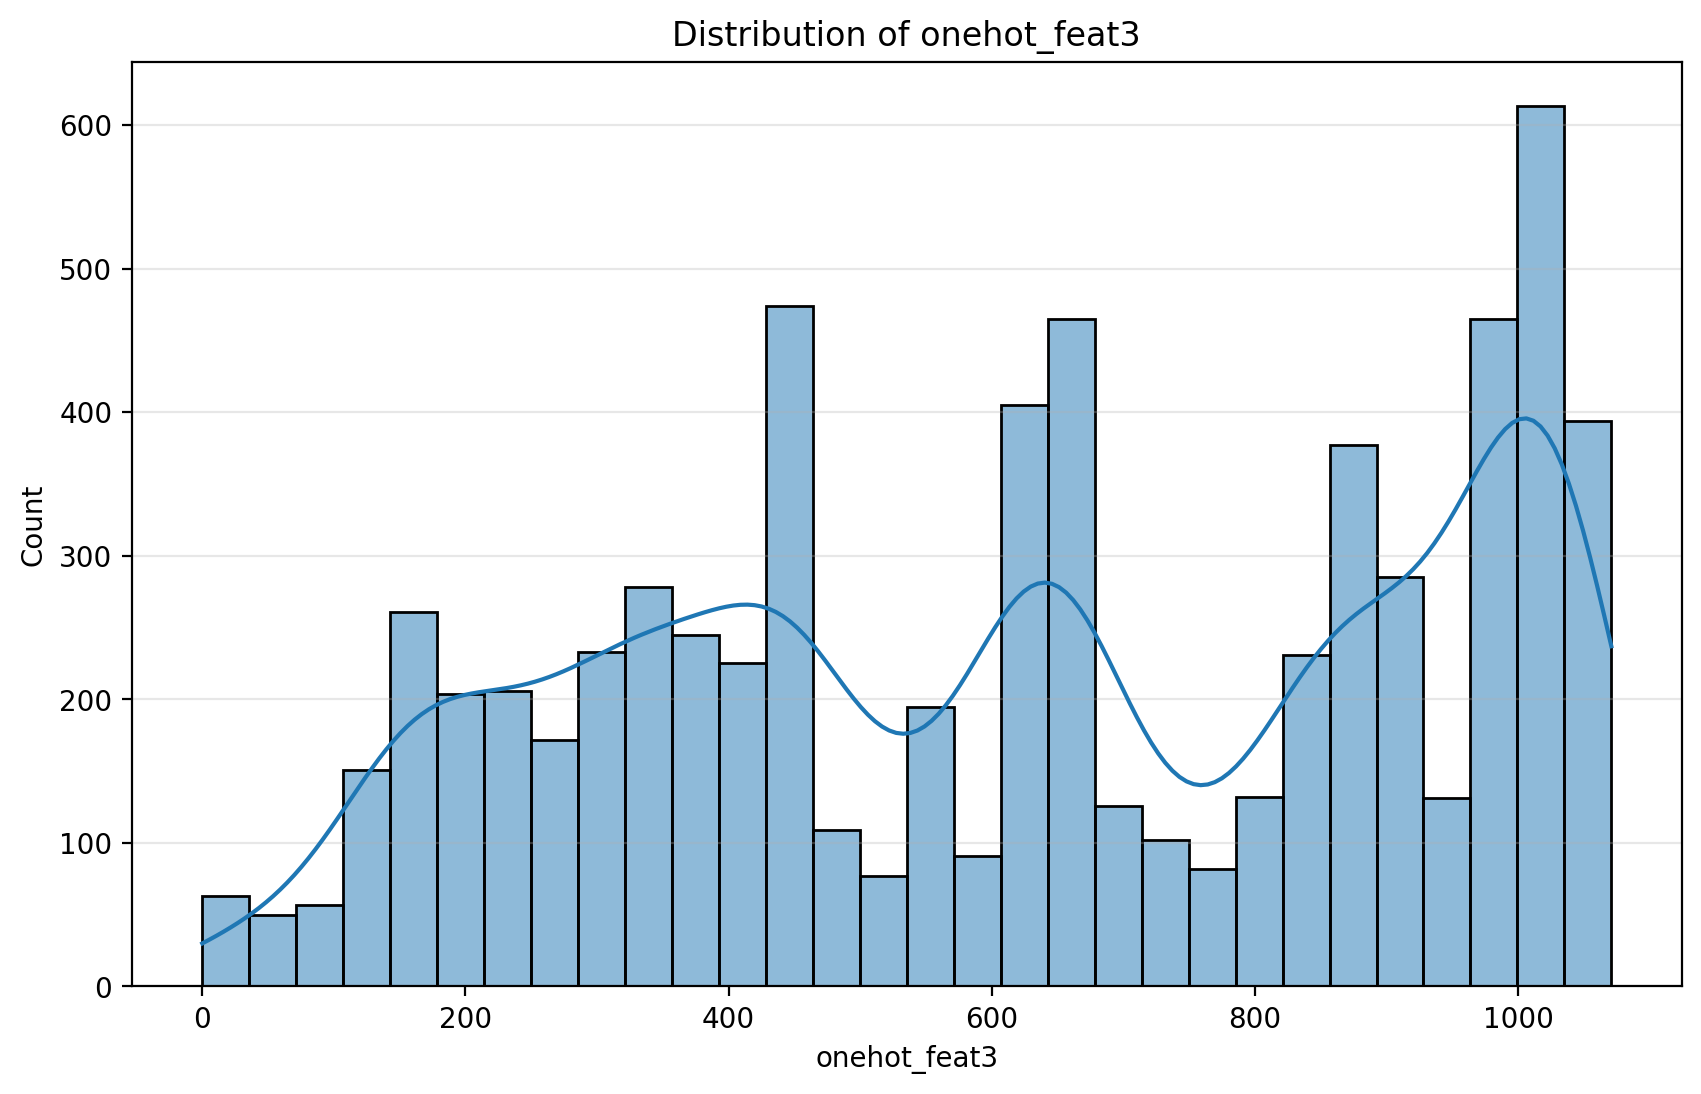

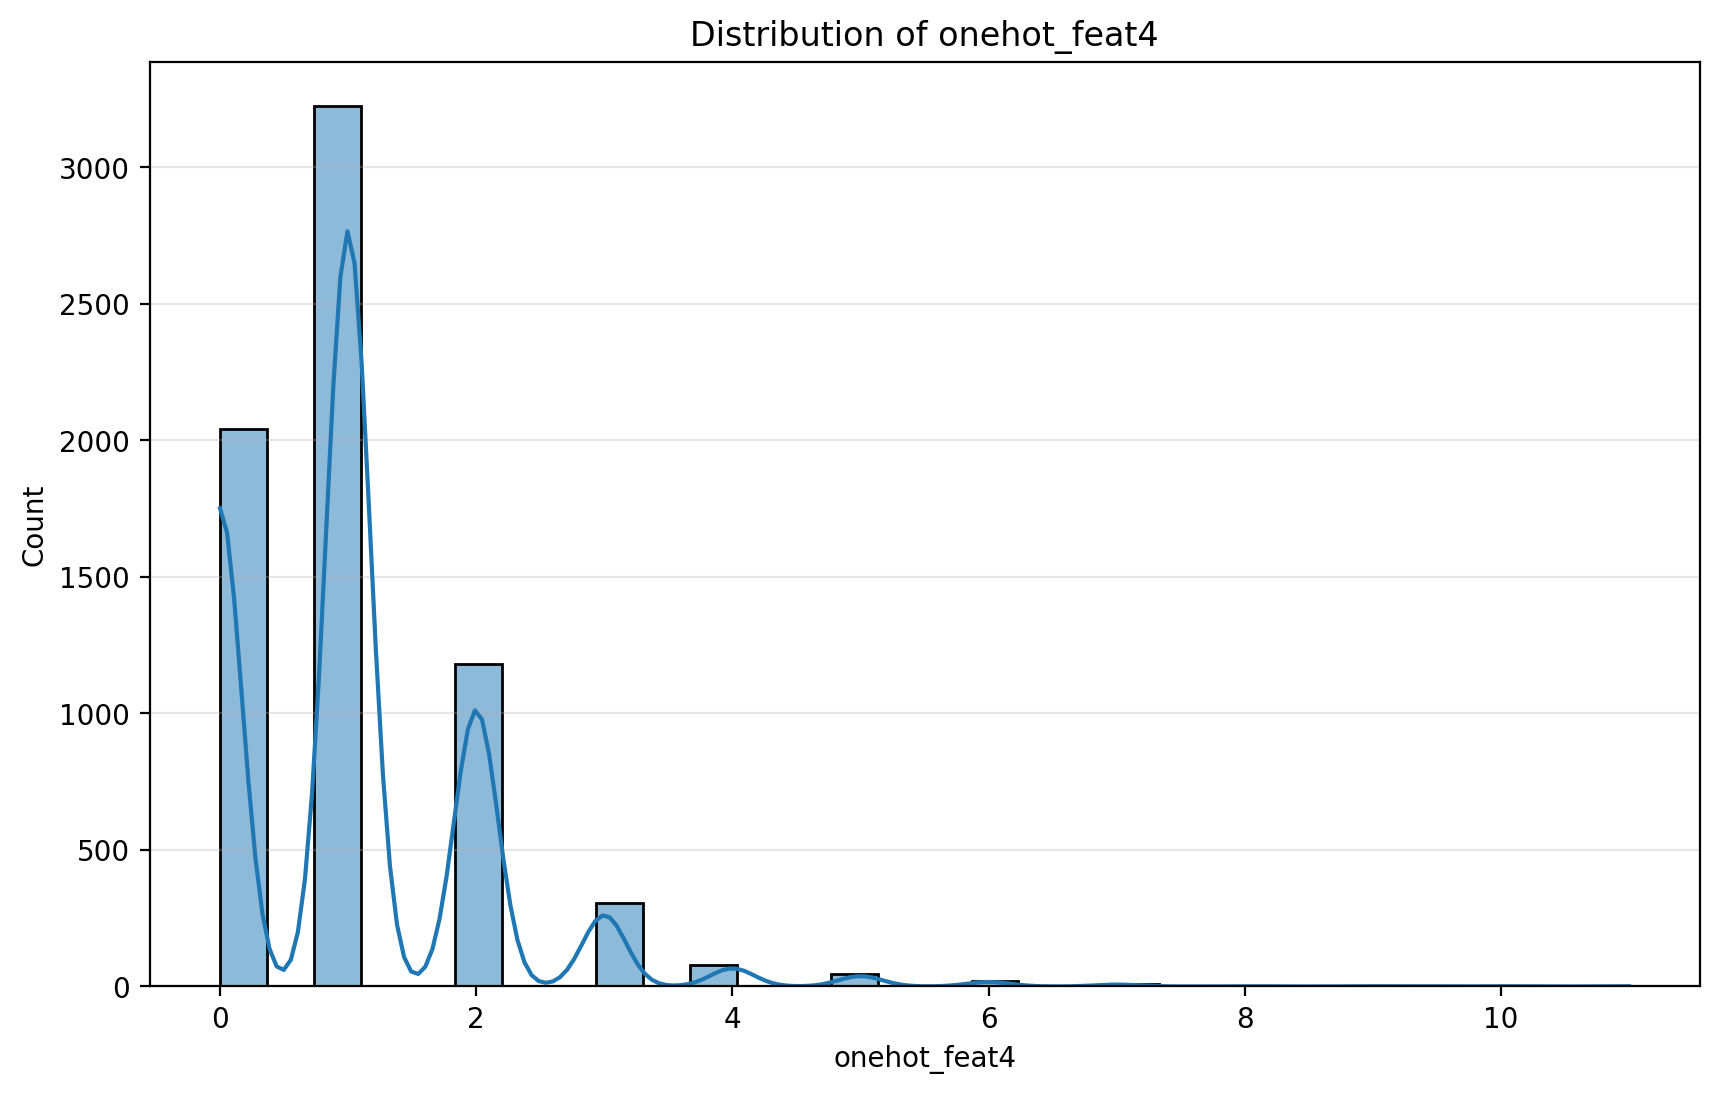

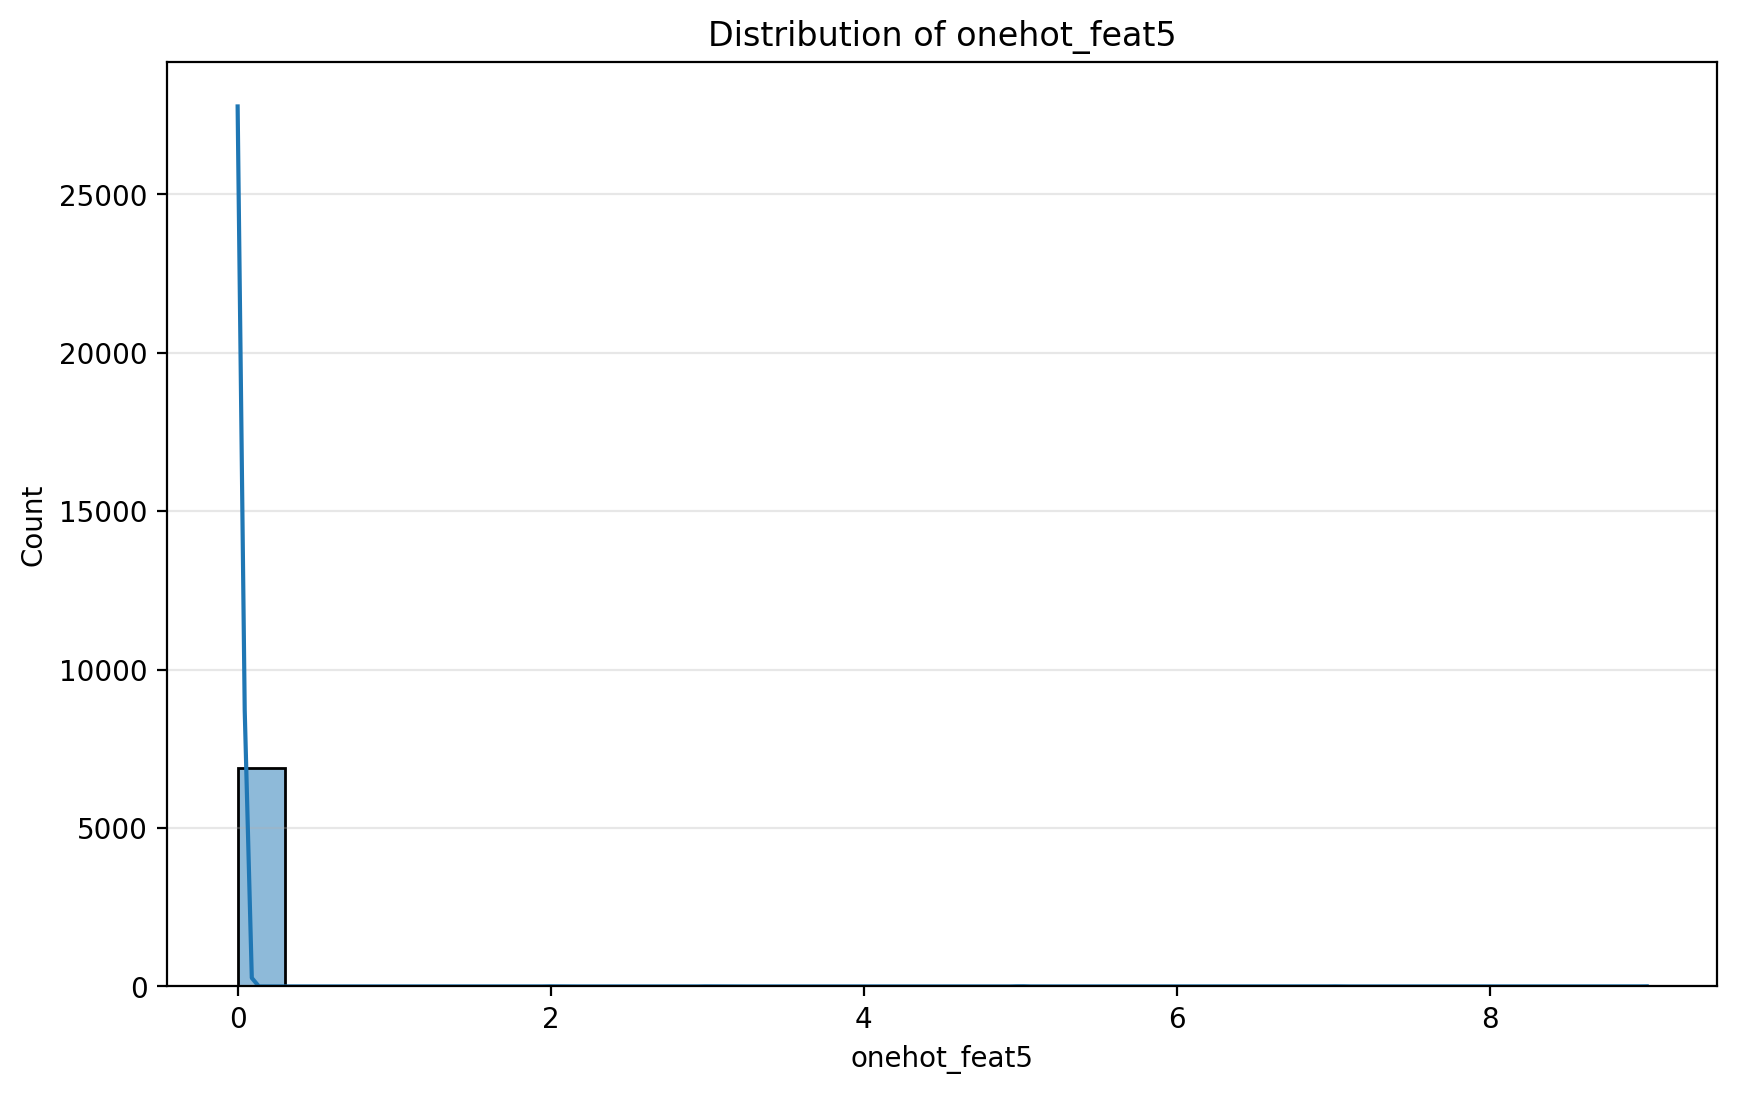

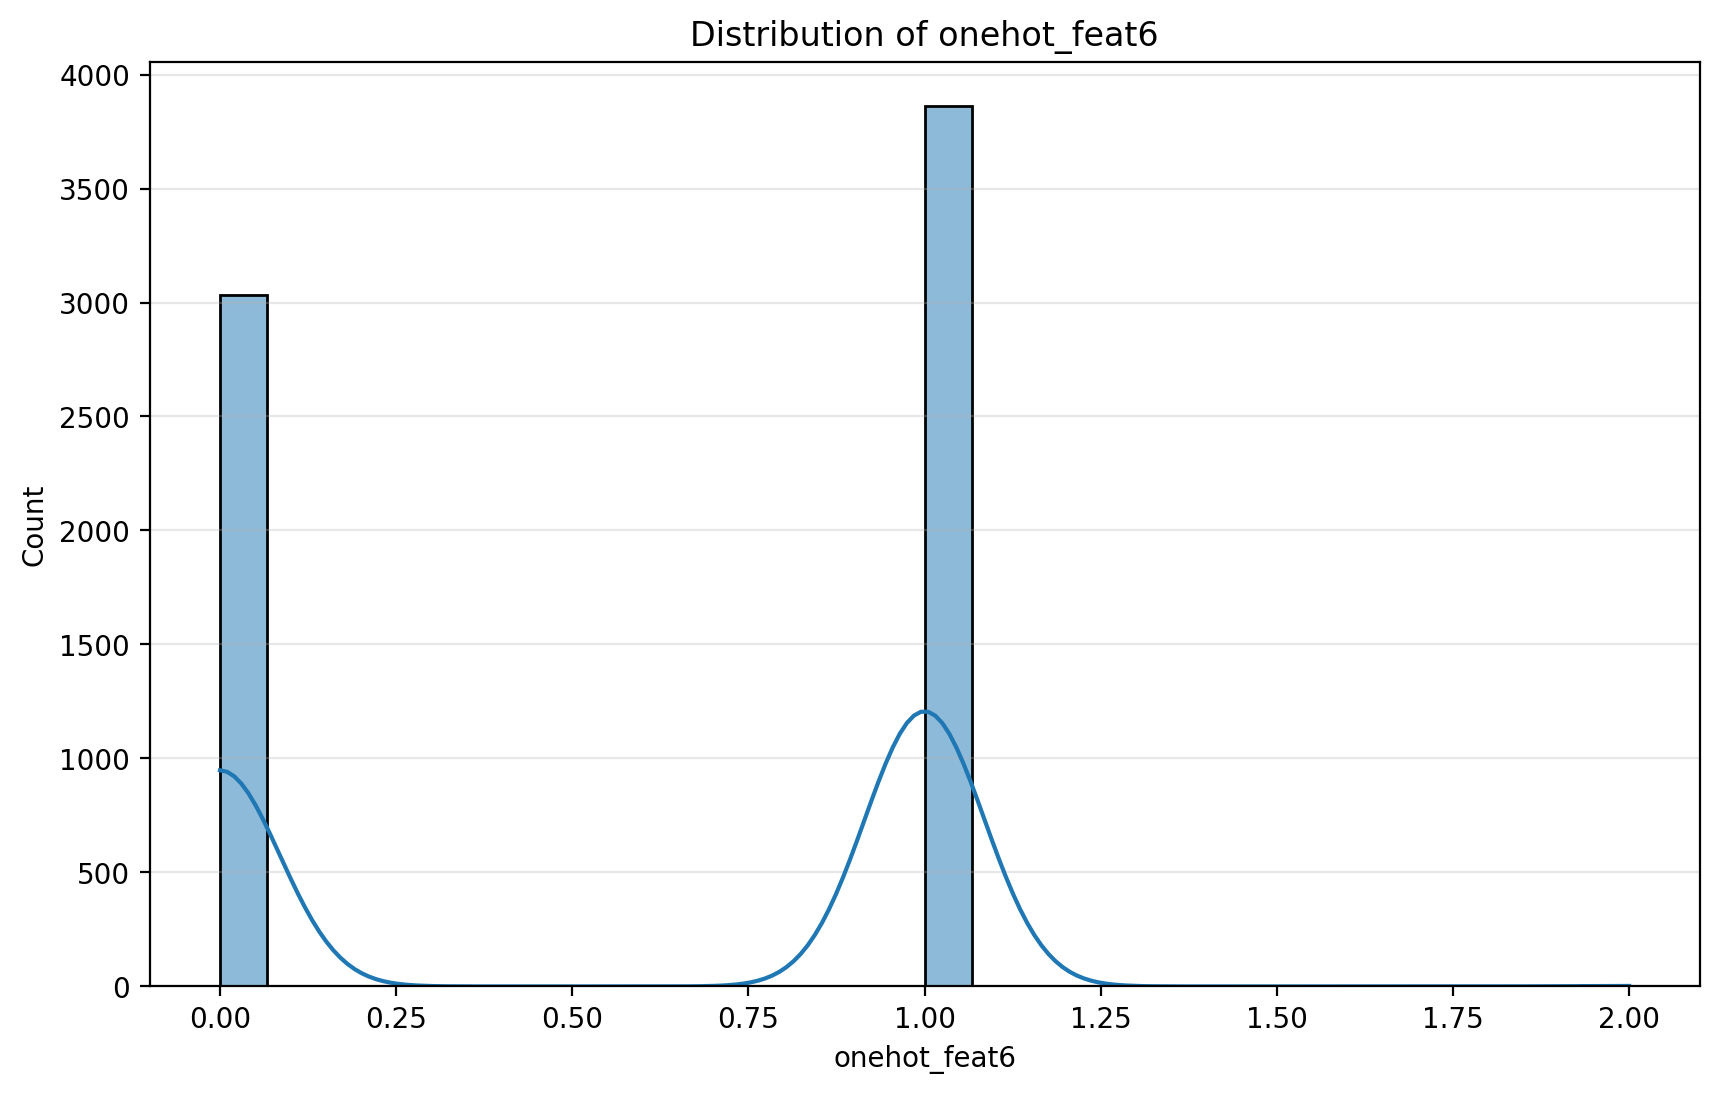

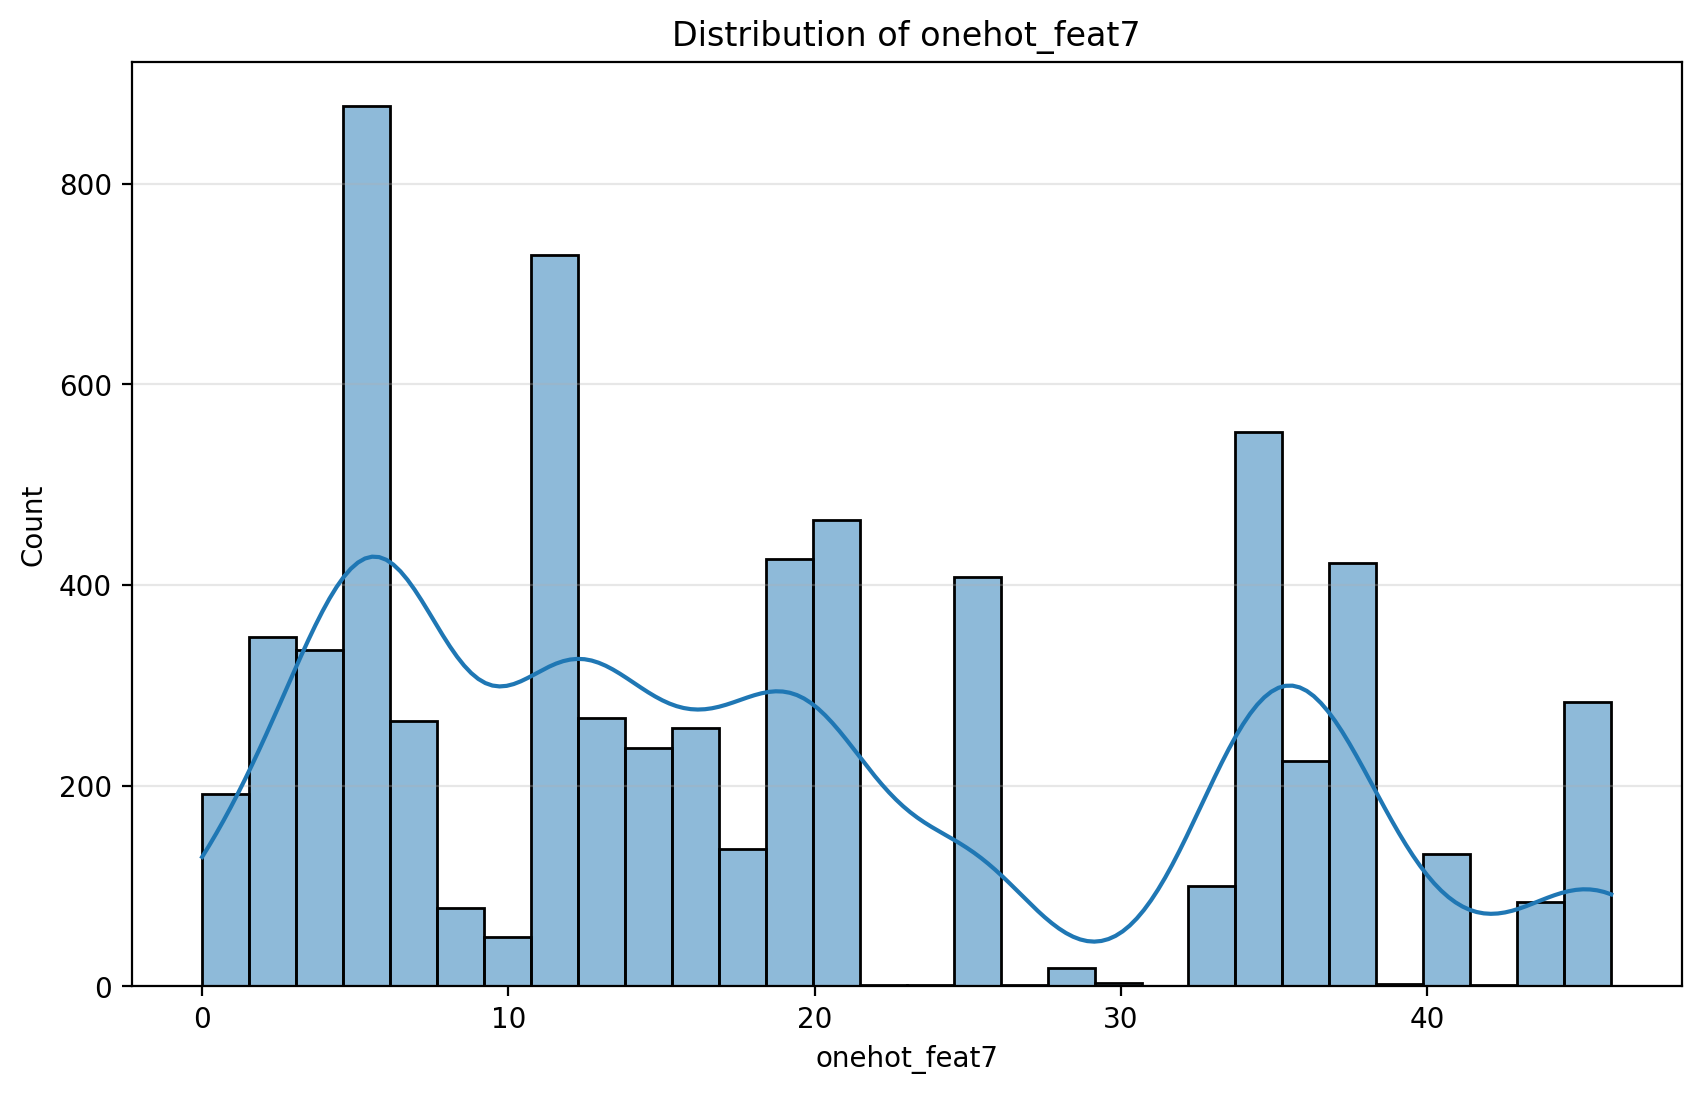

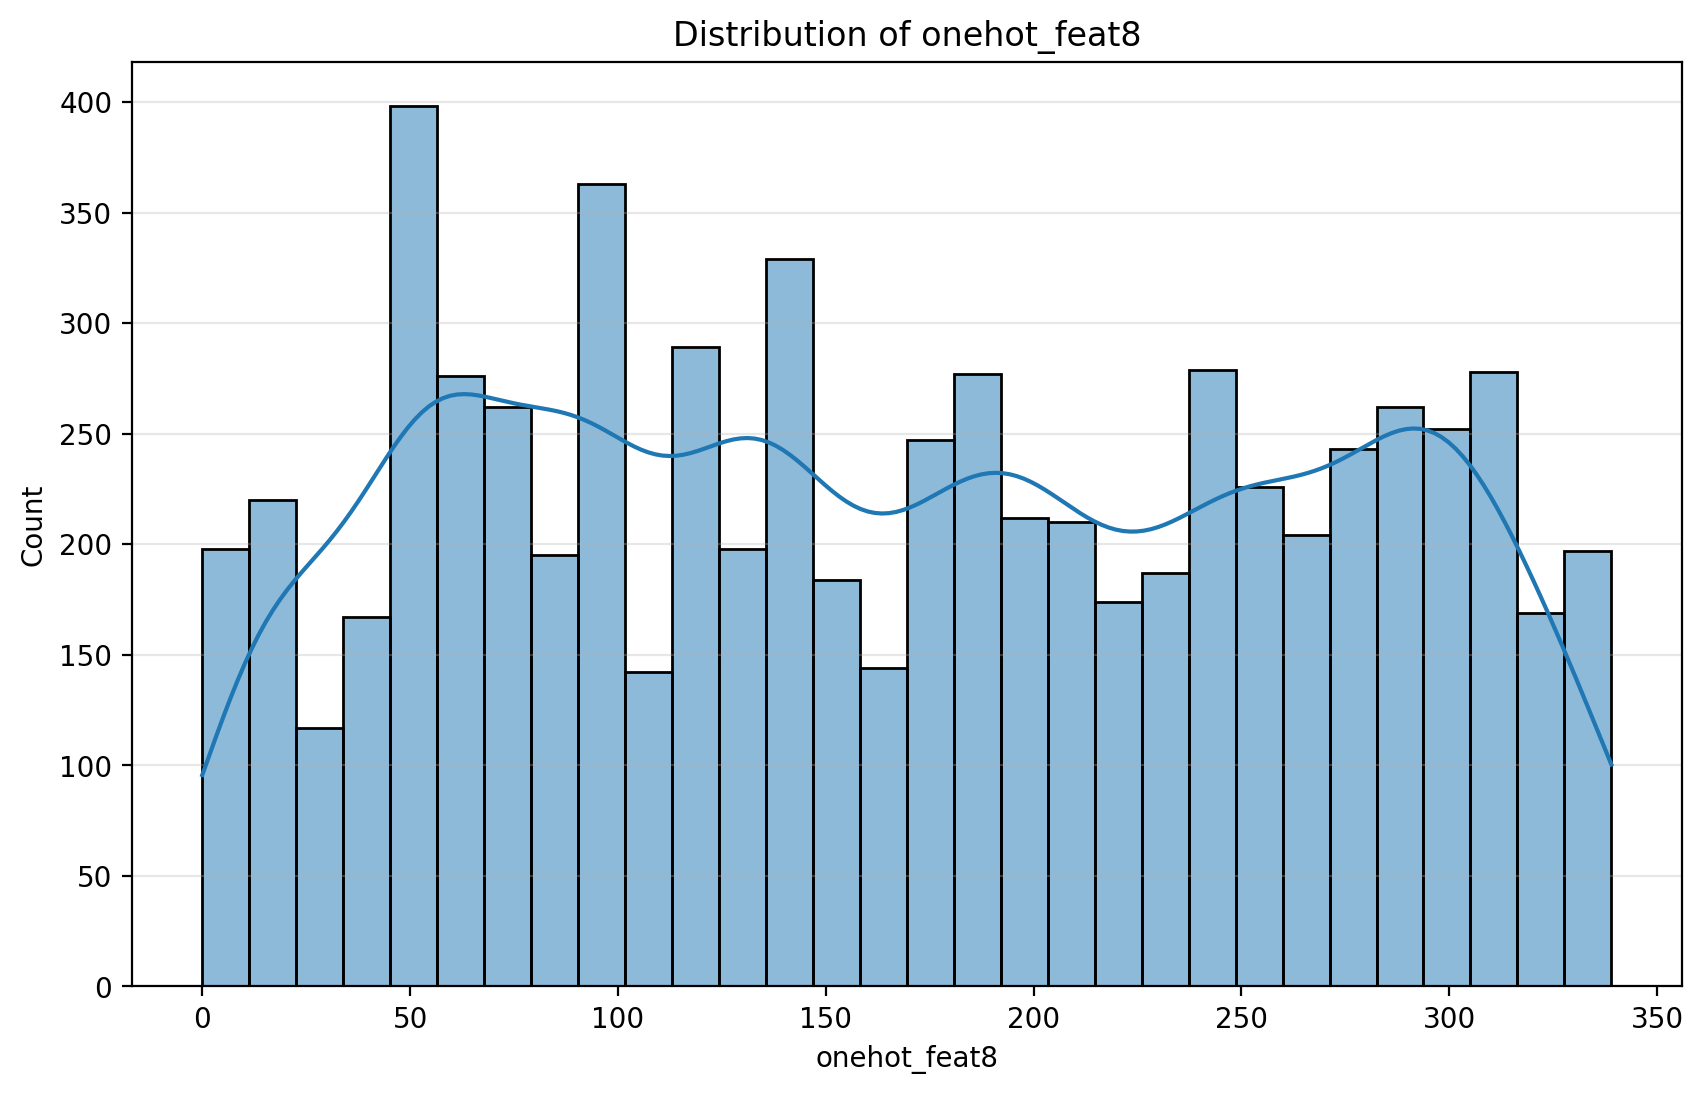

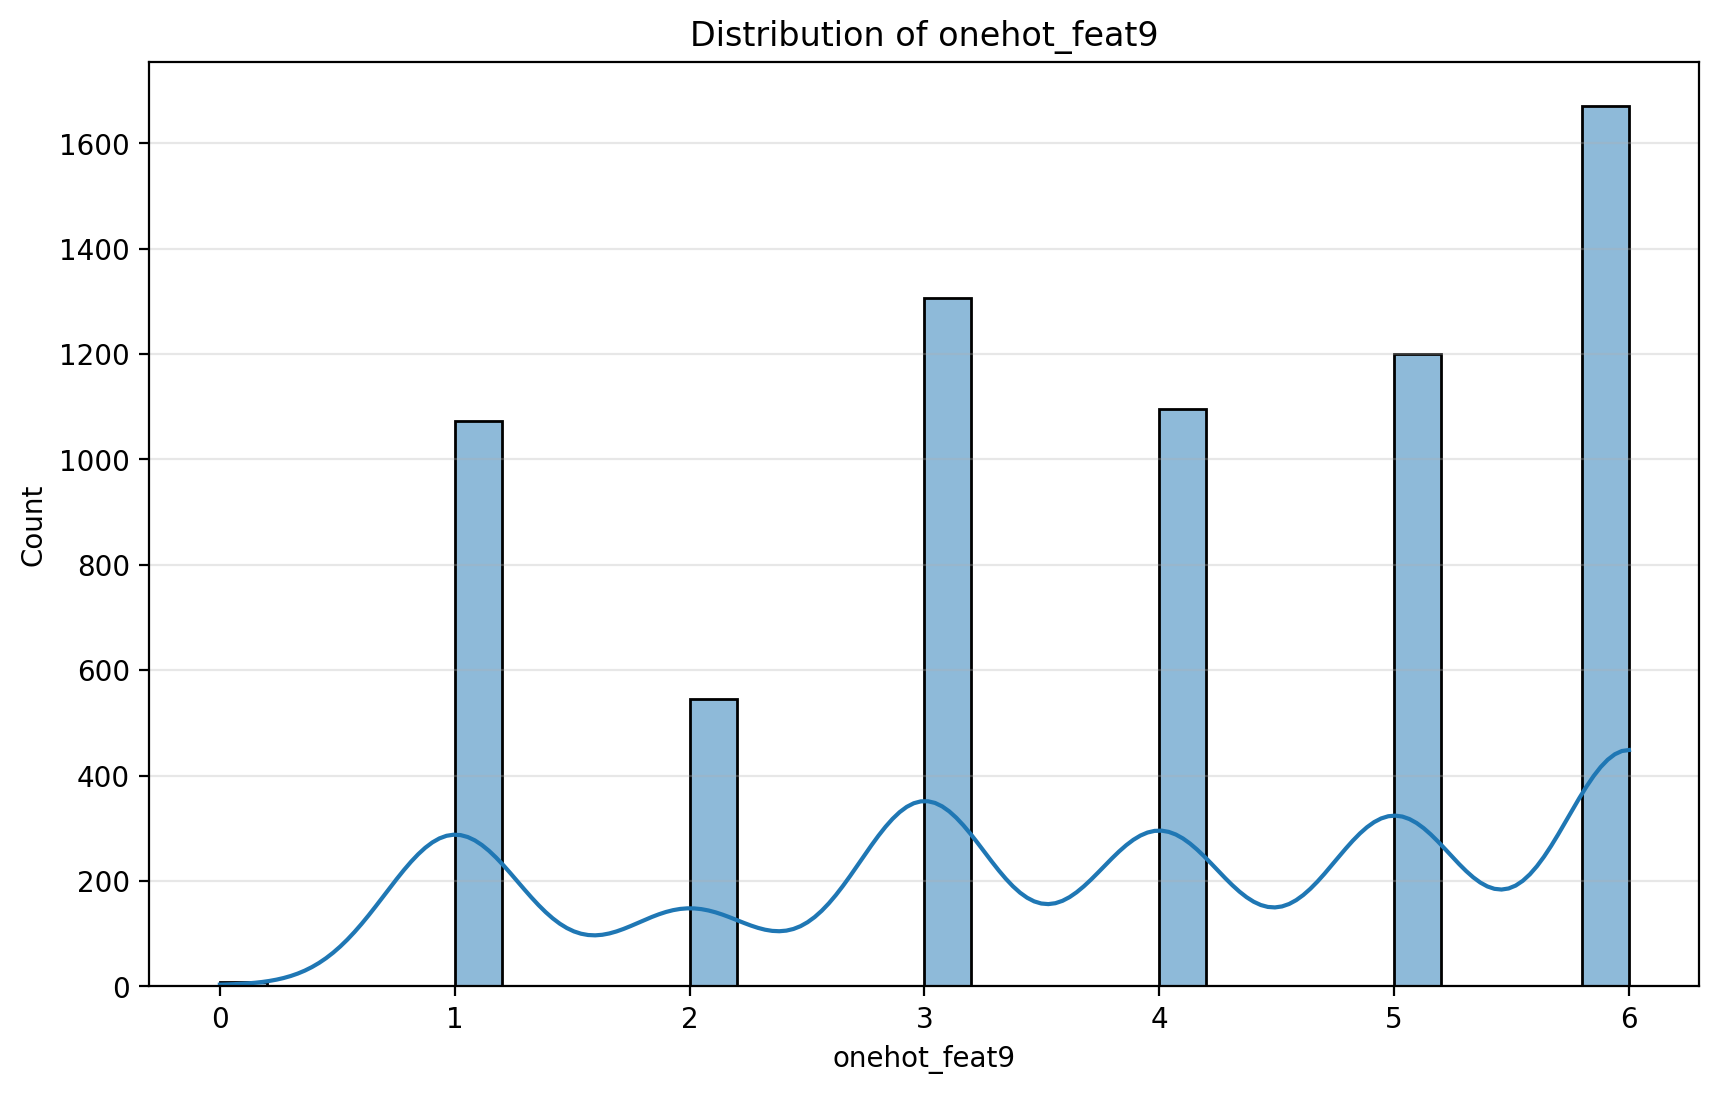

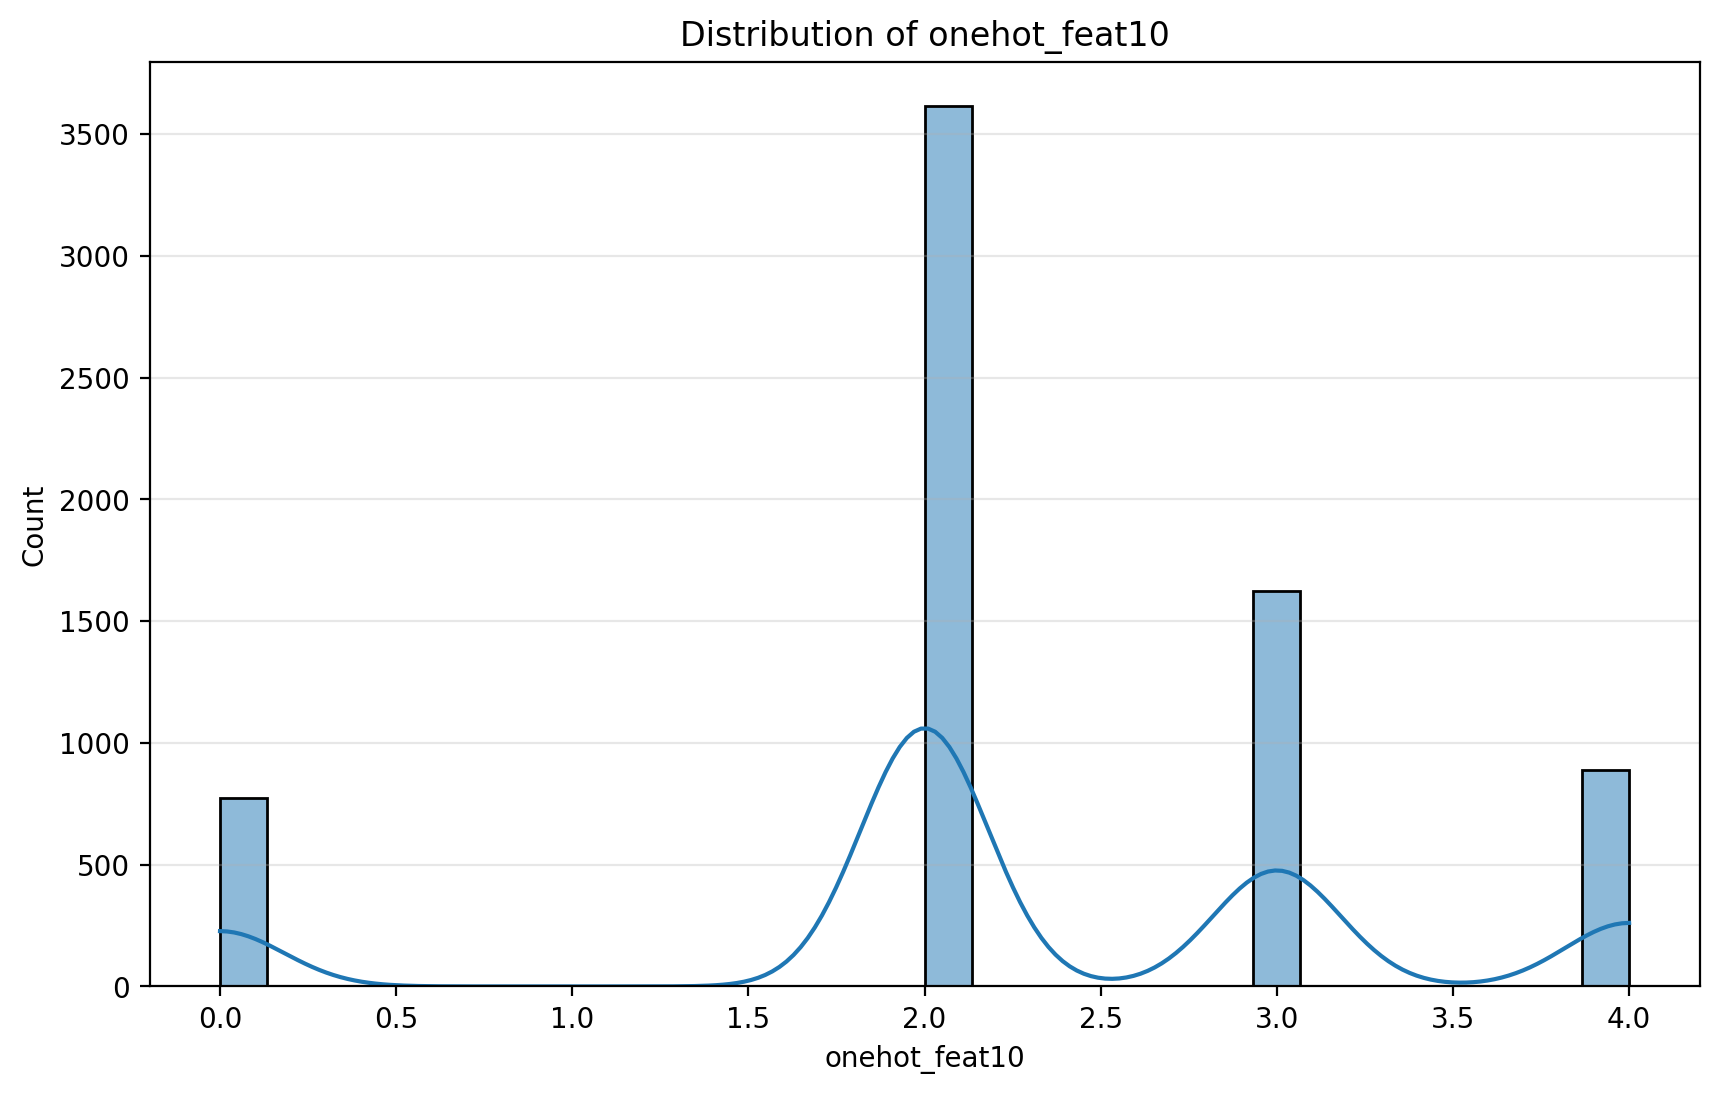

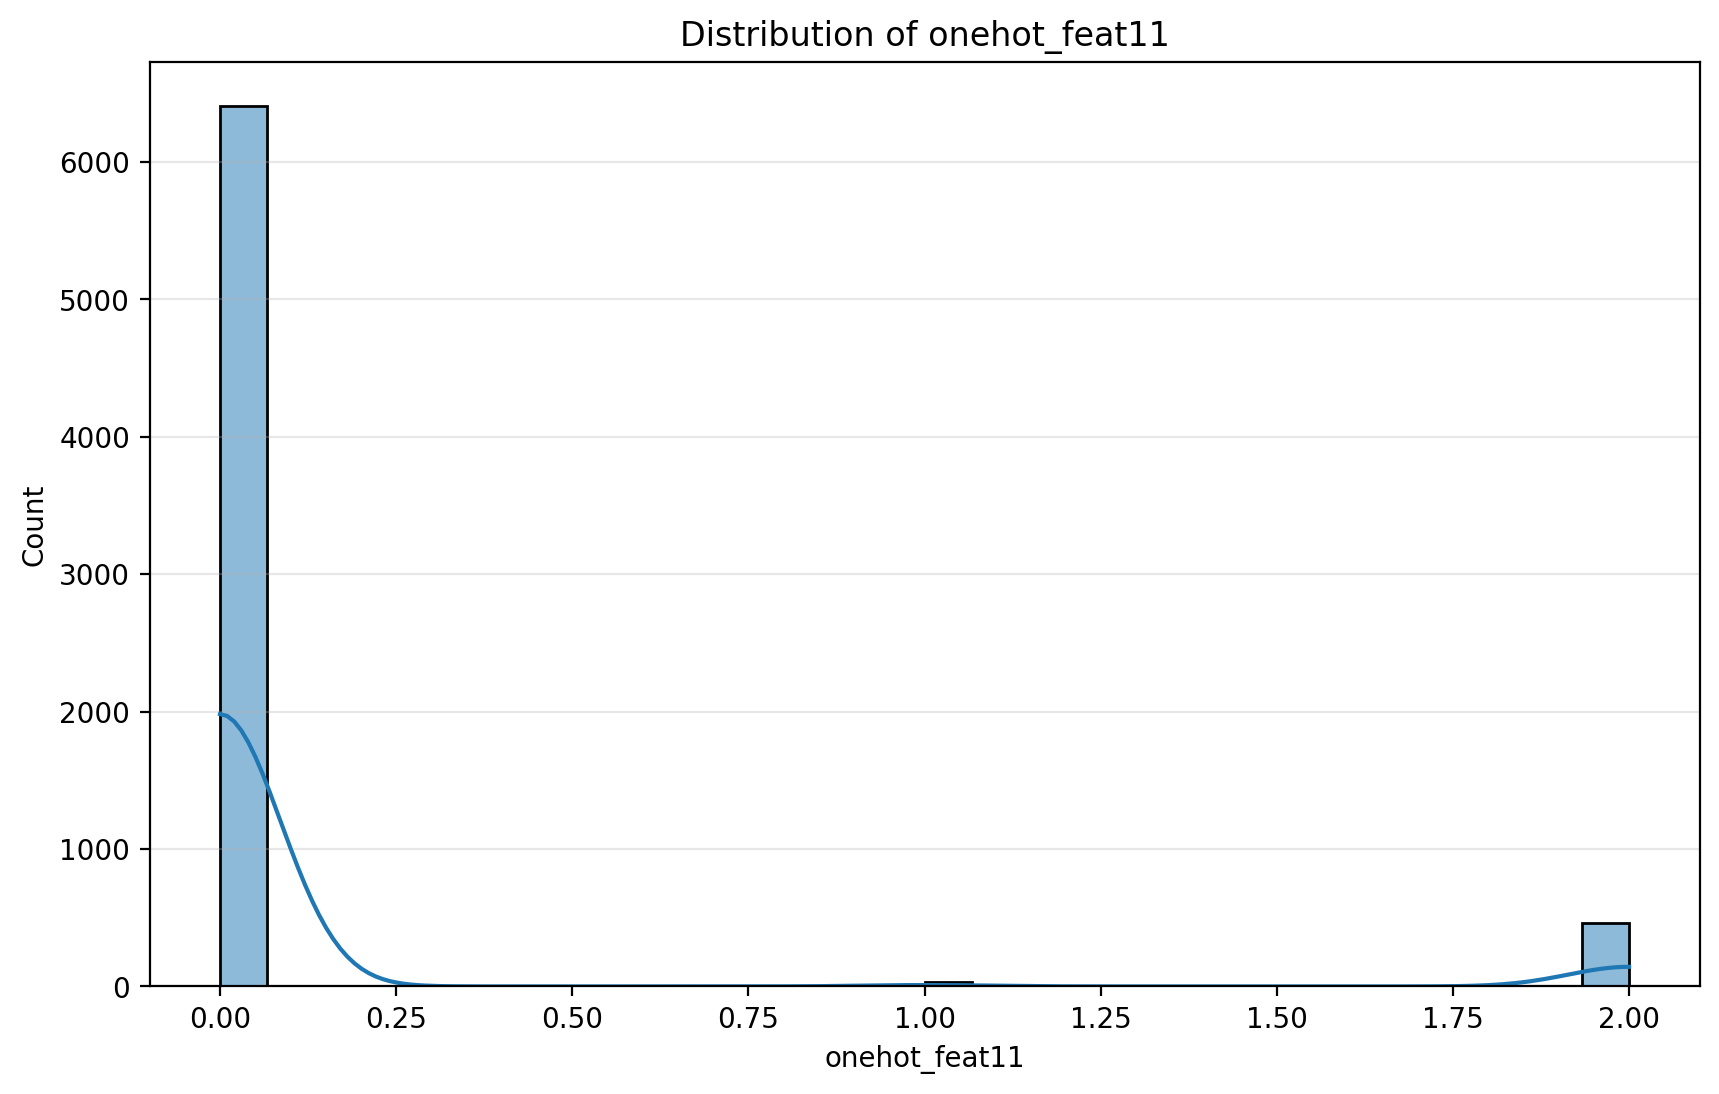

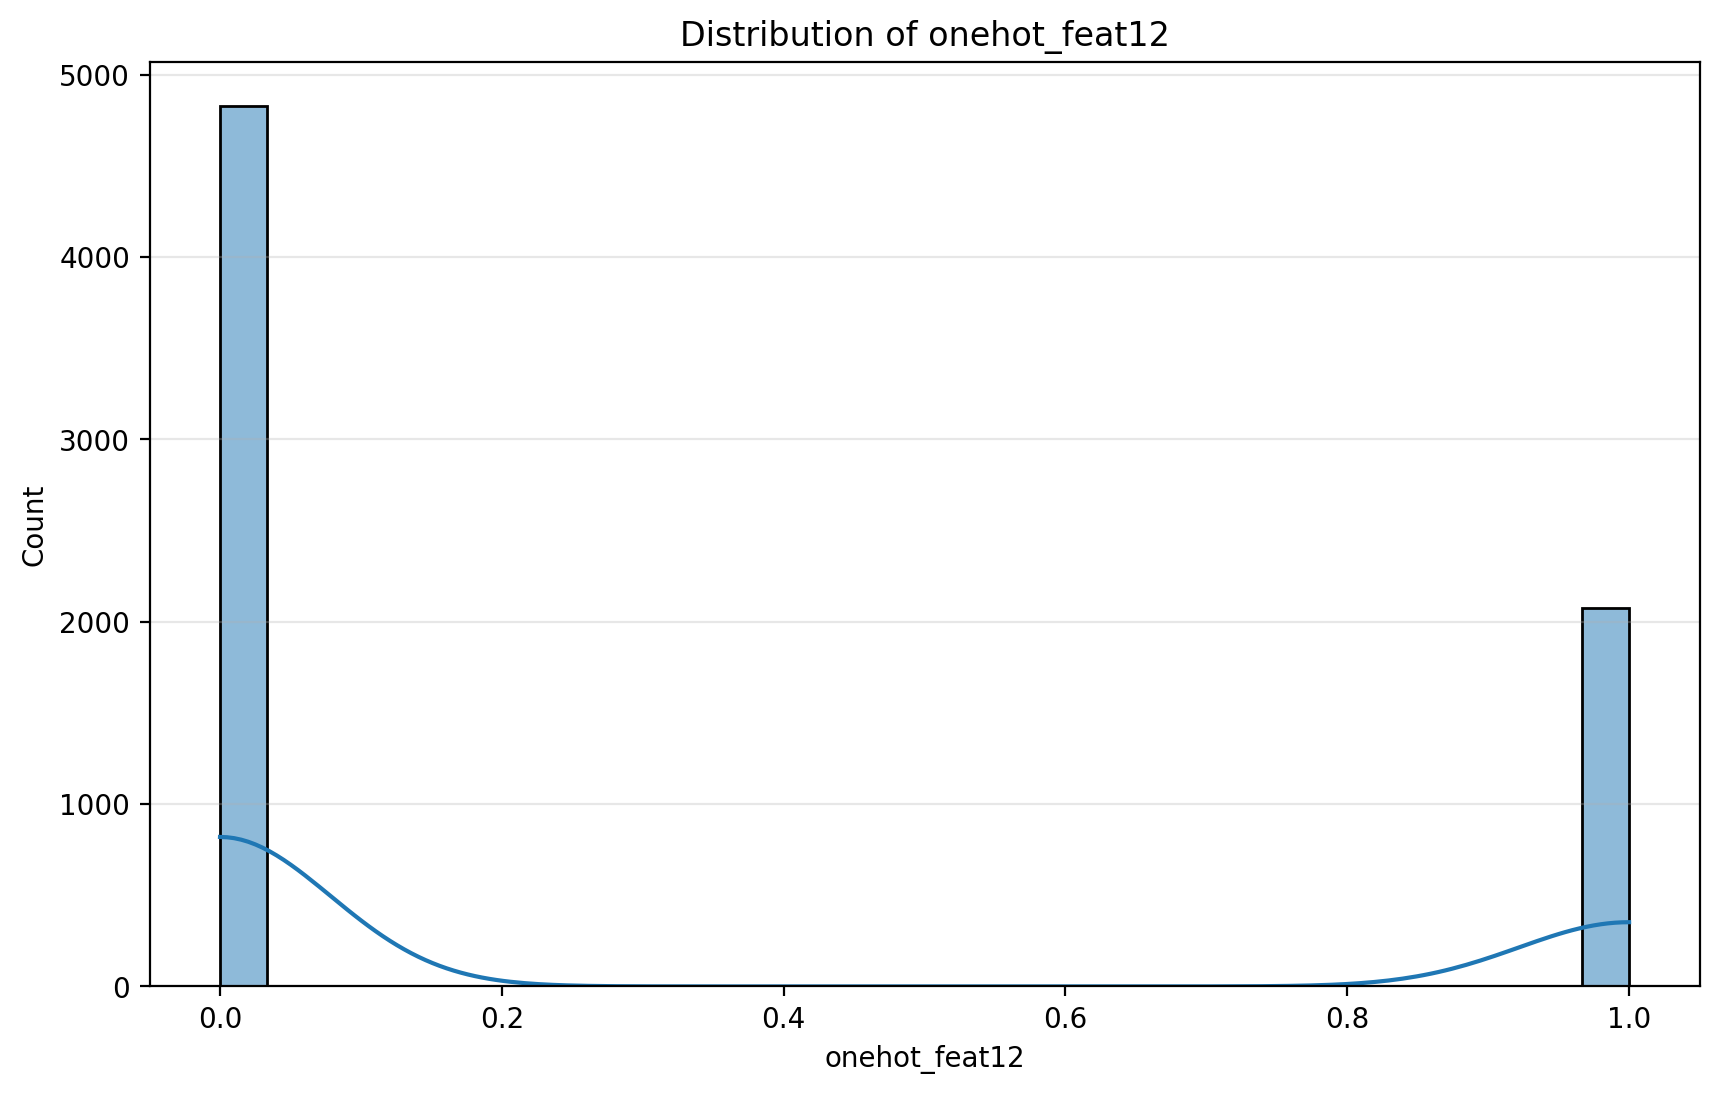

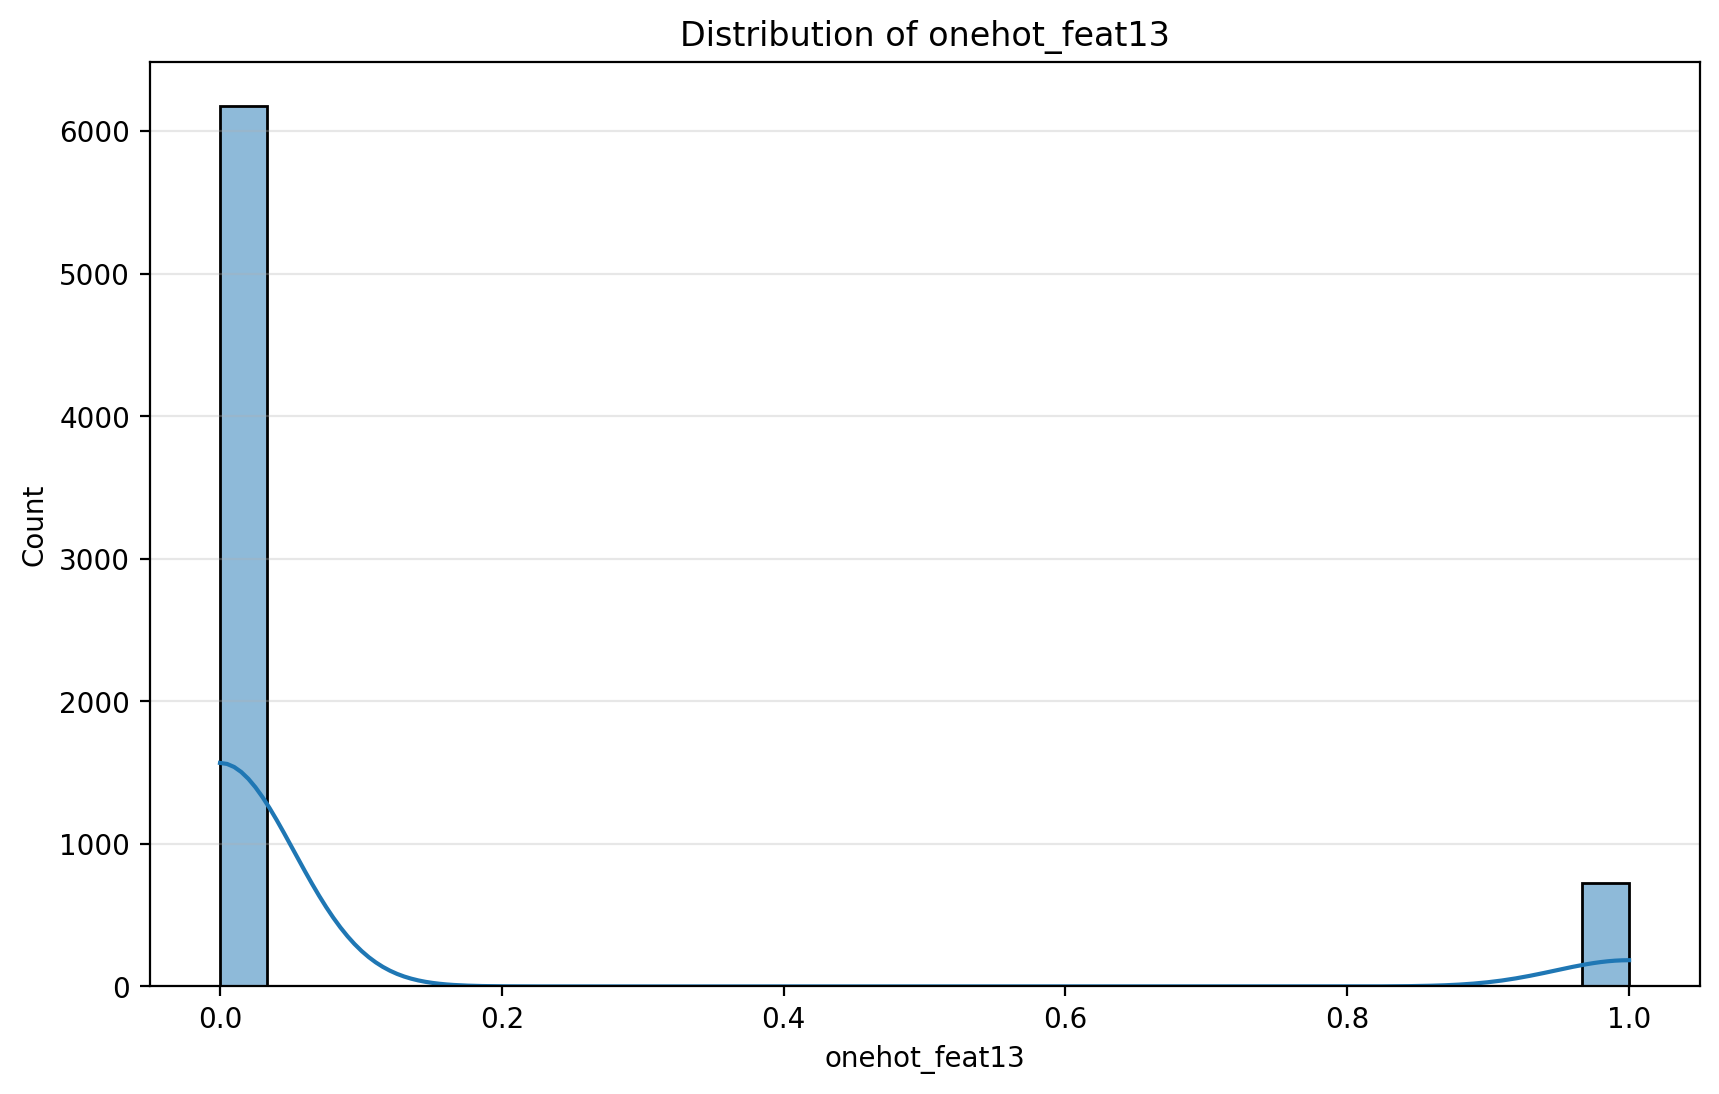

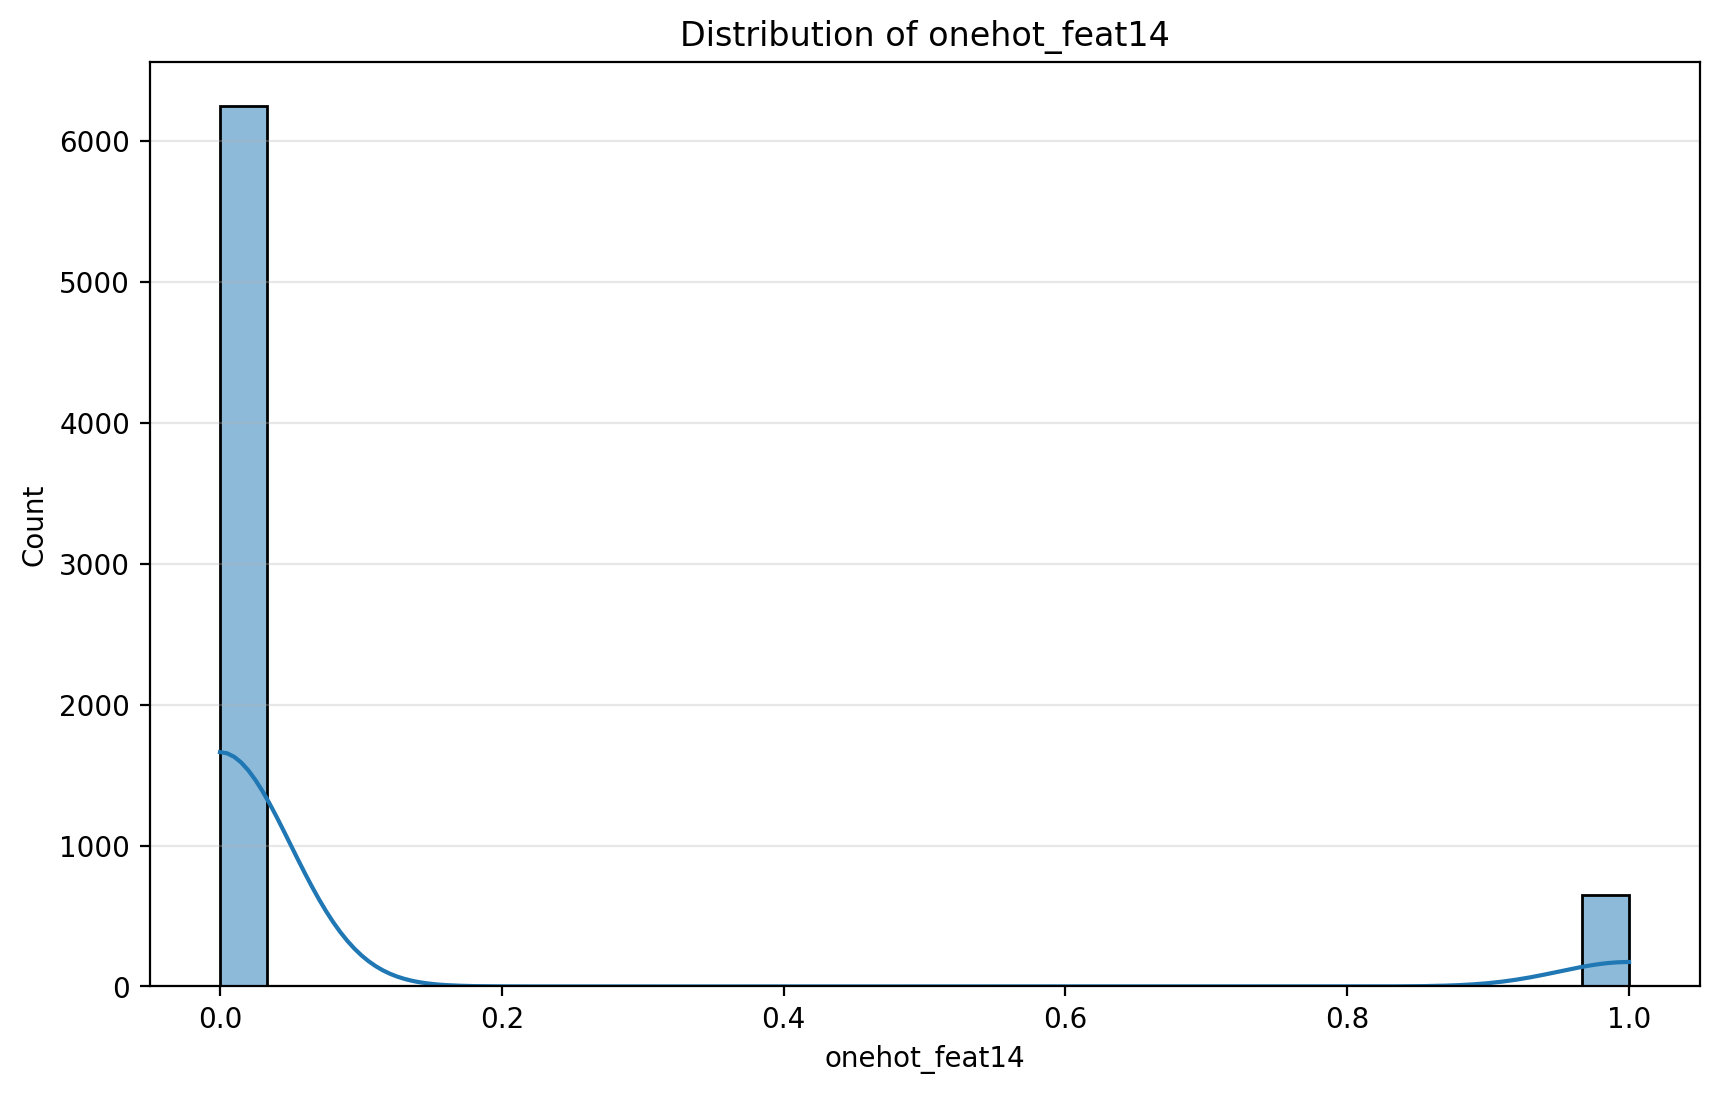

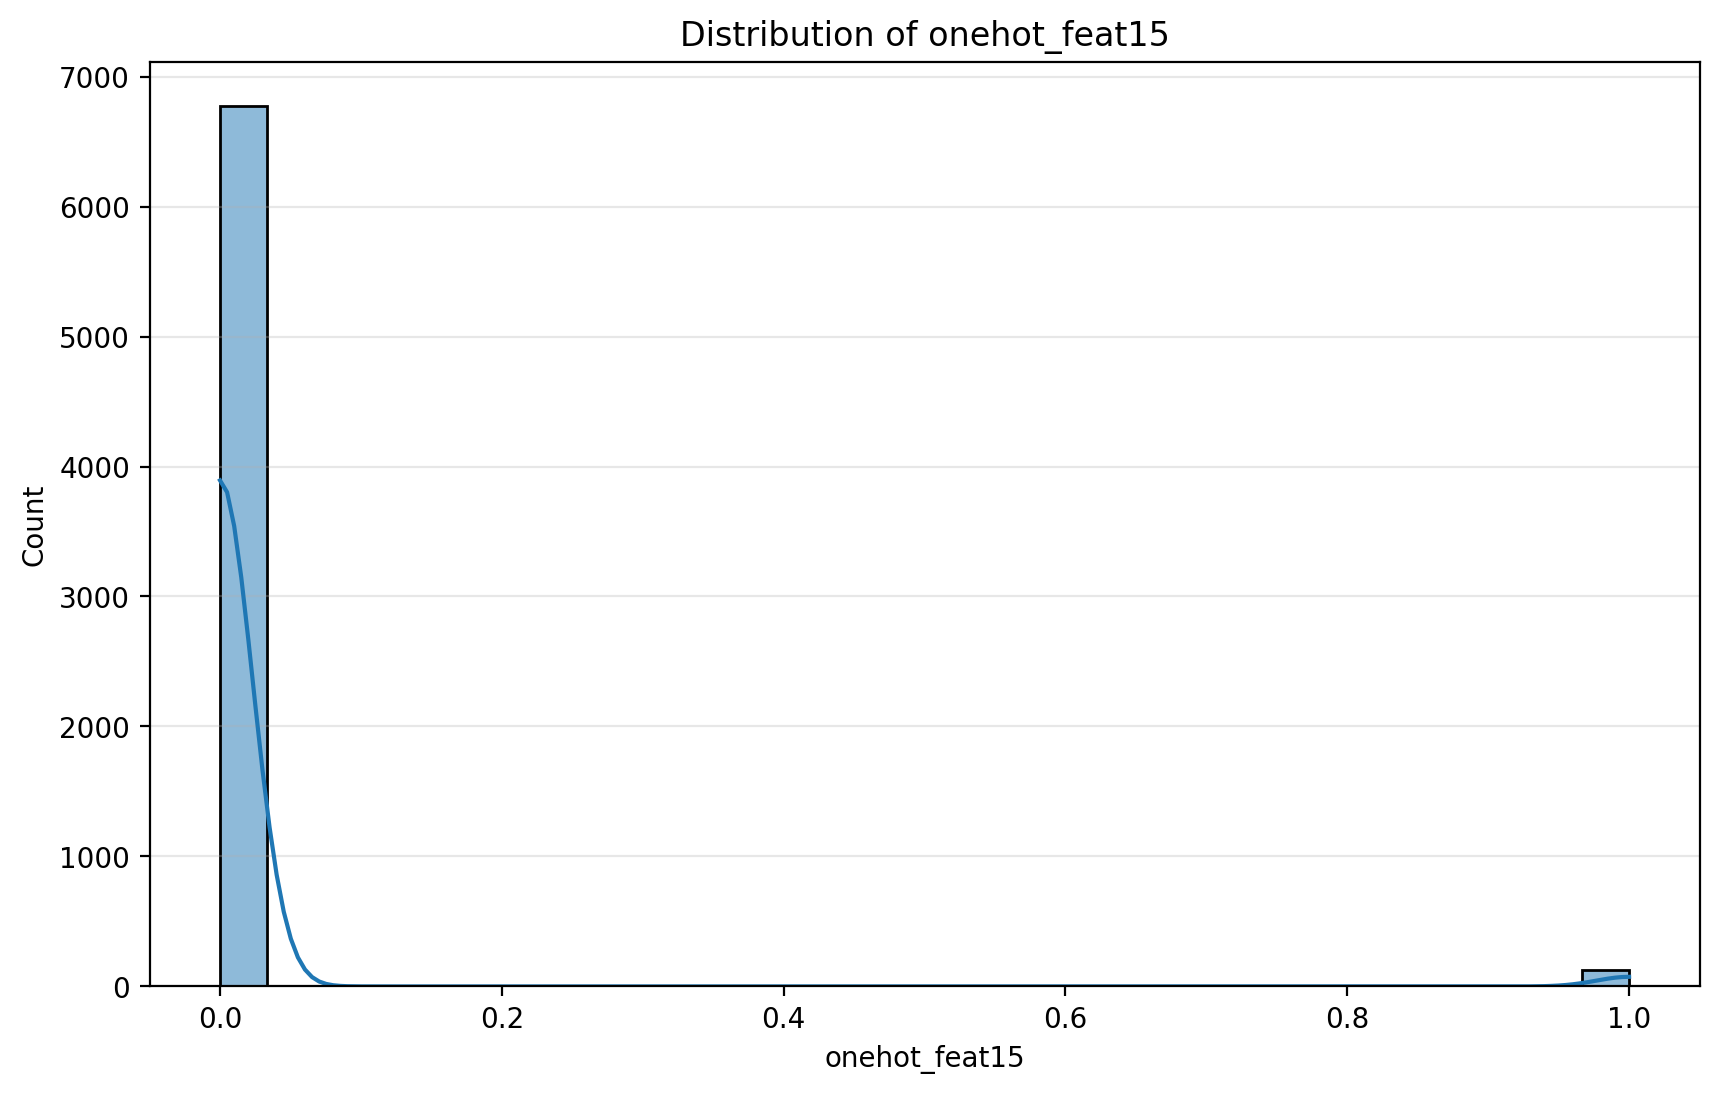

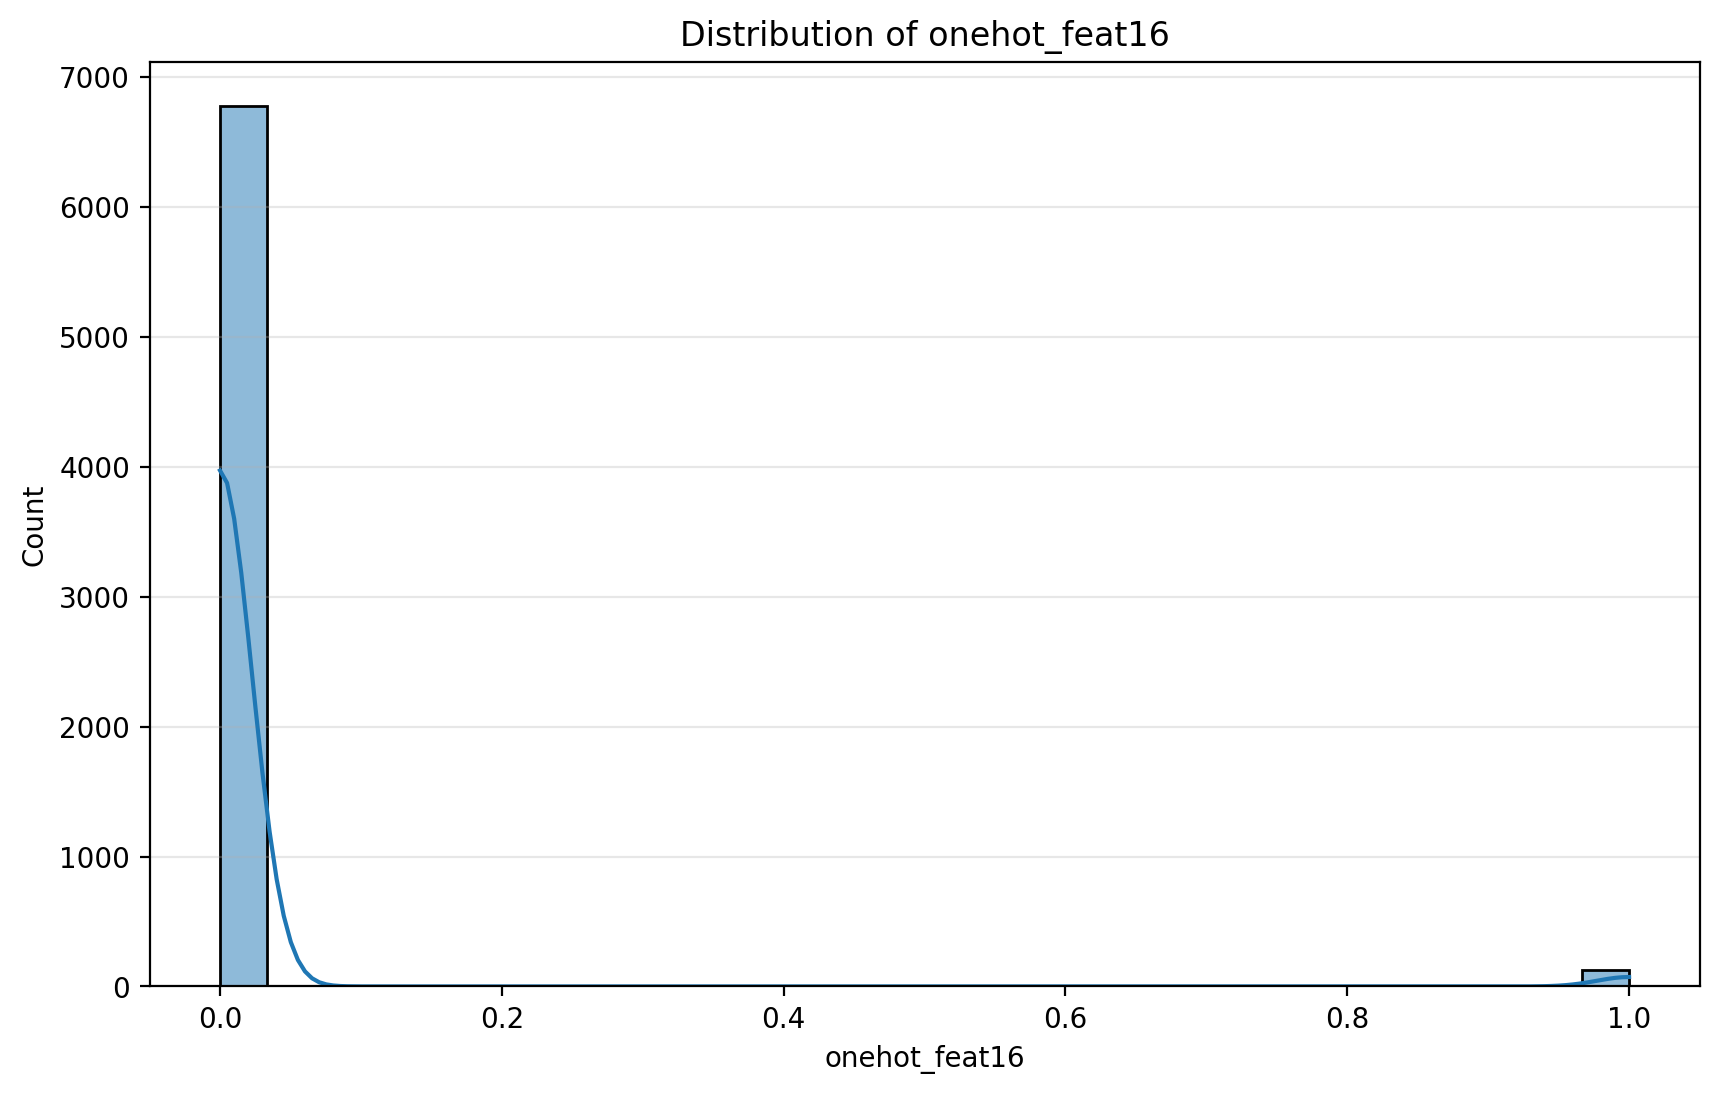

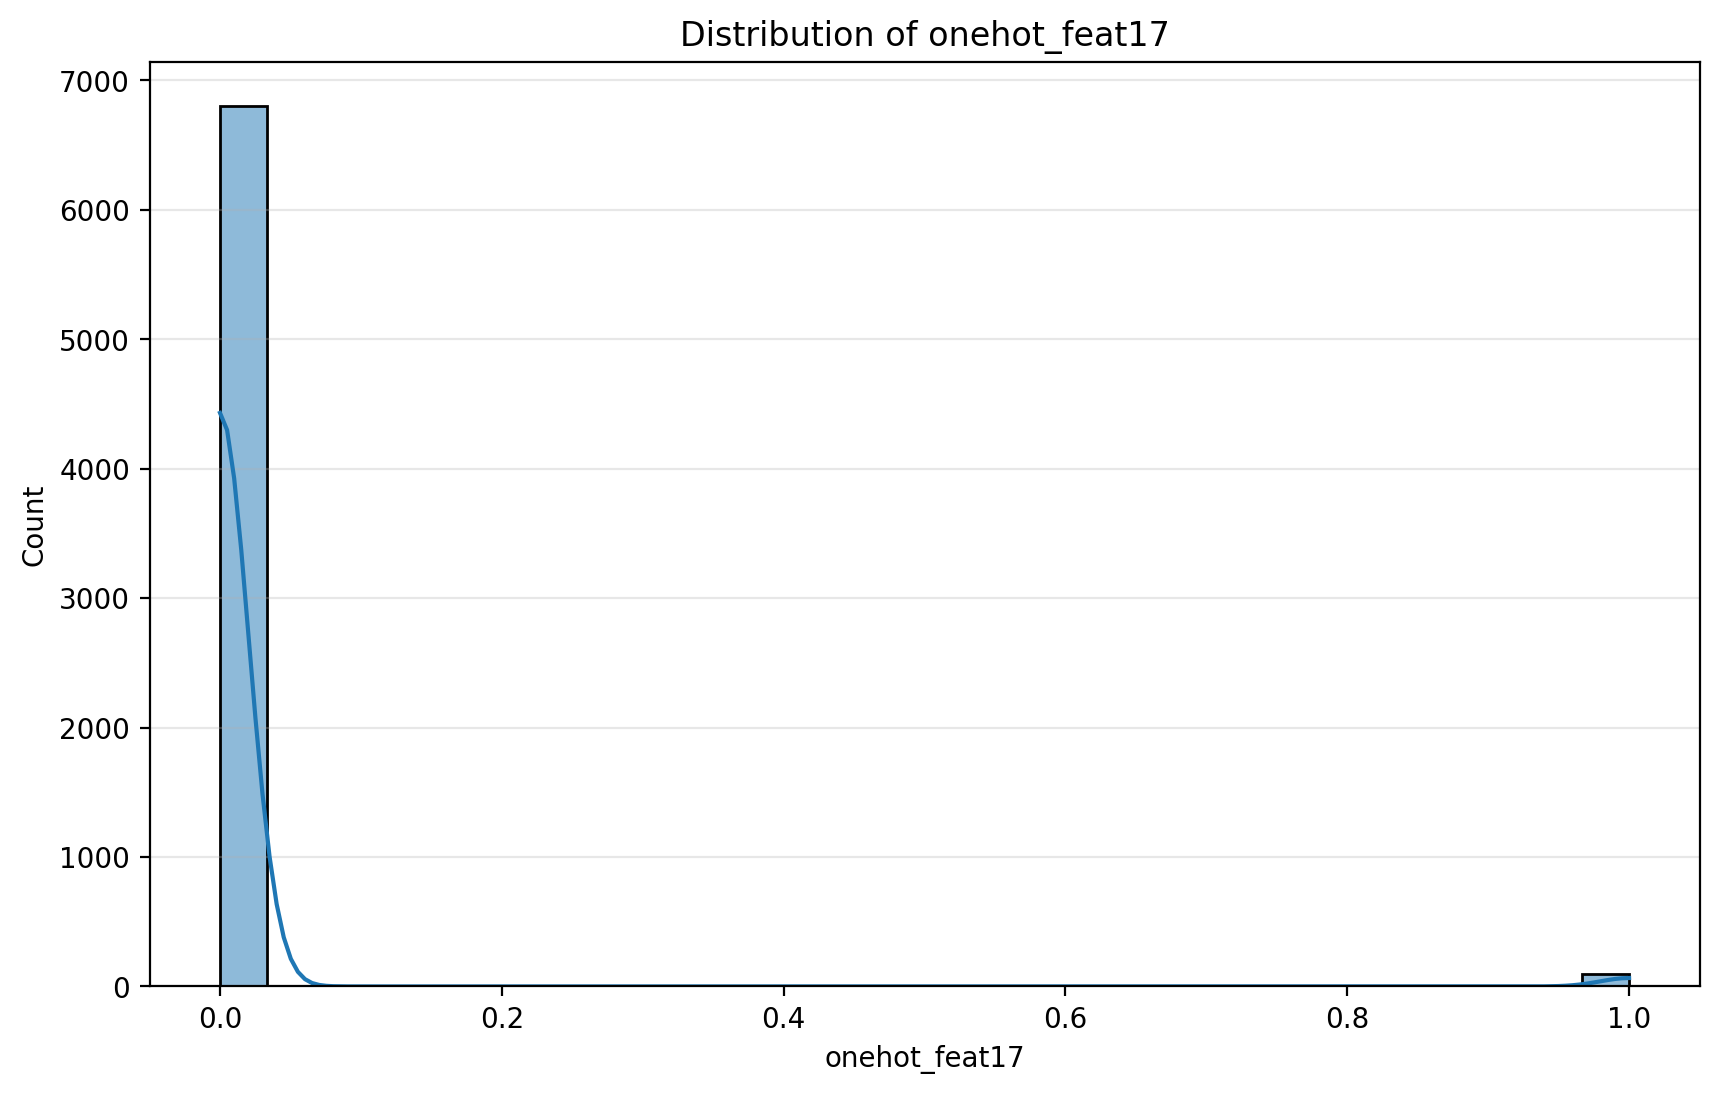

In [ ]:
# Distribution of onehot_feat0 to onehot_feat17
onehot_columns = [f"onehot_feat{i}" for i in range(18)]

for column in onehot_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=user_features_df, x=column, bins=30, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

## Item daily features

In [46]:

item_features = pd.read_csv("data/item_daily_features.csv")
item_features = item_features.dropna()
item_features = item_features.drop_duplicates()


Corrélation avec le watch_ratio :
video_id        -0.004029
comment_cnt     -0.067464
share_cnt       -0.225369
like_user_num   -0.257582
play_cnt        -0.317829
show_cnt        -0.320735
Name: watch_ratio, dtype: float64


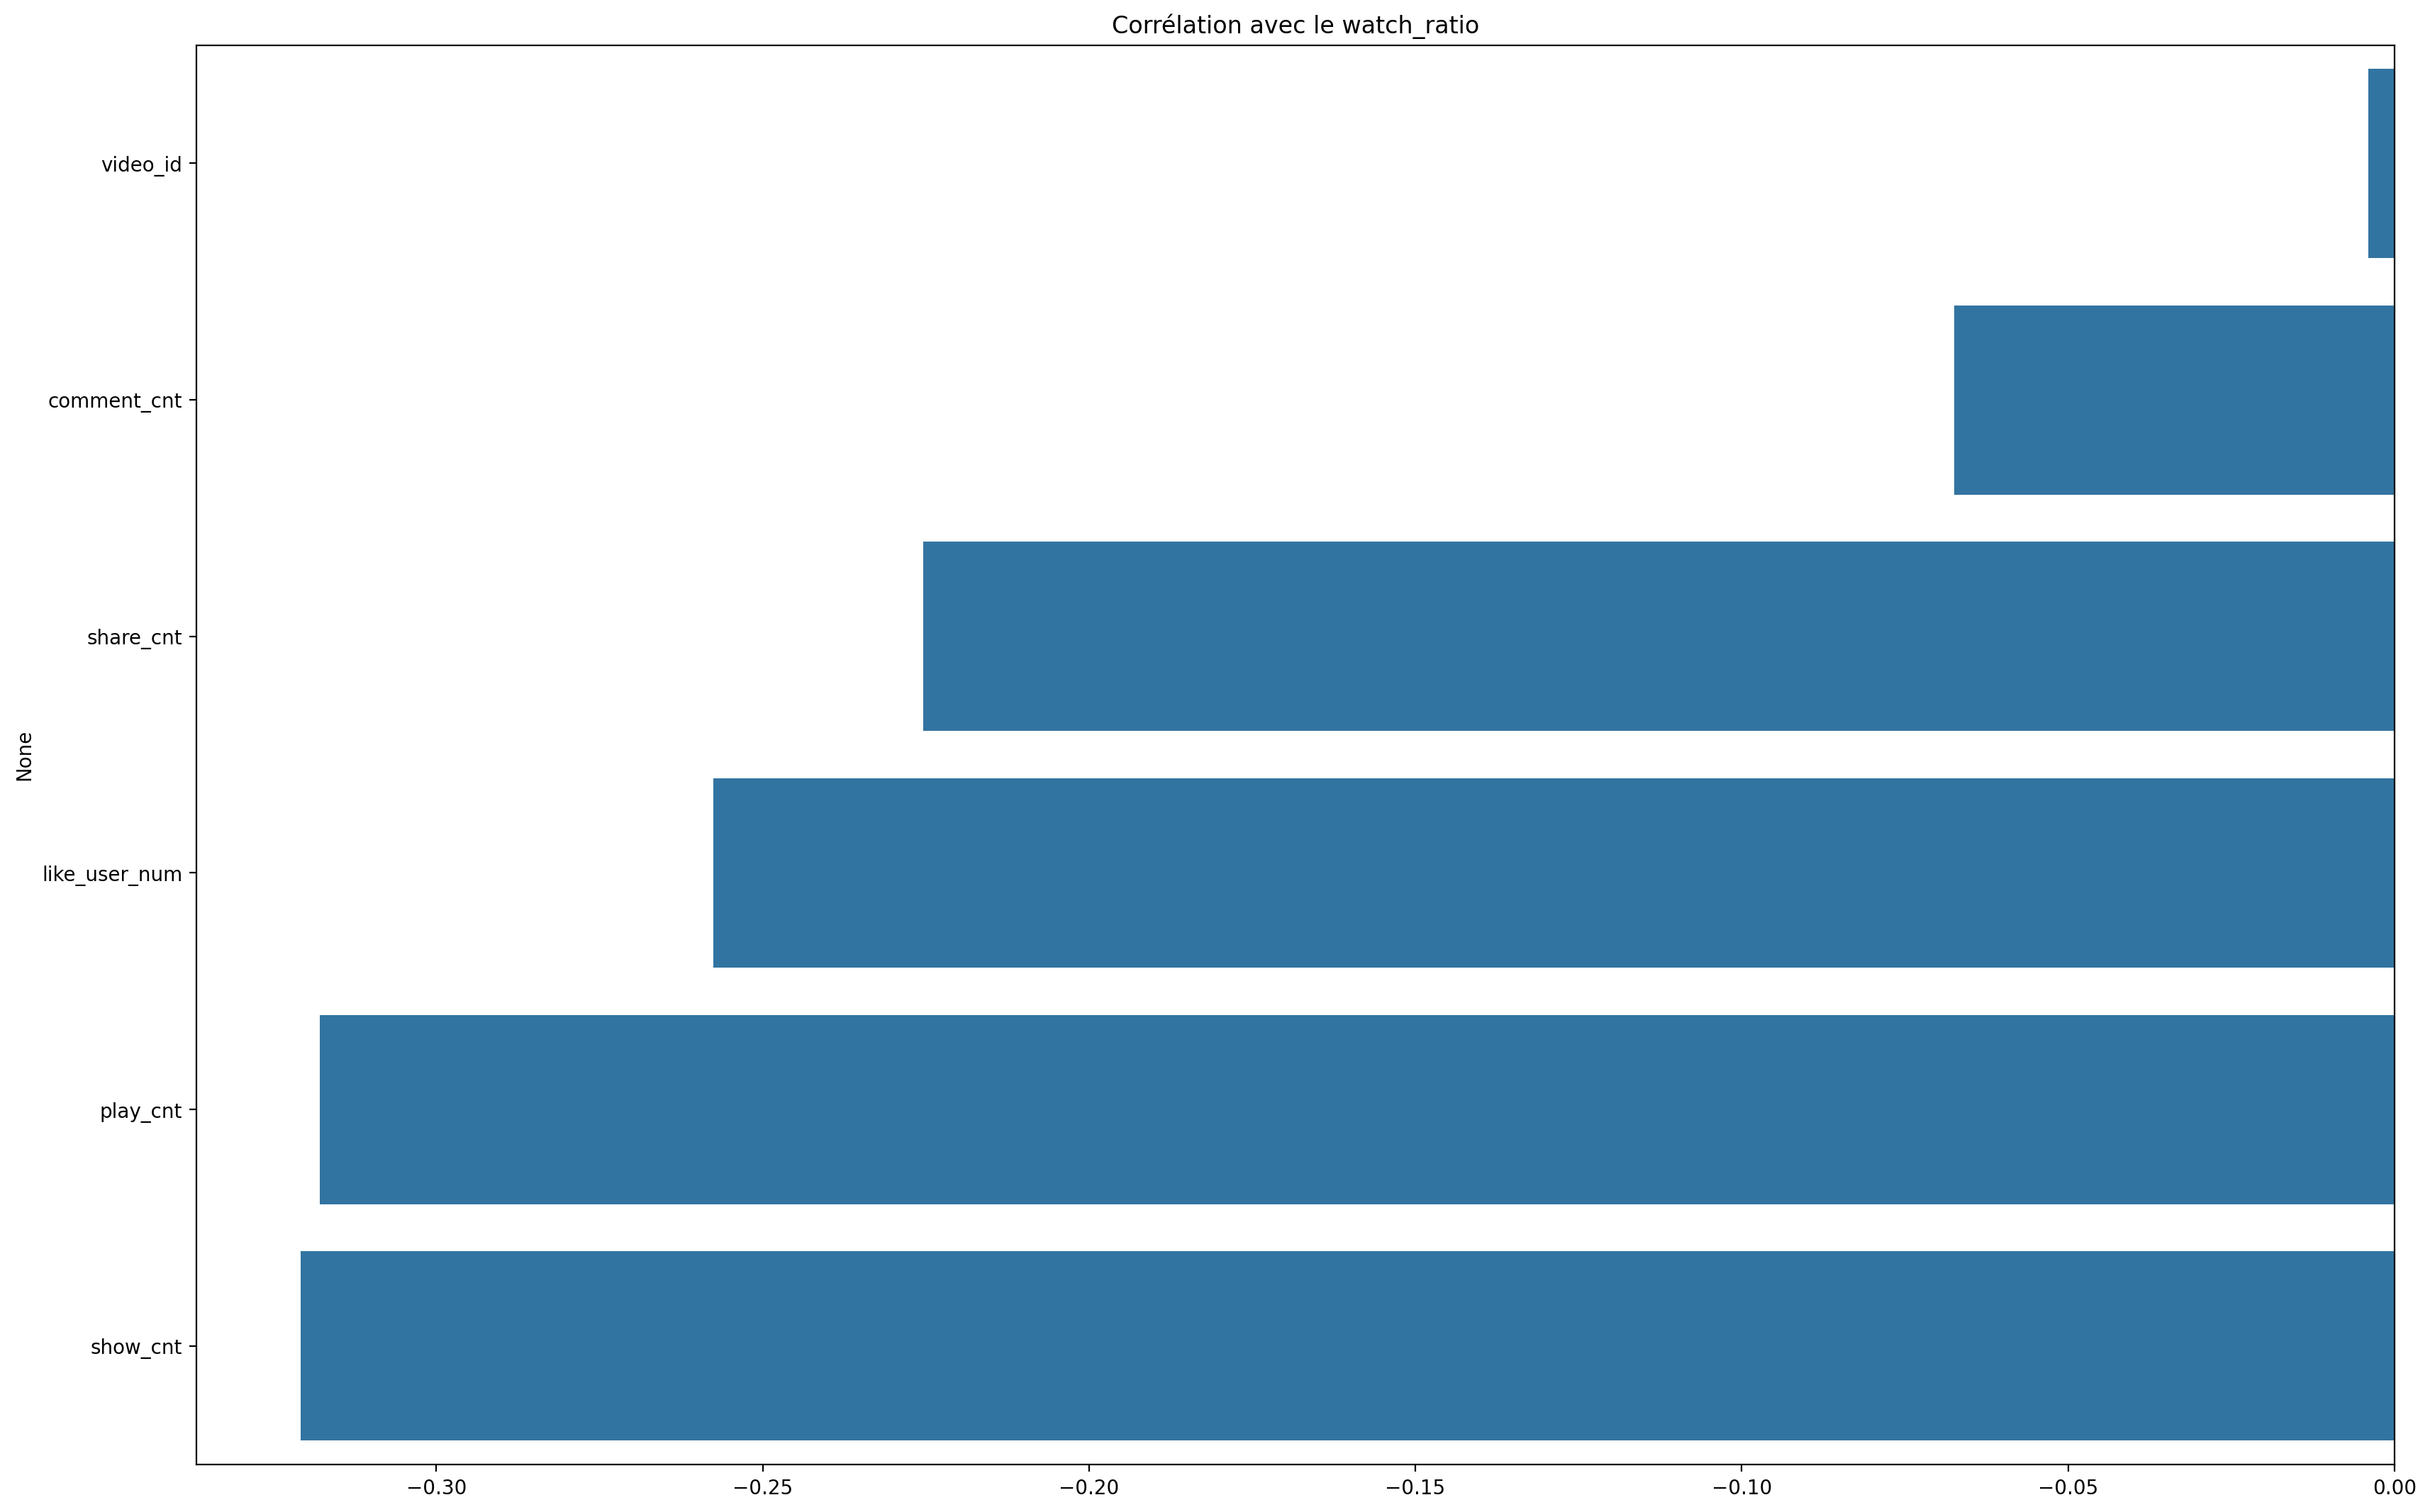

In [ ]:
agg = item_features.groupby("video_id")[[
    'show_cnt', 'play_cnt', 'like_user_num', 'share_cnt', 'comment_cnt',
]].sum()

video_watch_ratio = interactions.groupby("video_id")['watch_ratio'].mean()
agg = agg.join(video_watch_ratio, on="video_id",how="right")

# Correlation
corr = agg.corr()['watch_ratio'].drop('watch_ratio').sort_values(ascending=False)
print("Correlation with the watch_ratio :")
print(corr)

sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation with the watch_ratio")
plt.show()

## Caption category

In [59]:
caption_df = pd.read_csv("data/kuairec_caption_category.csv", encoding='utf-8')

In [60]:
caption_df = caption_df.dropna()
caption_df = caption_df.drop_duplicates()

count    10728.000000
mean        16.630593
std         15.853232
min       -124.000000
25%          7.000000
50%         15.000000
75%         28.000000
max        667.000000
Name: first_level_category_id, dtype: float64


/var/folders/9f/jfpypfpx4y3cgctjsdtf0qhh0000gn/T/ipykernel_3367/718493317.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df)


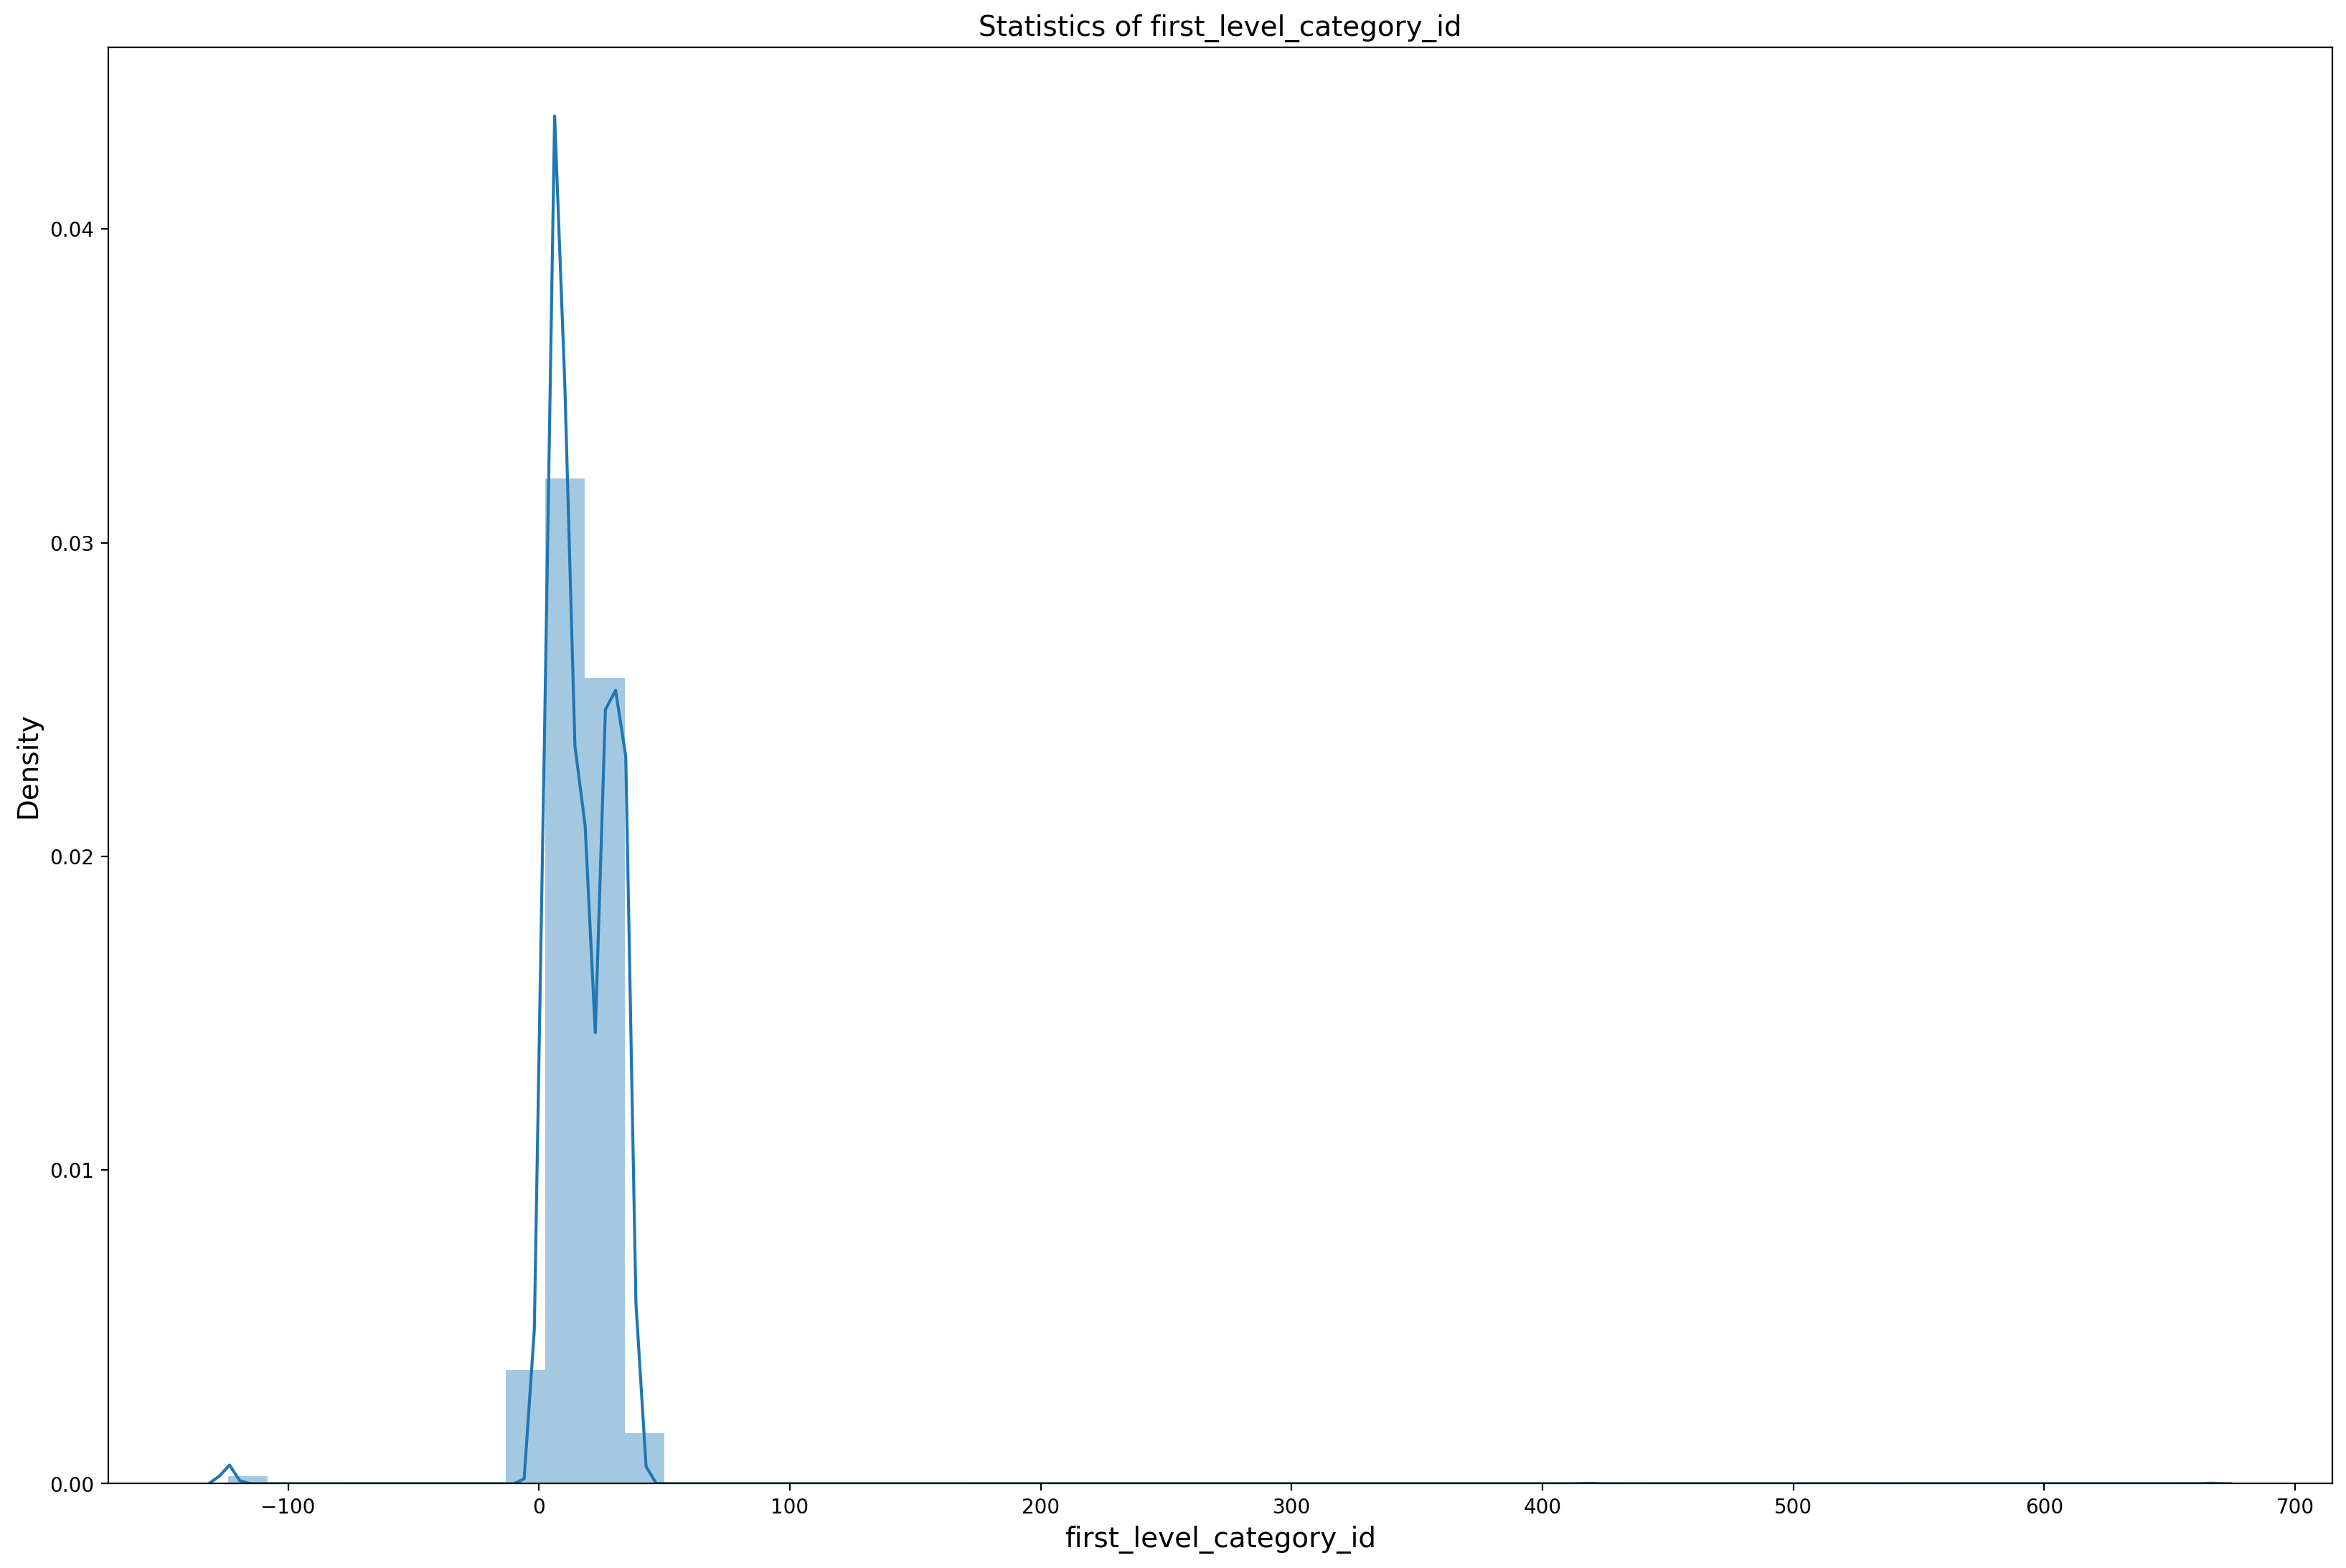

[   8.   27.    9.   26.    5.    6.   19.   12.   33.   11.    2.   34.
   18.   13.    7.   20.    1.   17.   28.   31.    4.   15.    3.   32.
   14.   25.   21.   22.   10.   35.   39.   16.   29.   24.   38.   36.
   23.   37. -124.   nan  667.  418.]


In [51]:
print(caption_df["first_level_category_id"].describe())
visual_continue(caption_df["first_level_category_id"])
print(caption_df["first_level_category_id"].unique())

count    10728.000000
mean       266.661260
std        341.524977
min       -124.000000
25%       -124.000000
50%        223.000000
75%        682.000000
max       2377.000000
Name: second_level_category_id, dtype: float64


/var/folders/9f/jfpypfpx4y3cgctjsdtf0qhh0000gn/T/ipykernel_3367/718493317.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df)


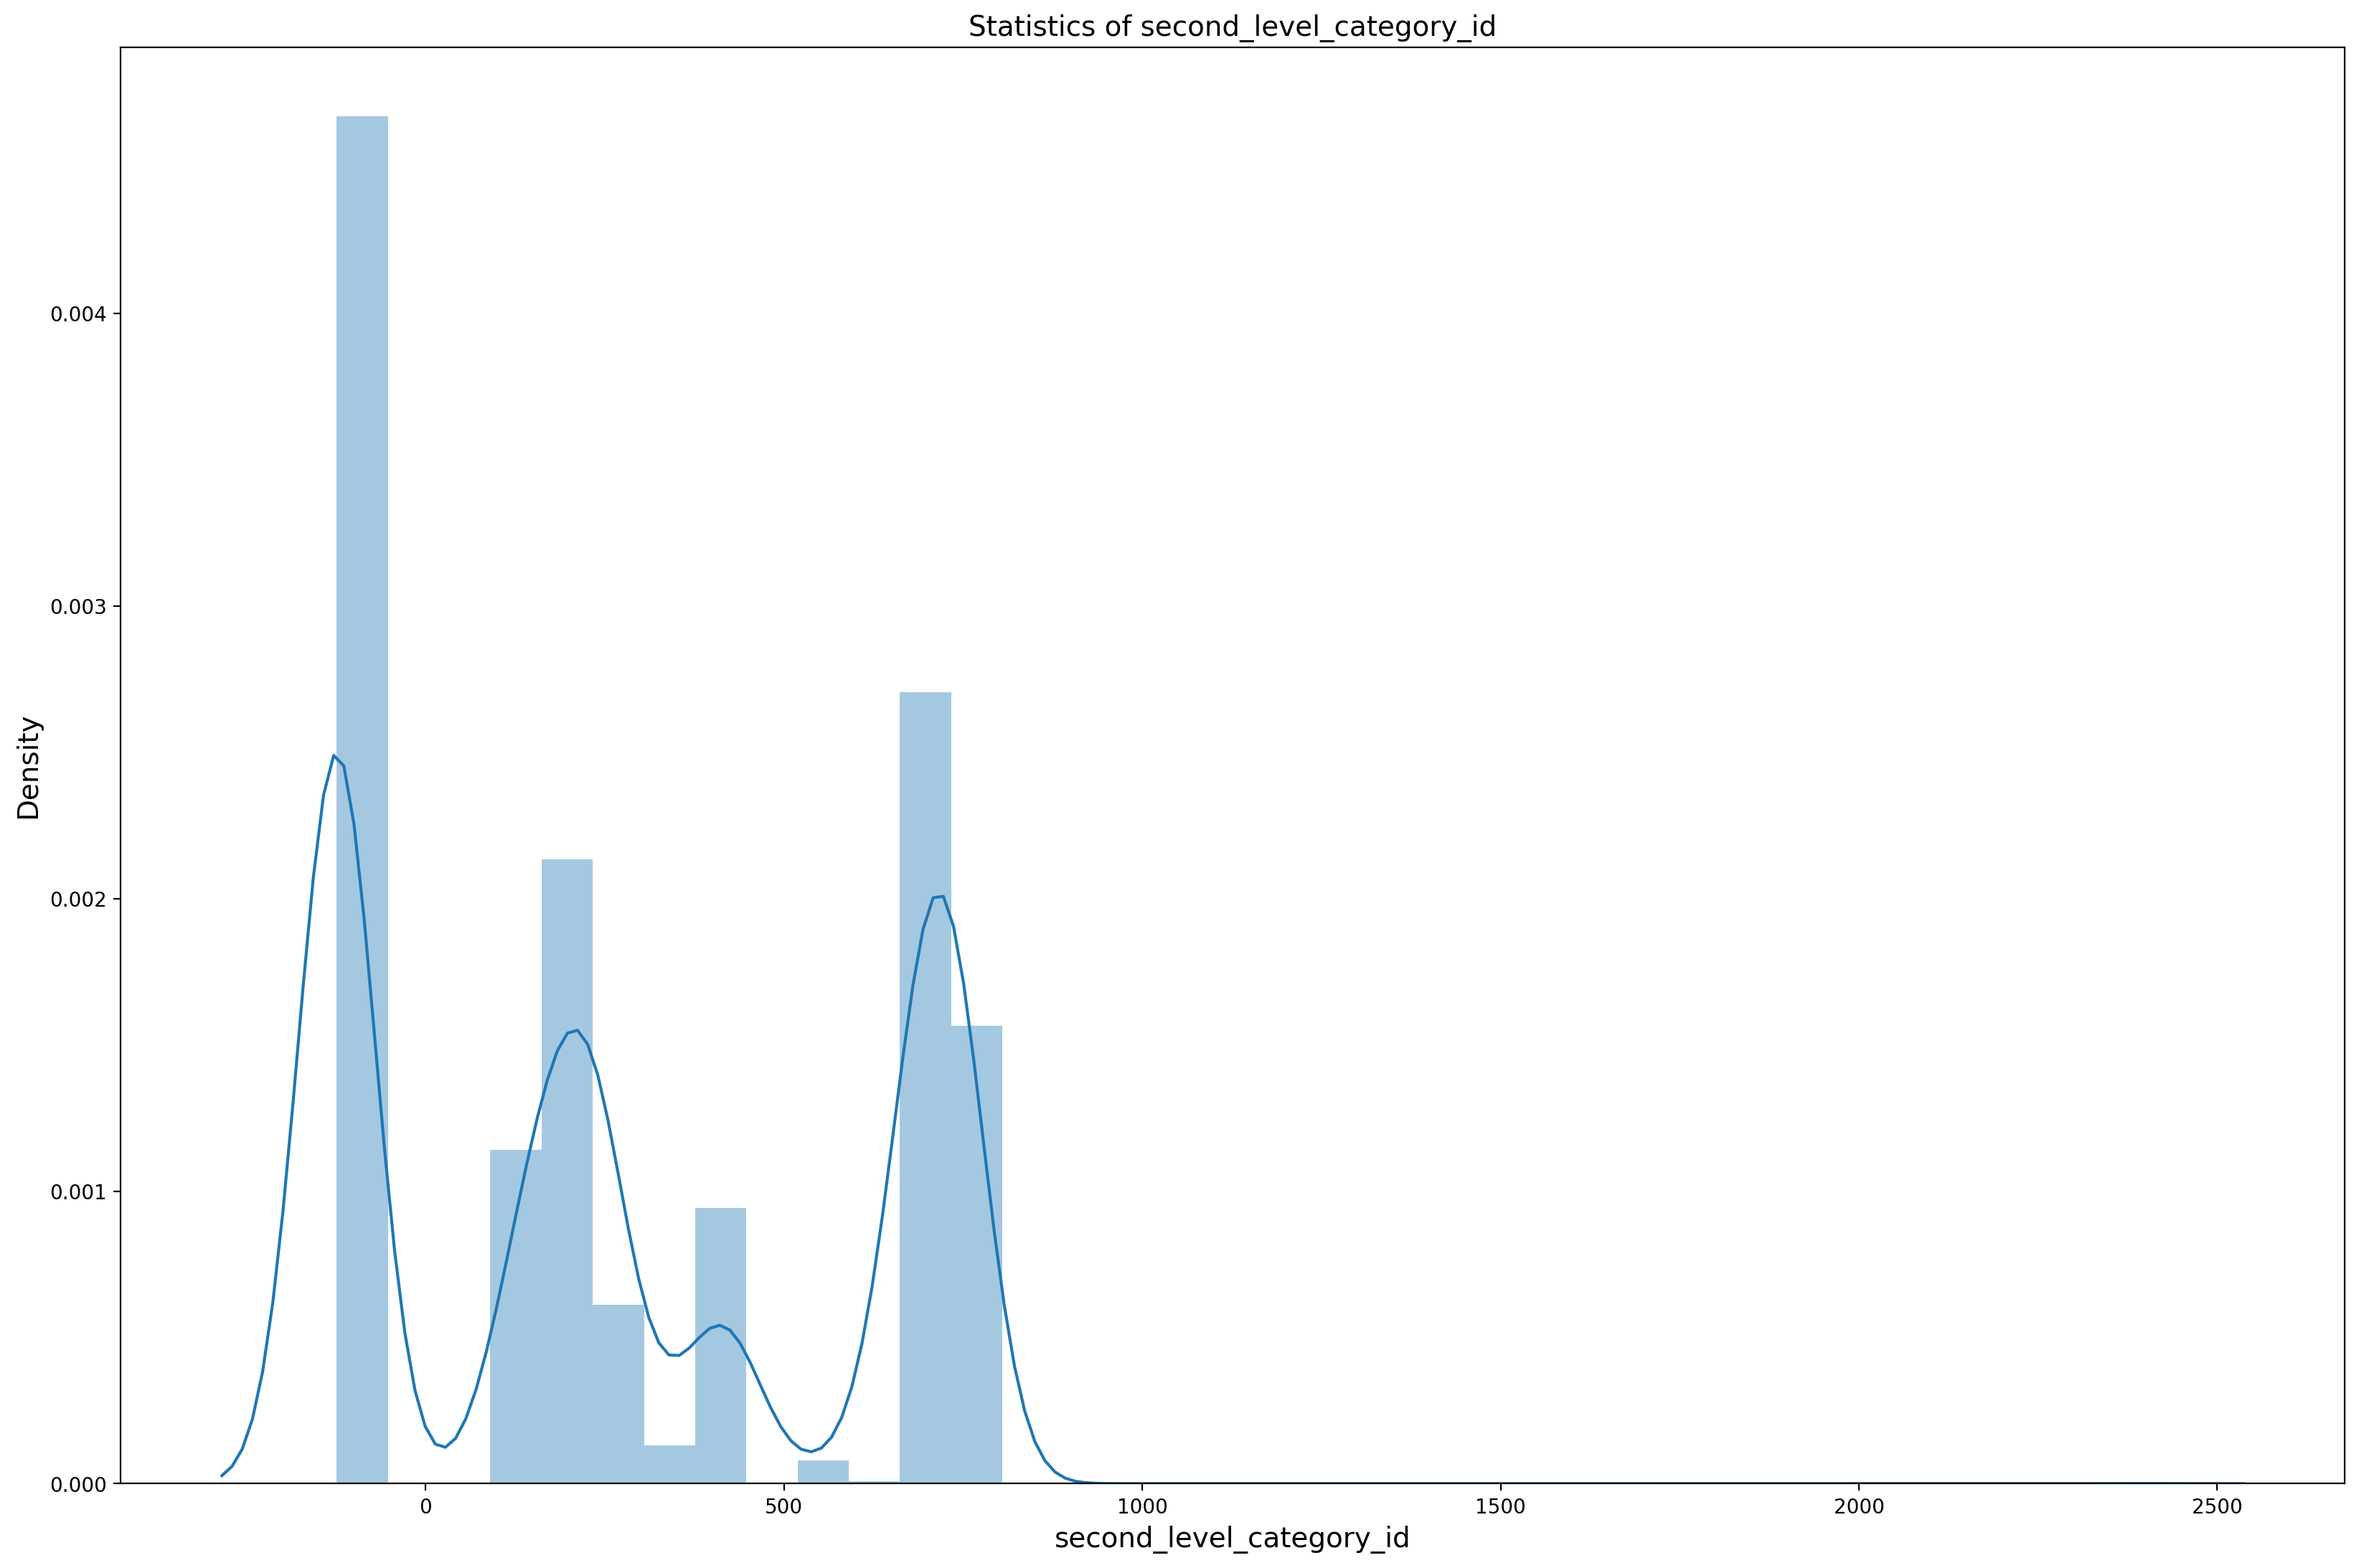

[ 673. -124.  727.  686.  737.  667.  292.  724.  744.  418.  561.  725.
  733.  195.  723.  722.  233.  136.  692.  368.  119.  712.  126.  155.
  672.  168.  272.  115.  711.  223.  162.  153.  235.  736.  128.  745.
  170.  716.  690.  386.  548.  130.  271.  719.  728.  387.  674.  147.
  179.  680.  129.  689.  232.  739.  702.  721.  729.  666.  684.  268.
  696.  665.  373.  675.  169.  154.  691.  707.  698.  161.  678.  683.
  714.  110.  374.  318.  319.  693.  699.  224.  214.  593.  748.  270.
  738.  201.  167.  204.  220.  545.  330.  679.  703.  735.  314.  348.
  697.  732.   nan  325.  701.  118. 2377.  718.  670.  354.  688.  681.
  324.  352.  372.  203.  389.  717.  327.  694.  213.  720.  677.  705.
  715.  747.  713.  347.  264.  706.  163.  687.  317.  263.  708.  682.
  564.  563.  160.  402.  341.  749.  267.  695.]


In [52]:
print(caption_df["second_level_category_id"].describe())
visual_continue(caption_df["second_level_category_id"])
print(caption_df["second_level_category_id"].unique())

count    10724.000000
mean       661.434446
std       1104.049489
min       -124.000000
25%       -124.000000
50%       -124.000000
75%       1524.000000
max       2676.000000
Name: third_level_category_id, dtype: float64


/var/folders/9f/jfpypfpx4y3cgctjsdtf0qhh0000gn/T/ipykernel_3367/718493317.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df)


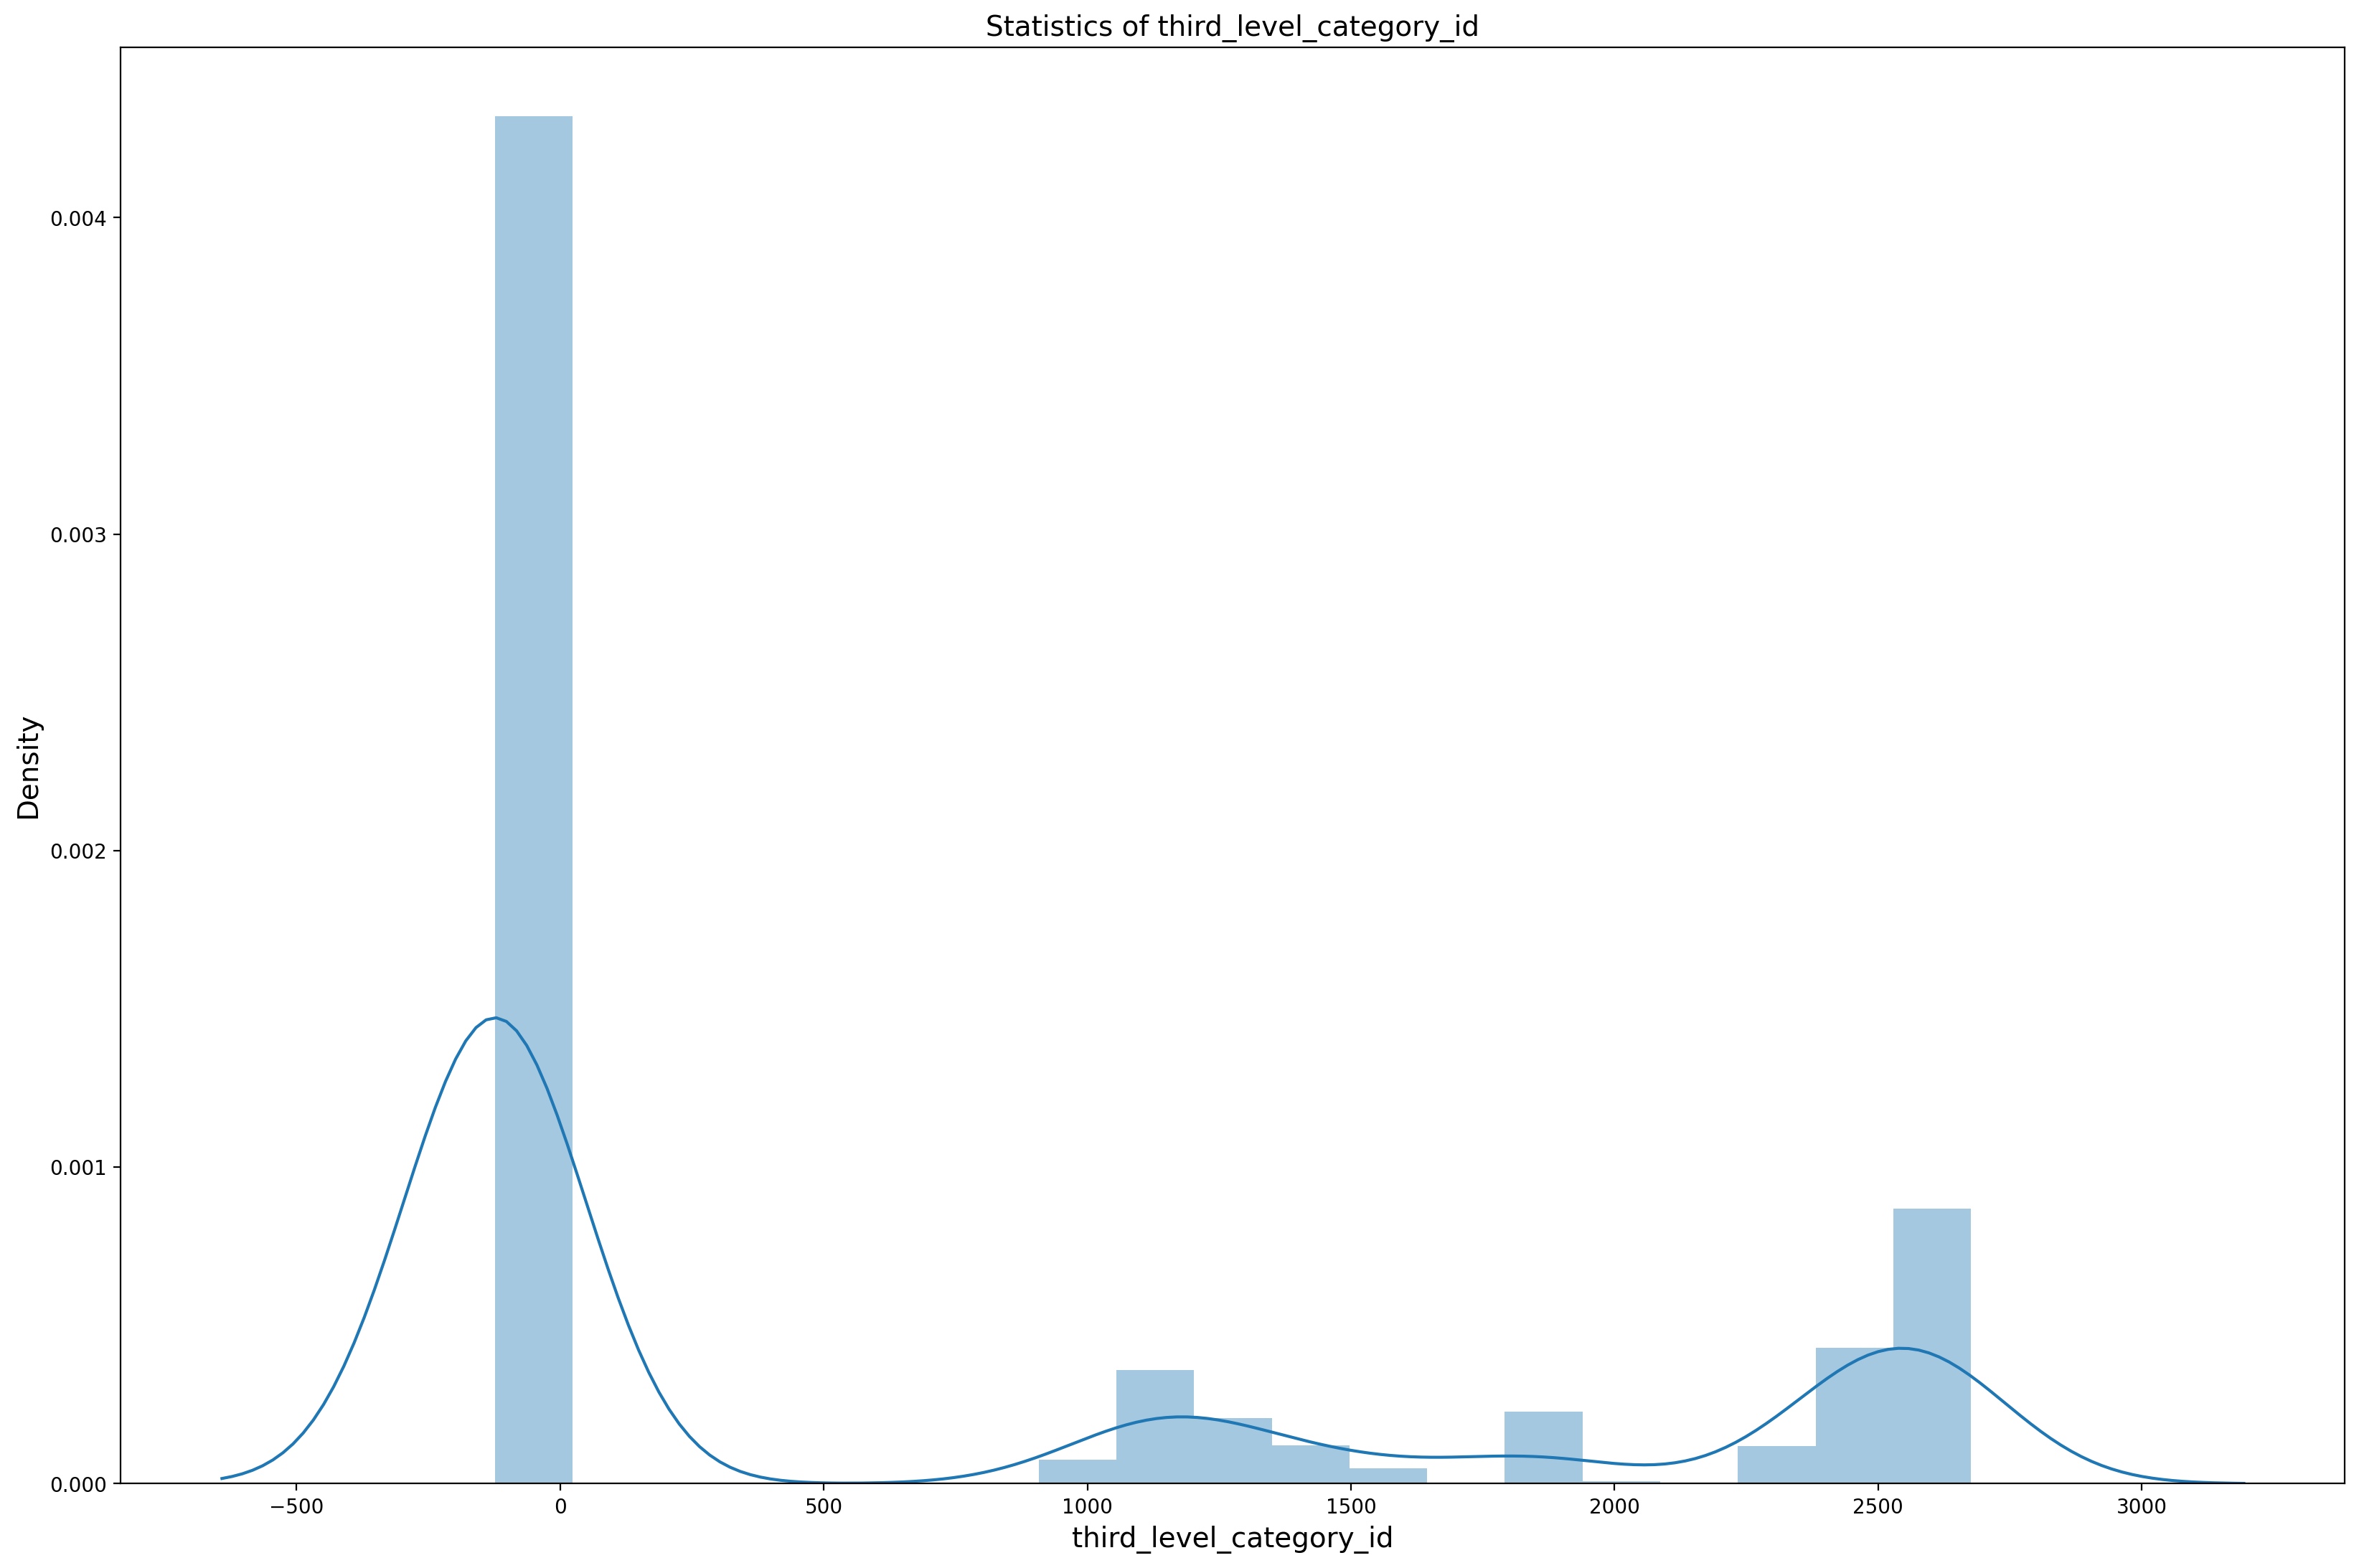

[-124. 2434. 2596. 2375. 1461. 2550. 2637. 2615. 1204. 2544. 1169. 1054.
 1872. 2545. 2370. 2493. 1056. 2636. 1153. 1132. 1804. 1272. 2591. 1348.
 2641. 1460. 1158. 2510. 1875. 1053. 2638. 1206. 2396. 2537. 2565. 1231.
 2442. 1064. 1143. 2519. 1163. 1830. 2595. 1458. 2616. 2415. 1069. 2455.
 1524. 2622. 1859. 1205. 2541. 2446. 2594. 1877. 1838. 2435. 2518. 2477.
 2360. 2659. 2377. 1148. 2445. 2661. 1051. 2406. 1156. 2411. 2395. 1102.
 2432. 1155. 1059. 1154. 2491. 1121. 1149. 2499. 2650. 1456. 2555. 2394.
 2572. 2429. 1987. 2508. 2385. 2653. 2603. 1887. 2478. 1168. 2516. 1988.
 1827. 1823. 2488. 2303. 1242. 1152. 1803. 1873. 1104. 2567. 2469. 1057.
 2548. 2484.   nan 2472. 2528. 2554. 2431. 2374. 1876. 1055. 2532. 1065.
 2424. 1237. 2534. 2520. 2669. 2451. 1160. 2604. 1173. 1956. 2512. 2334.
 1144. 1984. 1234. 2539. 1159. 2658. 2473. 2355. 2599. 1854. 2407. 2397.
 2549. 1846. 2487. 2562. 2546. 2495. 2498. 1106. 2540. 1142. 2444. 1894.
 2526. 2441. 1058. 2384. 2461. 2361. 2409. 1133. 25

In [53]:
print(caption_df["third_level_category_id"].describe())
visual_continue(caption_df["third_level_category_id"])
print(caption_df["third_level_category_id"].unique())

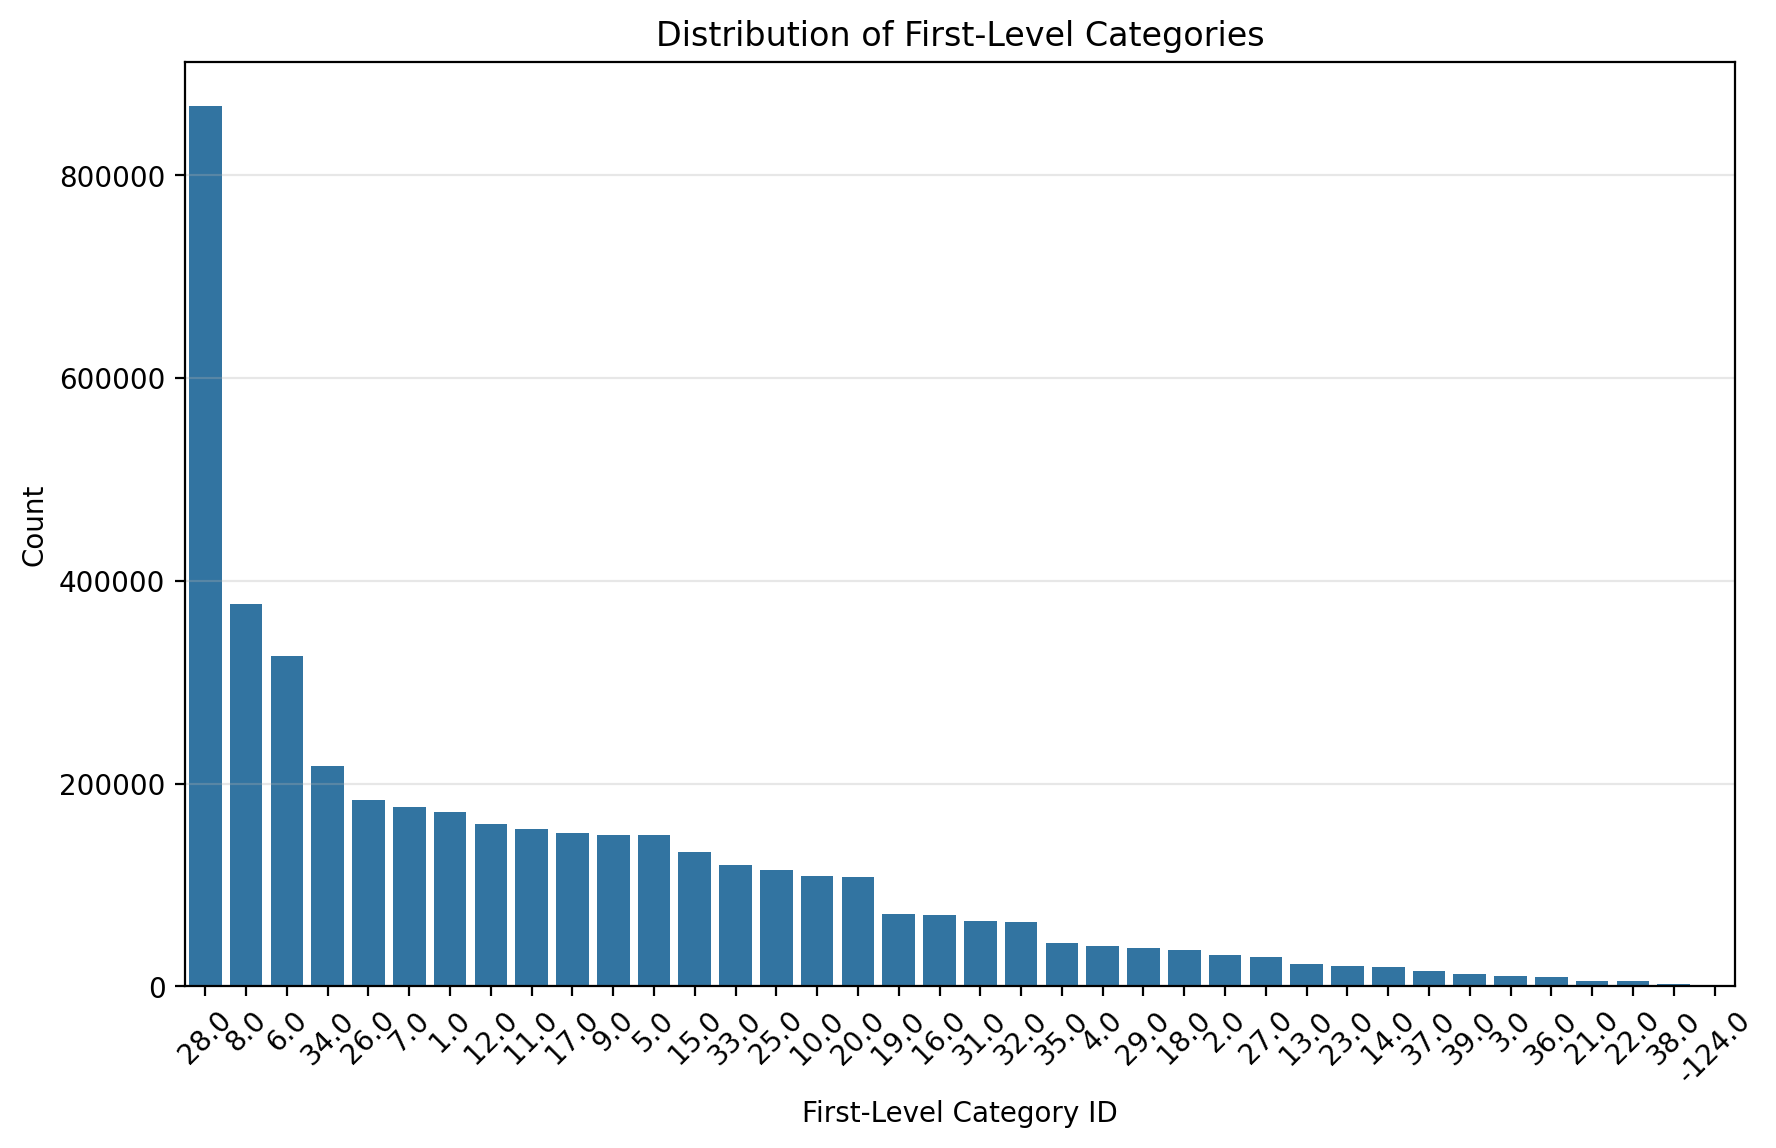

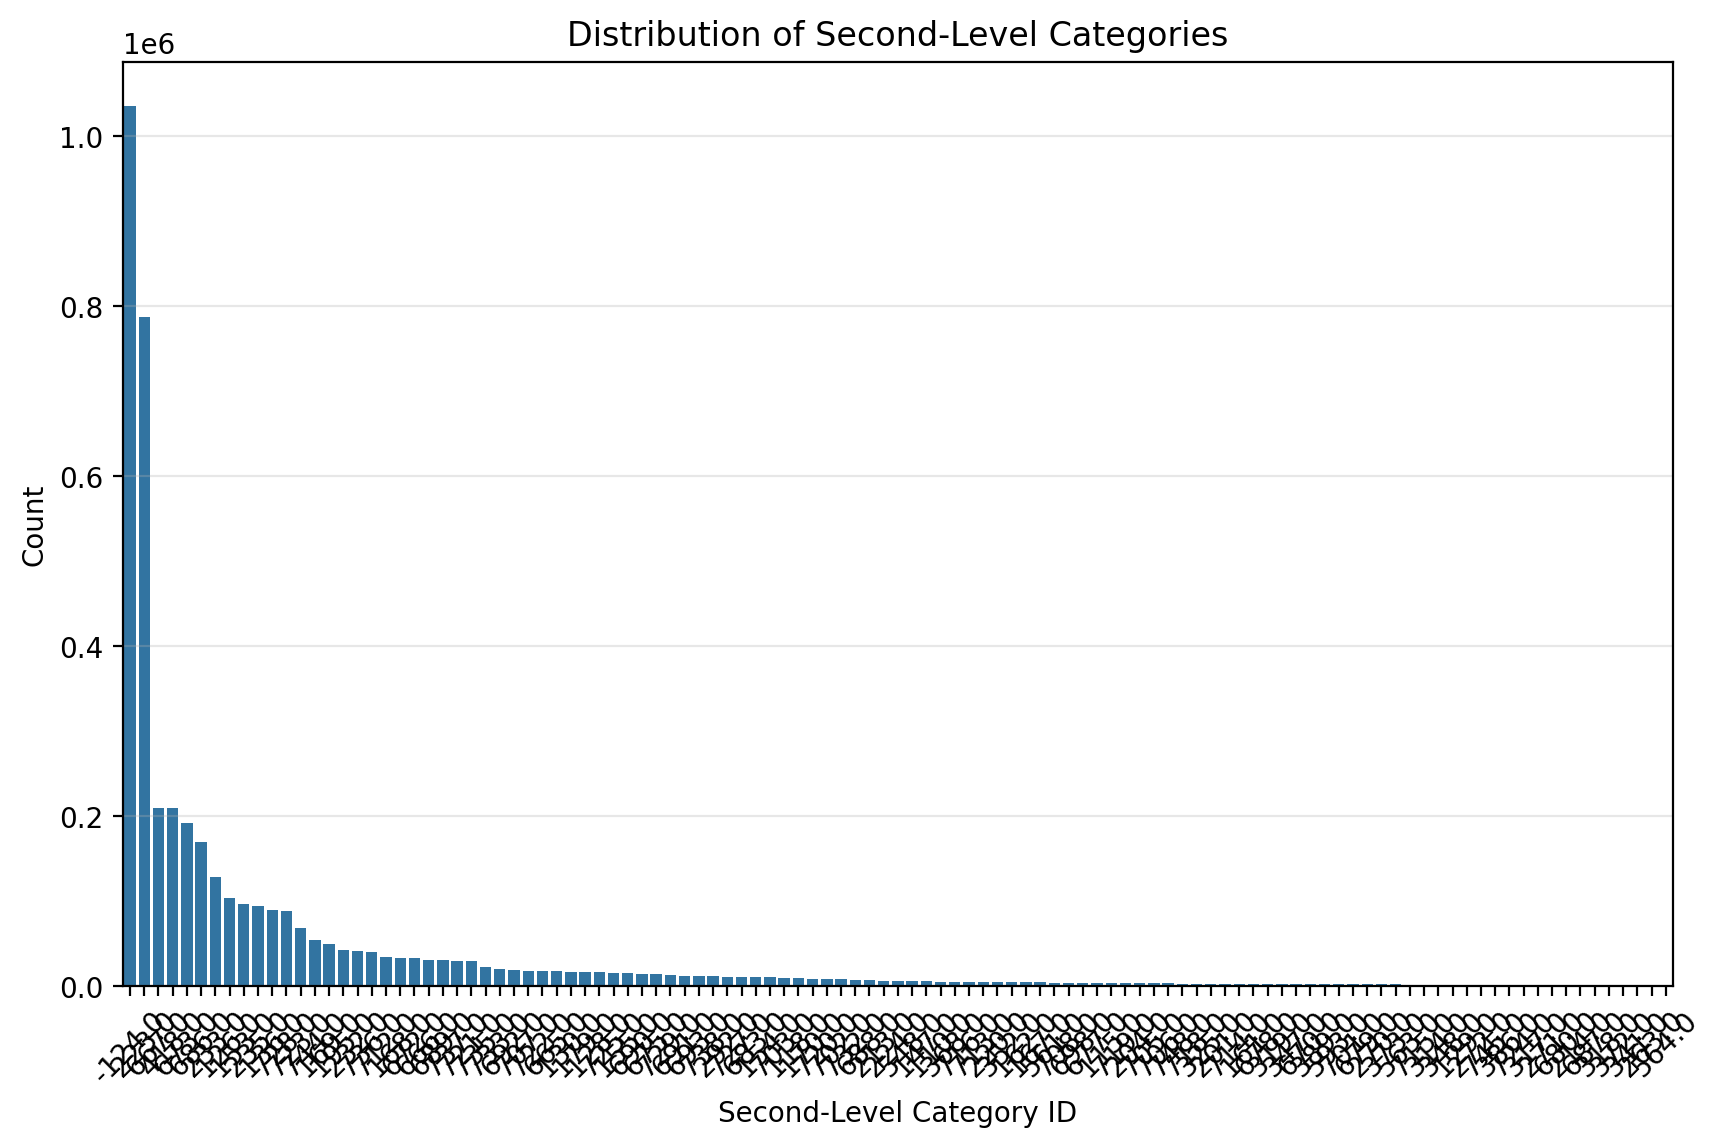

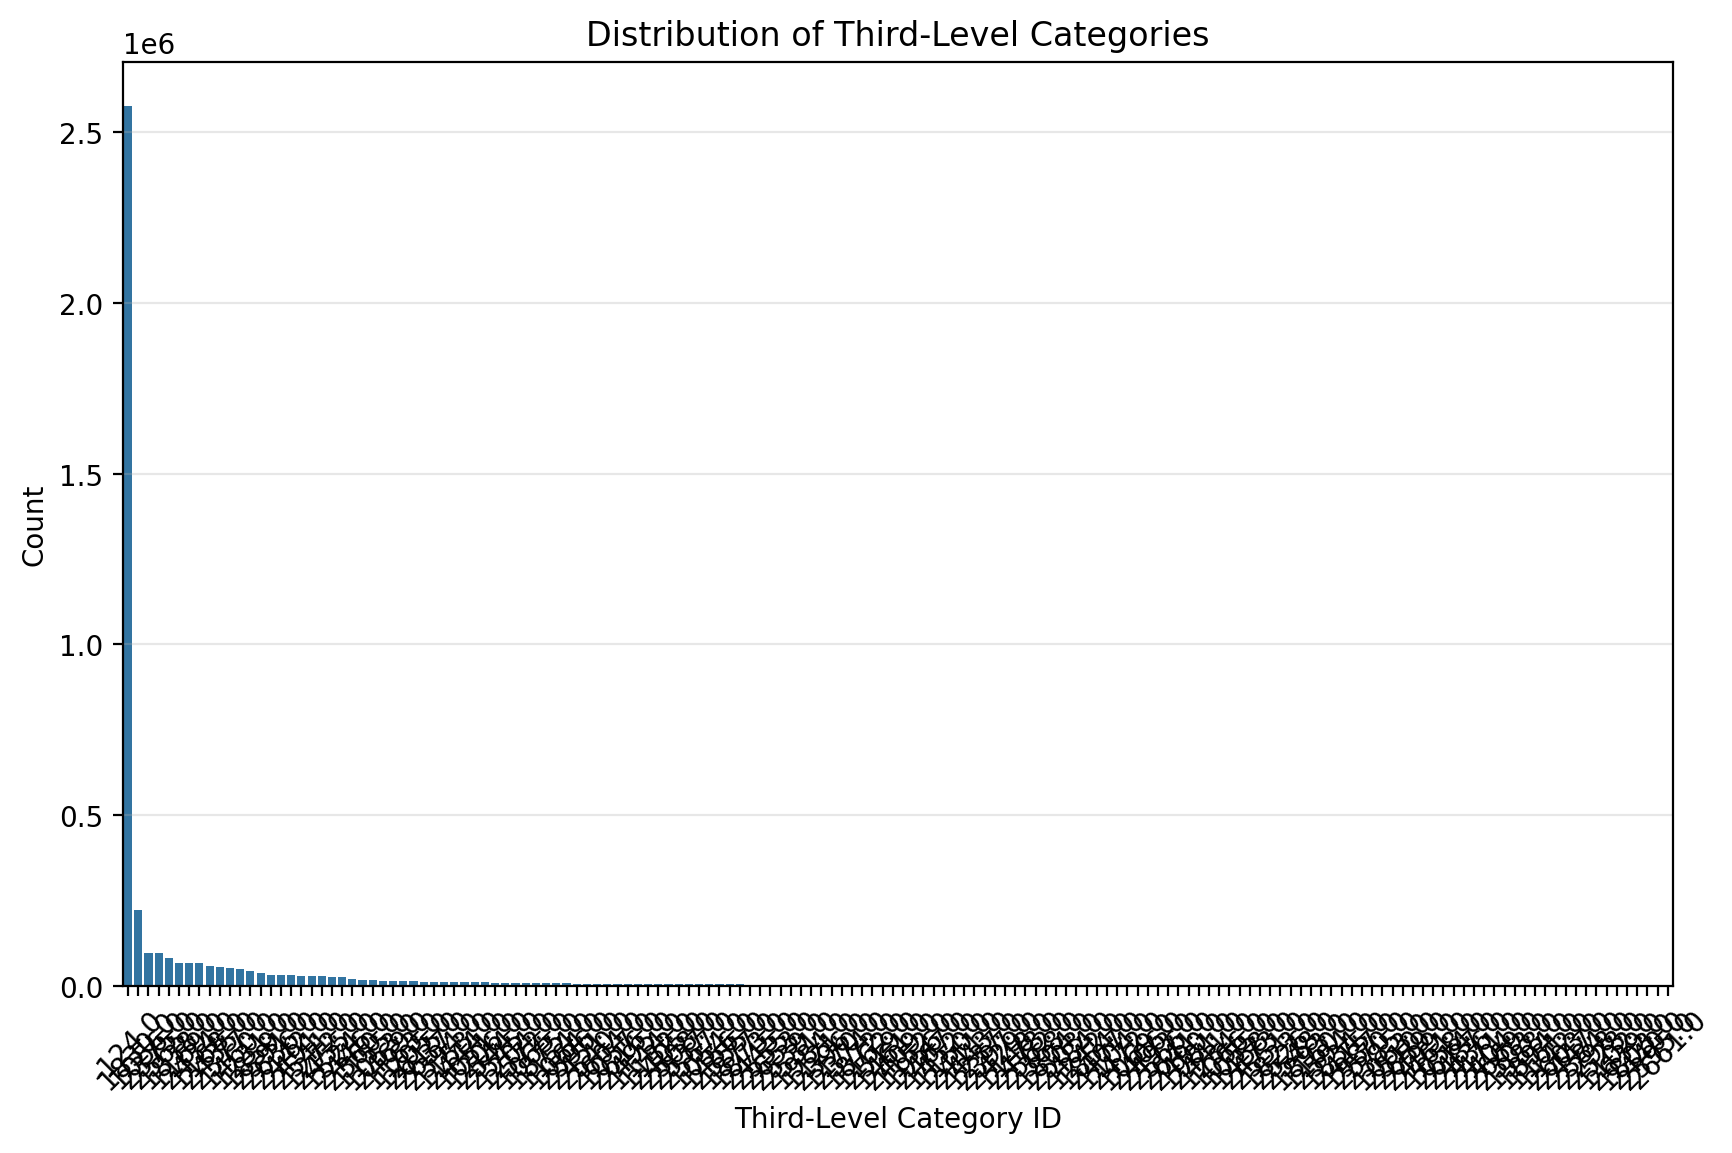

In [63]:
# Ensure video_id columns have the same data type
interactions["video_id"] = interactions["video_id"].astype(int)
caption_df["video_id"] = caption_df["video_id"].astype(int)

# Merge interactions and caption_df on video_id
merged_categories = interactions.merge(
    caption_df[["video_id", "first_level_category_id", "second_level_category_id", "third_level_category_id"]],
    on="video_id",
    how="left"
)

# Plot the distribution of first-level categories
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_categories, x="first_level_category_id", order=merged_categories["first_level_category_id"].value_counts().index)
plt.title("Distribution of First-Level Categories")
plt.xlabel("First-Level Category ID")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of second-level categories
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_categories, x="second_level_category_id", order=merged_categories["second_level_category_id"].value_counts().index)
plt.title("Distribution of Second-Level Categories")
plt.xlabel("Second-Level Category ID")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of third-level categories
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_categories, x="third_level_category_id", order=merged_categories["third_level_category_id"].value_counts().index)
plt.title("Distribution of Third-Level Categories")
plt.xlabel("Third-Level Category ID")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.show()